# Libraries 

In [2]:
#pip install pytrends
#!pip install tensorflow
#pip install pm

In [3]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import random
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from scipy.signal import savgol_filter
from tensorflow.keras.models import Model , Sequential
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, LayerNormalization, GlobalAveragePooling1D , GRU 
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.api as sm
from scipy.stats import skew
from scipy.stats import boxcox
from plotly.subplots import make_subplots




# Load Data

In [4]:
data = pd.read_csv('selected_google_trends_value.csv')

#preprocesseed data
df=pd.read_excel('E-Commerce Transactions Value.xlsx')

In [5]:
data.head()

date  Avon  Property24  We Buy Cars  Game  Telkom  Cars for Sale  \
0  2018-12-30    34          23            7    11      61             25   
1  2018-12-31    29          22            5    13      72             20   
2  2019-01-01    39          30            9    13      58             27   
3  2019-01-02    42          31           11    13      81             30   
4  2019-01-03    45          34           13    12      71             27   

   computer  AutoTrader  clothing  Puma  Betfred  MTN  
0        13          17        63    19        0   29  
1        11          15        53    16        0   32  
2        12          20        50    12        0   29  
3        14          22        58     9        0   42  
4        17          23        53    10        0   35

In [6]:
df.head()

Date  E-Commerce Transactions: Value
0 2018-12-30                    48229.459312
1 2018-12-31                    68629.143788
2 2019-01-01                    52162.890120
3 2019-01-02                    66311.844346
4 2019-01-03                    95740.128026

In [7]:
df.rename(columns={'E-Commerce Transactions: Value': 'Value'}, inplace=True)

# Verify
df.head()

Date         Value
0 2018-12-30  48229.459312
1 2018-12-31  68629.143788
2 2019-01-01  52162.890120
3 2019-01-02  66311.844346
4 2019-01-03  95740.128026

# Value

In [8]:
# Rename column in df_trends (or any other DataFrame)
df.rename(columns={'Date': 'date'}, inplace=True)


In [9]:
df.shape

(2365, 2)

In [10]:
df.isna().sum().sum()

0

In [11]:
describe = df.describe()
describe.style.background_gradient(cmap='Greens')

In [12]:
df.isna().sum().sum()

0

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2365 non-null   datetime64[ns]
 1   Value   2365 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 37.1 KB


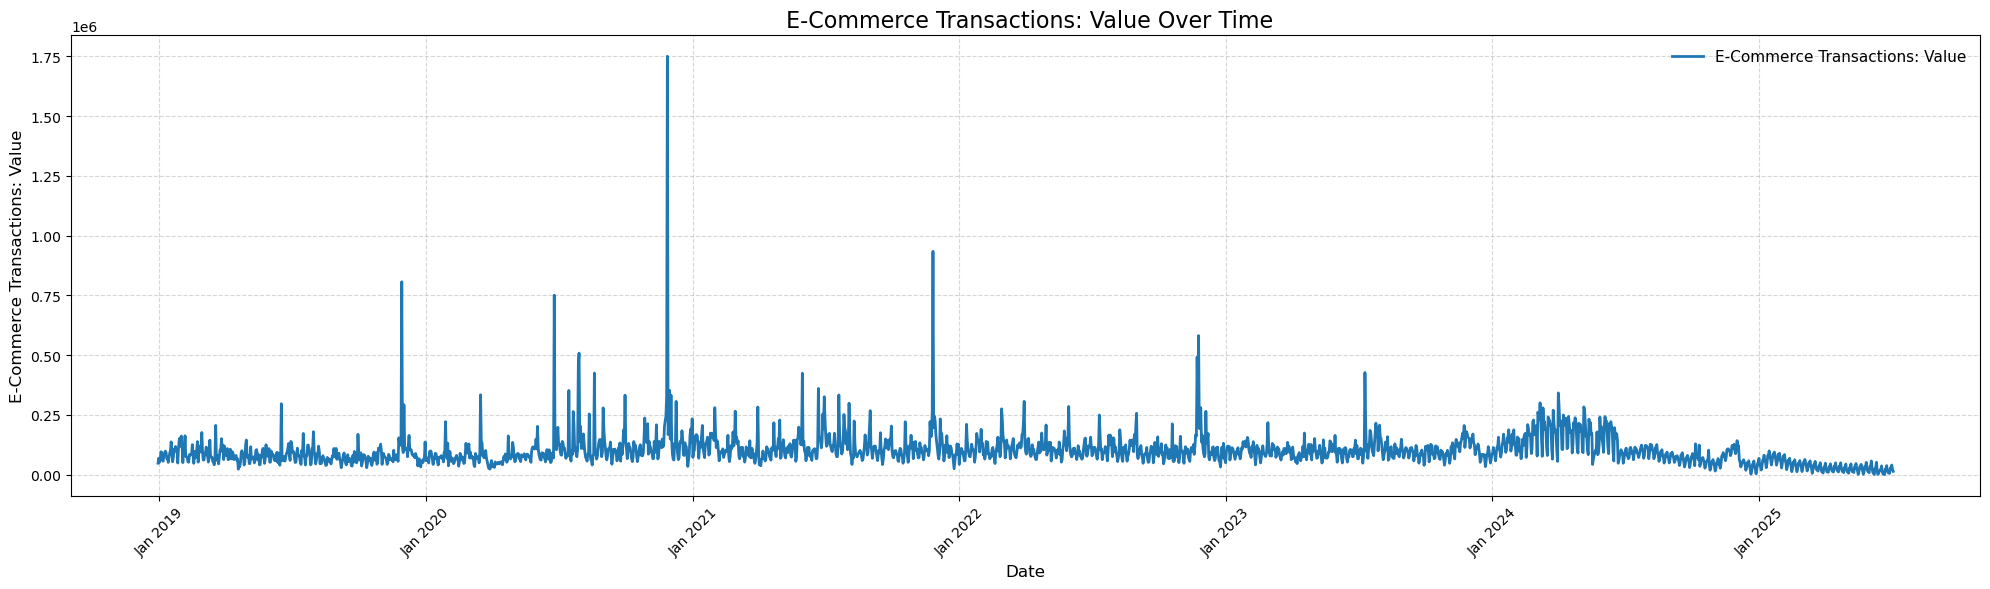

In [14]:
# Plot 
plt.figure(figsize=(20, 6))

plt.plot(df['date'], df['Value'], linewidth=2, label='E-Commerce Transactions: Value')

# Format x-axis 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) 
plt.xticks(rotation=45)
# Styling
plt.title(" E-Commerce Transactions: Value Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("E-Commerce Transactions: Value", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(frameon=False, fontsize=11)
plt.tight_layout()
plt.show()

In [15]:
#Convert Date to datetime, set date as index
df['date'] = pd.to_datetime(df['date'], errors='coerce')  
df = df.sort_values('date')  
df = df.set_index('date')

In [16]:
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Time span: {(df.index.max() - df.index.min()).days} days")

Date range: 2018-12-30 00:00:00 to 2025-07-04 00:00:00
Time span: 2378 days


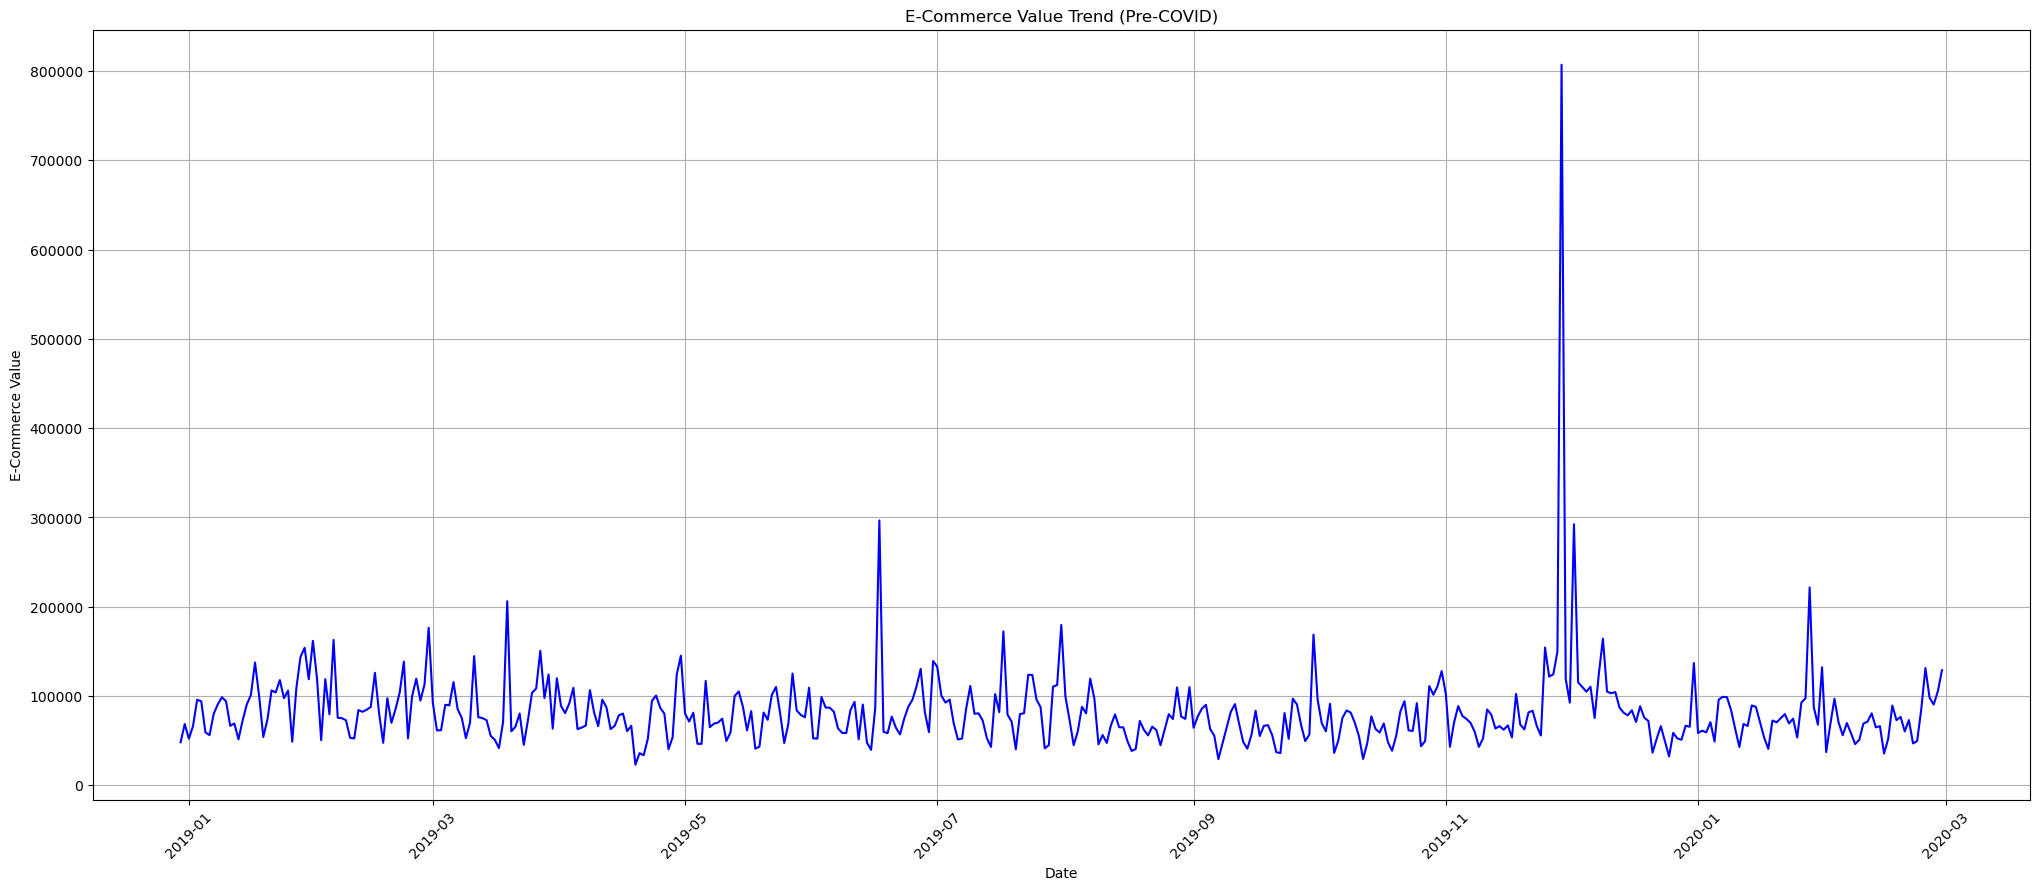

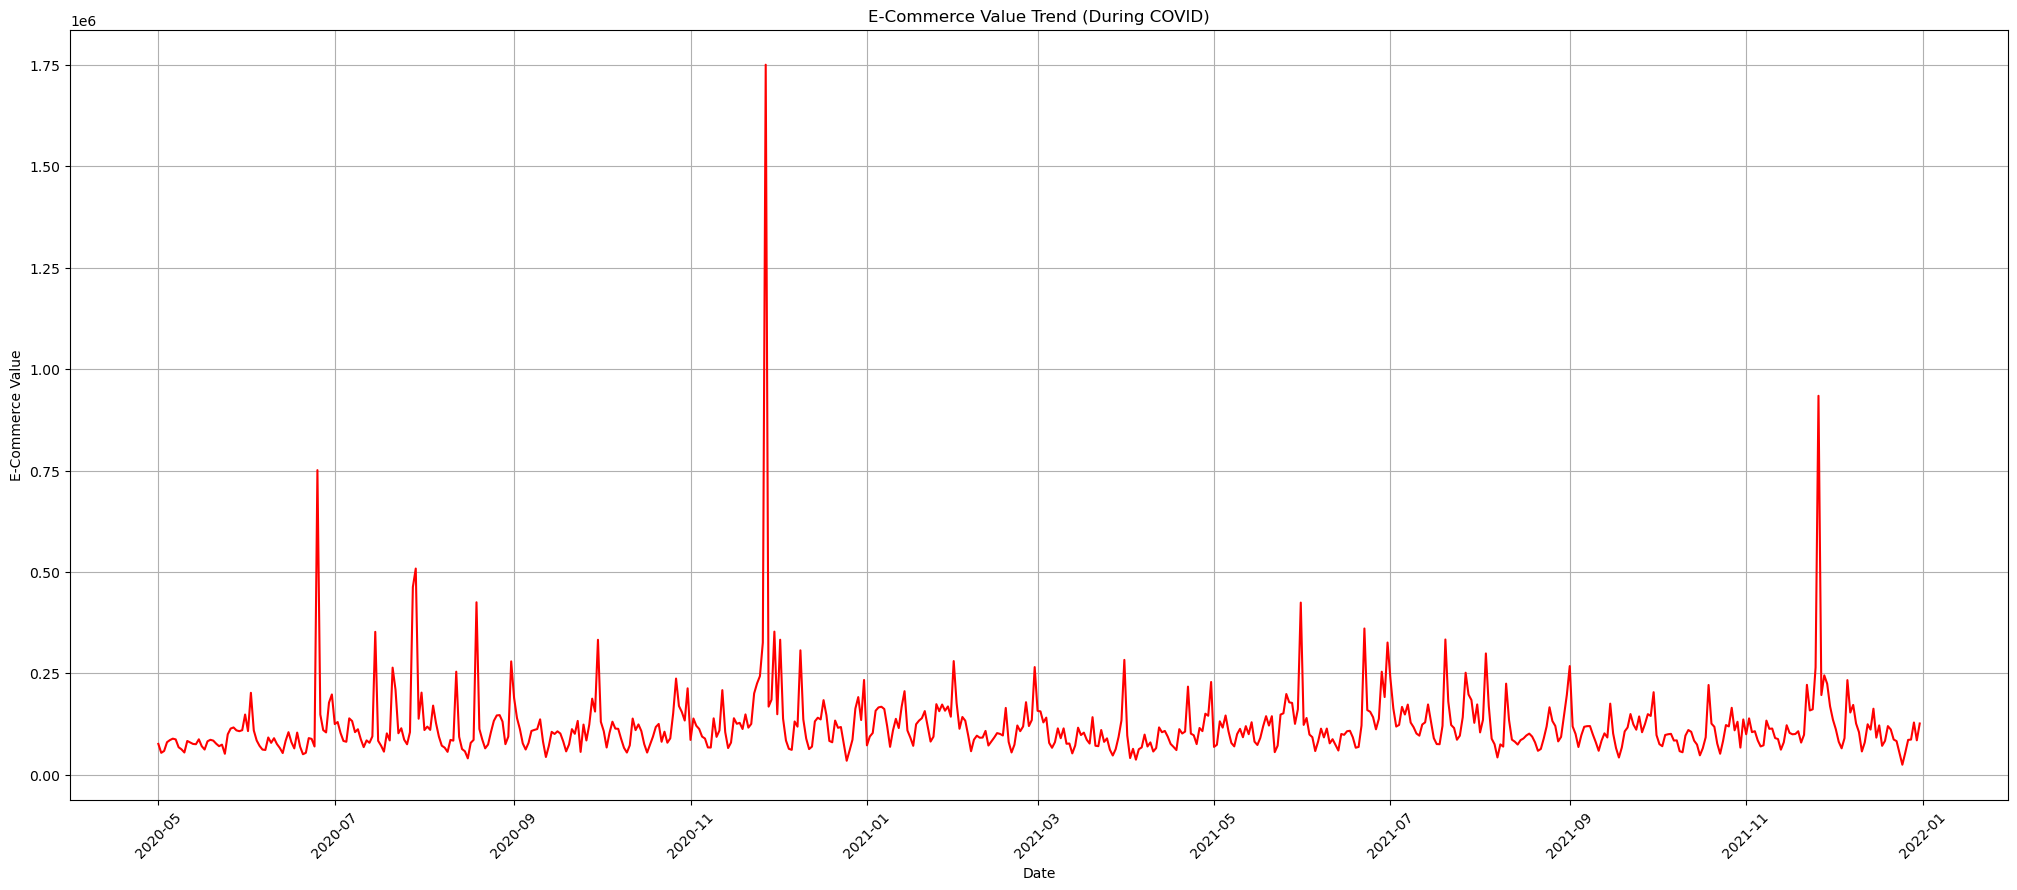

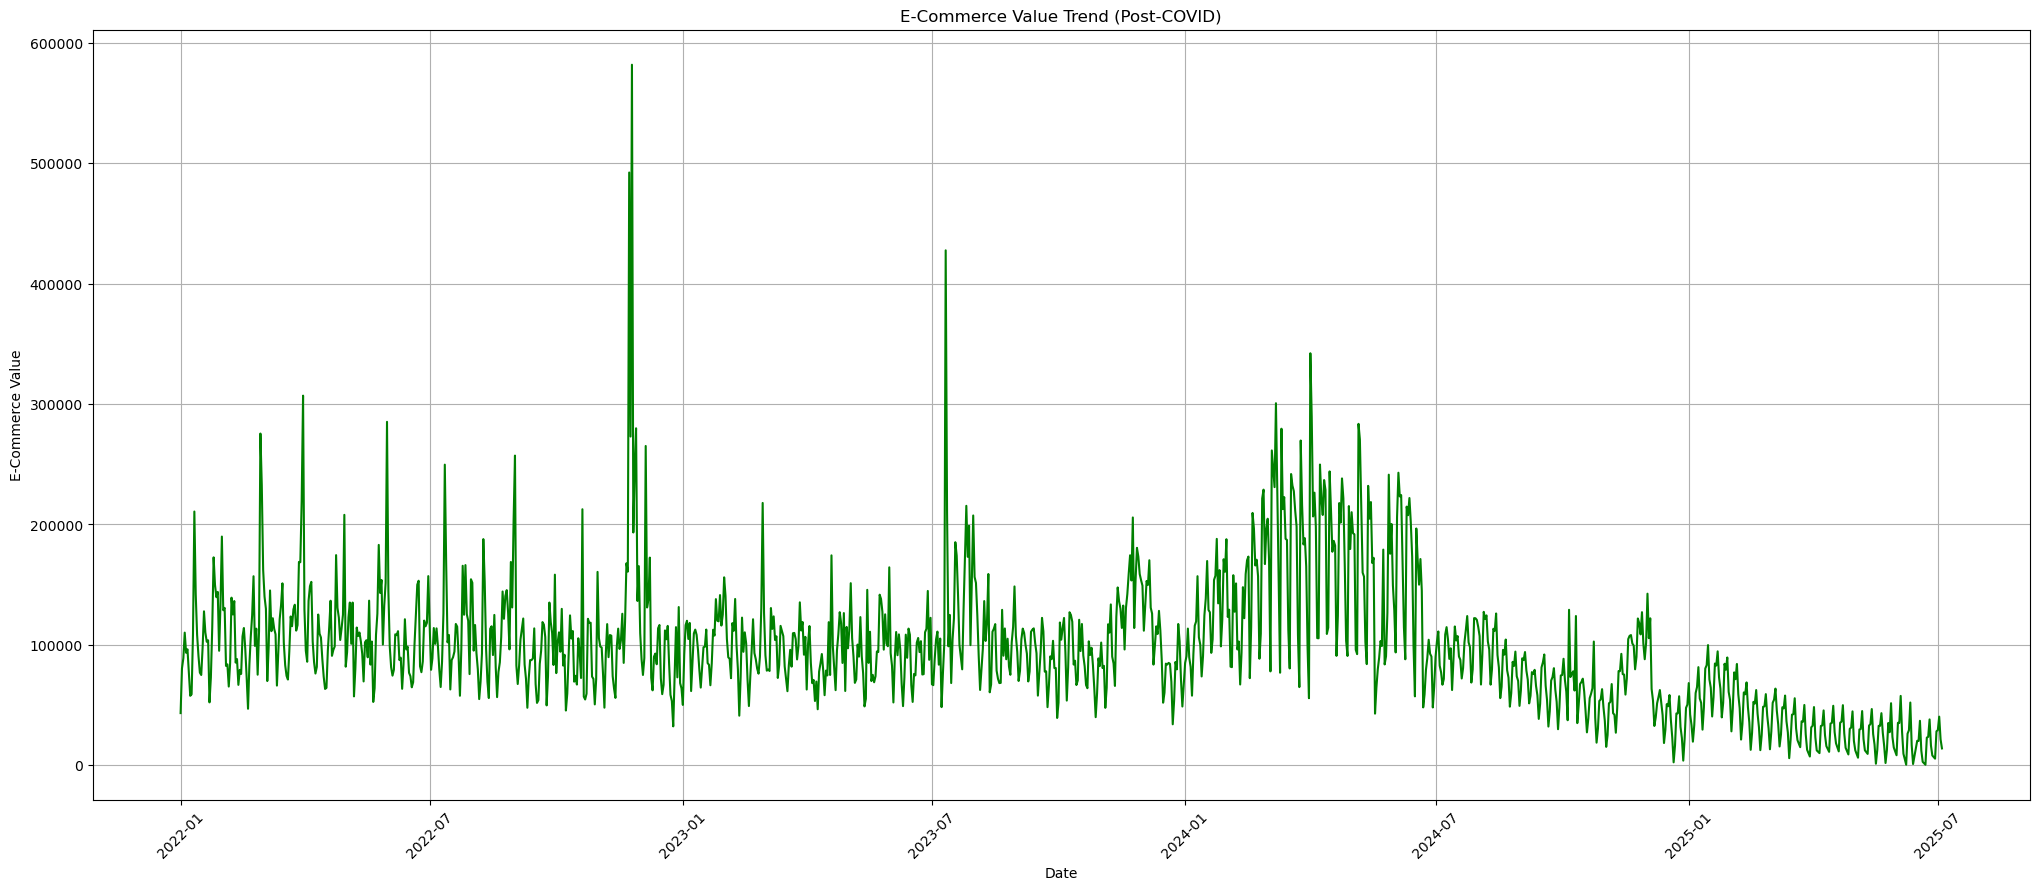

In [17]:
# Define periods
pre_covid_end = '2020-02-29'
covid_start = '2020-05-01'
covid_end = '2021-12-31'
post_covid_start = '2022-01-01'

# Split data using df
data_pre_covid = df[df.index <= pre_covid_end]
data_covid = df[(df.index >= covid_start) & (df.index <= covid_end)]
data_post_covid = df[df.index >= post_covid_start]

# Plot 1: Pre-COVID
plt.figure(figsize=(25,10))
plt.plot(data_pre_covid.index, data_pre_covid['Value'], color='blue')
plt.xlabel('Date')
plt.ylabel('E-Commerce Value')
plt.title('E-Commerce Value Trend (Pre-COVID)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot 2: During COVID
plt.figure(figsize=(25,10))
plt.plot(data_covid.index, data_covid['Value'], color='red')
plt.xlabel('Date')
plt.ylabel('E-Commerce Value')
plt.title('E-Commerce Value Trend (During COVID)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot 3: Post-COVID
plt.figure(figsize=(25,10))
plt.plot(data_post_covid.index, data_post_covid['Value'], color='green')
plt.xlabel('Date')
plt.ylabel('E-Commerce Value')
plt.title('E-Commerce Value Trend (Post-COVID)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


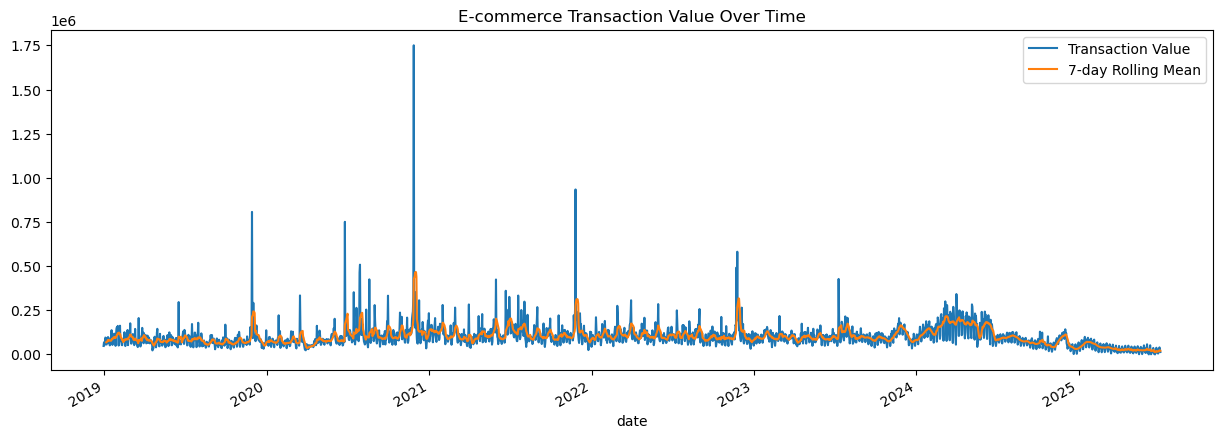

In [18]:
# Plot time series with rolling mean
df['Value'].plot(figsize=(15,5), label='Transaction Value')
df['Value'].rolling(window=7).mean().plot(label='7-day Rolling Mean')
plt.legend()
plt.title('E-commerce Transaction Value Over Time')
plt.show()

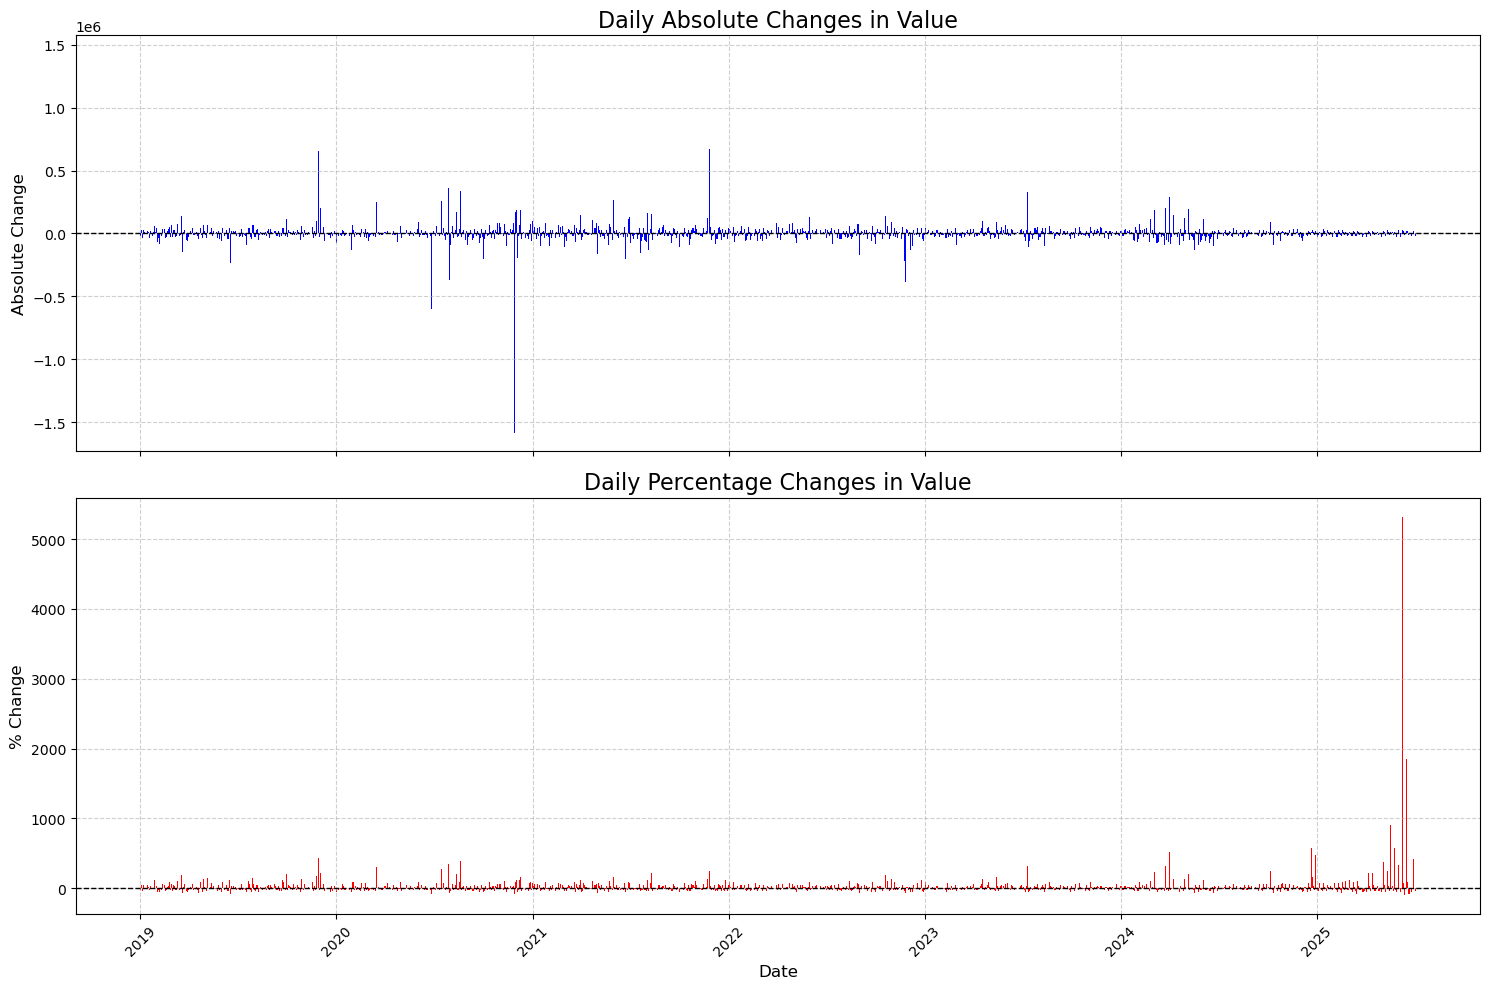

In [ ]:
#-----------------------------------------------
# measuring the day-to-day changes in Value
#------------------------------------------------

# --- Calculate changes ---
df['Daily_Change'] = df['Value'].diff() 


#-----------------------------------------------------------------------------------
# measure how much the Value changes on a percentage basis from one day to the next
#-------------------------------------------------------------------------------------

df['Pct_Change'] = df['Value'].pct_change() * 100  # percentage change

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Absolute Change
axes[0].bar(df.index[1:], df['Daily_Change'].dropna(), color='blue', width=1.0)
axes[0].set_title('Daily Absolute Changes in Value', fontsize=16)
axes[0].set_ylabel('Absolute Change', fontsize=12)
axes[0].axhline(0, color='black', linewidth=1, linestyle='--')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Percentage Change
axes[1].bar(df.index[1:], df['Pct_Change'].dropna(), color='red', width=1.0)
axes[1].set_title('Daily Percentage Changes in Value', fontsize=16)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('% Change', fontsize=12)
axes[1].axhline(0, color='black', linewidth=1, linestyle='--')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


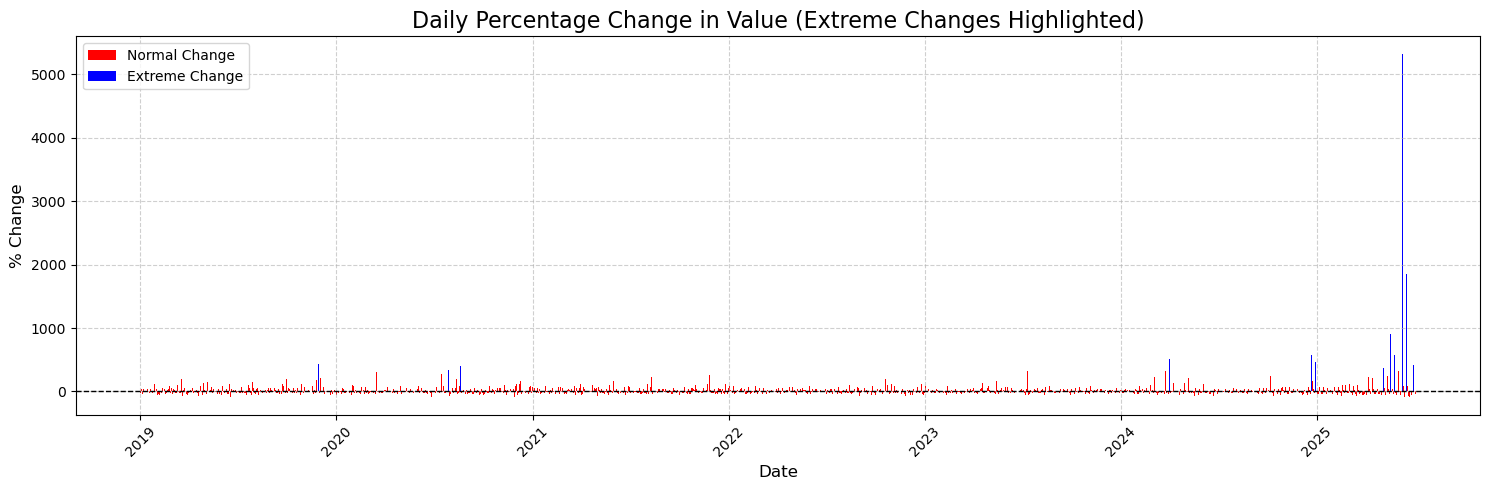

In [20]:

# Drop the first NaN
pct_change = df['Pct_Change'].dropna()
dates = pct_change.index

# Define extreme change threshold (e.g., 2 std devs)
threshold = 2 * pct_change.std()

# Identify extreme changes
extreme_idx = dates[pct_change.abs() > threshold]

# Plot
plt.figure(figsize=(15, 5))

# Normal changes
plt.bar(dates, pct_change.where(pct_change.abs() <= threshold), 
        color='red', width=1.0, label='Normal Change')

# Extreme changes
plt.bar(extreme_idx, pct_change.loc[extreme_idx], 
        color='blue', width=1.0, label='Extreme Change')

# Reference line
plt.axhline(0, color='black', linewidth=1, linestyle='--')

# Titles and labels
plt.title('Daily Percentage Change in Value (Extreme Changes Highlighted)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('% Change', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# Threshold for extreme changes 
threshold = 2 * pct_change.std()

# Identify extreme changes
extreme_idx = pct_change.abs() > threshold

# Extract extreme dates and values
extreme_df = pd.DataFrame({
    'Date': pct_change.index[extreme_idx],
    'Value': df.loc[pct_change.index[extreme_idx], 'Value'],
    'Pct_Change': pct_change[extreme_idx]
})

print(extreme_df)

                 Date         Value   Pct_Change
date                                            
2019-11-29 2019-11-29  8.070306e+05   438.929949
2020-06-25 2020-06-25  7.510073e+05   976.690520
2020-07-28 2020-07-28  4.628446e+05   339.883077
2020-08-19 2020-08-19  4.252546e+05   394.332065
2020-11-27 2020-11-27  1.750459e+06   437.198503
2024-04-01 2024-04-01  3.421037e+05   514.533079
2024-12-22 2024-12-22  1.631551e+04   571.183333
2024-12-29 2024-12-29  2.199859e+04   472.095360
2025-05-05 2025-05-05  2.970663e+04   374.317212
2025-05-18 2025-05-18  1.278112e+04   900.882477
2025-05-25 2025-05-25  1.275538e+04   580.525402
2025-06-09 2025-06-09  2.623162e+04  5323.030567
2025-06-16 2025-06-16  2.029607e+04  1854.421263
2025-06-23 2025-06-23  2.295615e+04  5094.607446
2025-06-30 2025-06-30  2.820558e+04   414.330542


In [22]:
result = adfuller(df['Value'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'   {key}: {value}')

if result[1] <= 0.05:
    print("The time series is stationary")
else:
    print("The time series is non-stationary")

ADF Statistic: -4.351200120168895
p-value: 0.00036176400763231686
   1%: -3.4331512397333626
   5%: -2.8627775348975866
   10%: -2.567428794167024
The time series is stationary


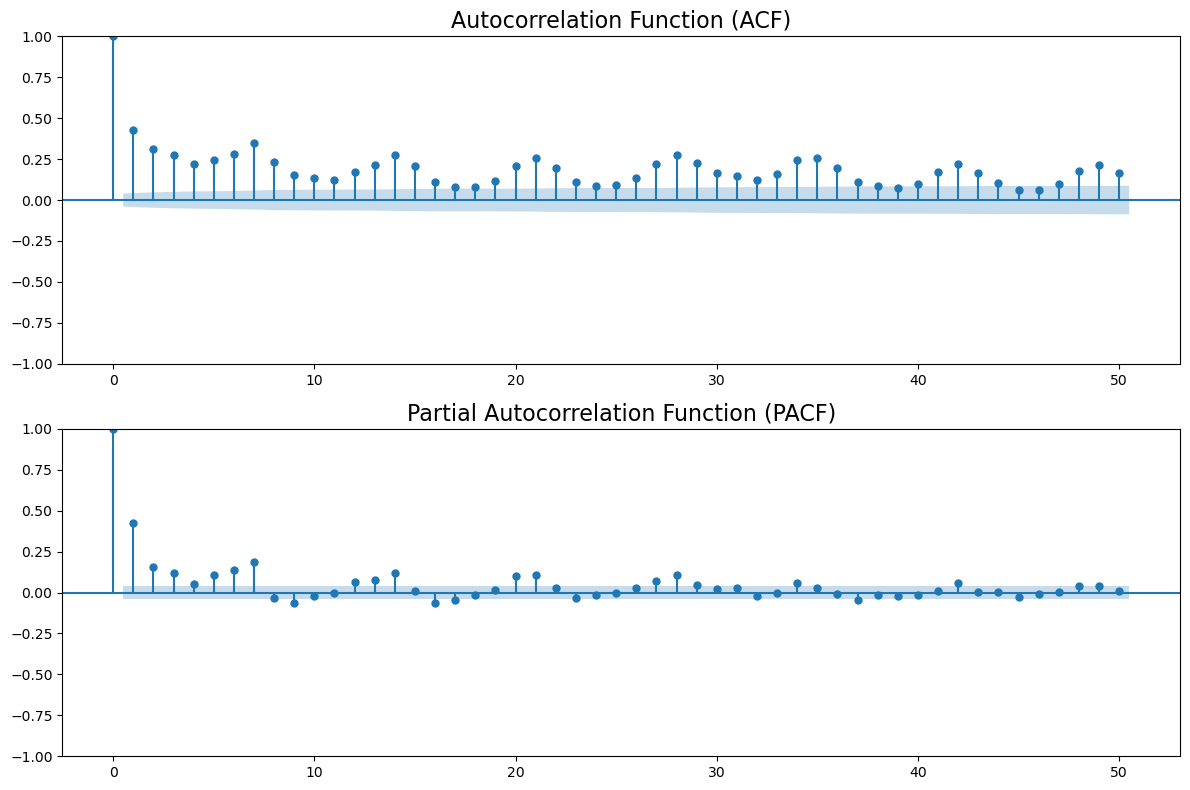

In [23]:
plt.figure(figsize=(12, 8))

# ACF plot
plt.subplot(2, 1, 1)
plot_acf(df['Value'], lags=50, ax=plt.gca(), alpha=0.05)  # alpha=0.05 for 95% CI
plt.title('Autocorrelation Function (ACF)', fontsize=16)

# PACF plot
plt.subplot(2, 1, 2)
plot_pacf(df['Value'], lags=50, ax=plt.gca(), alpha=0.05, method='ywm')  # method='ywm' avoids warnings
plt.title('Partial Autocorrelation Function (PACF)', fontsize=16)

plt.tight_layout()
plt.show()

In [24]:
df.head()

Value  Daily_Change  Pct_Change
date                                              
2018-12-30  48229.459312           NaN         NaN
2018-12-31  68629.143788  20399.684476   42.297145
2019-01-01  52162.890120 -16466.253668  -23.993092
2019-01-02  66311.844346  14148.954226   27.124560
2019-01-03  95740.128026  29428.283680   44.378623

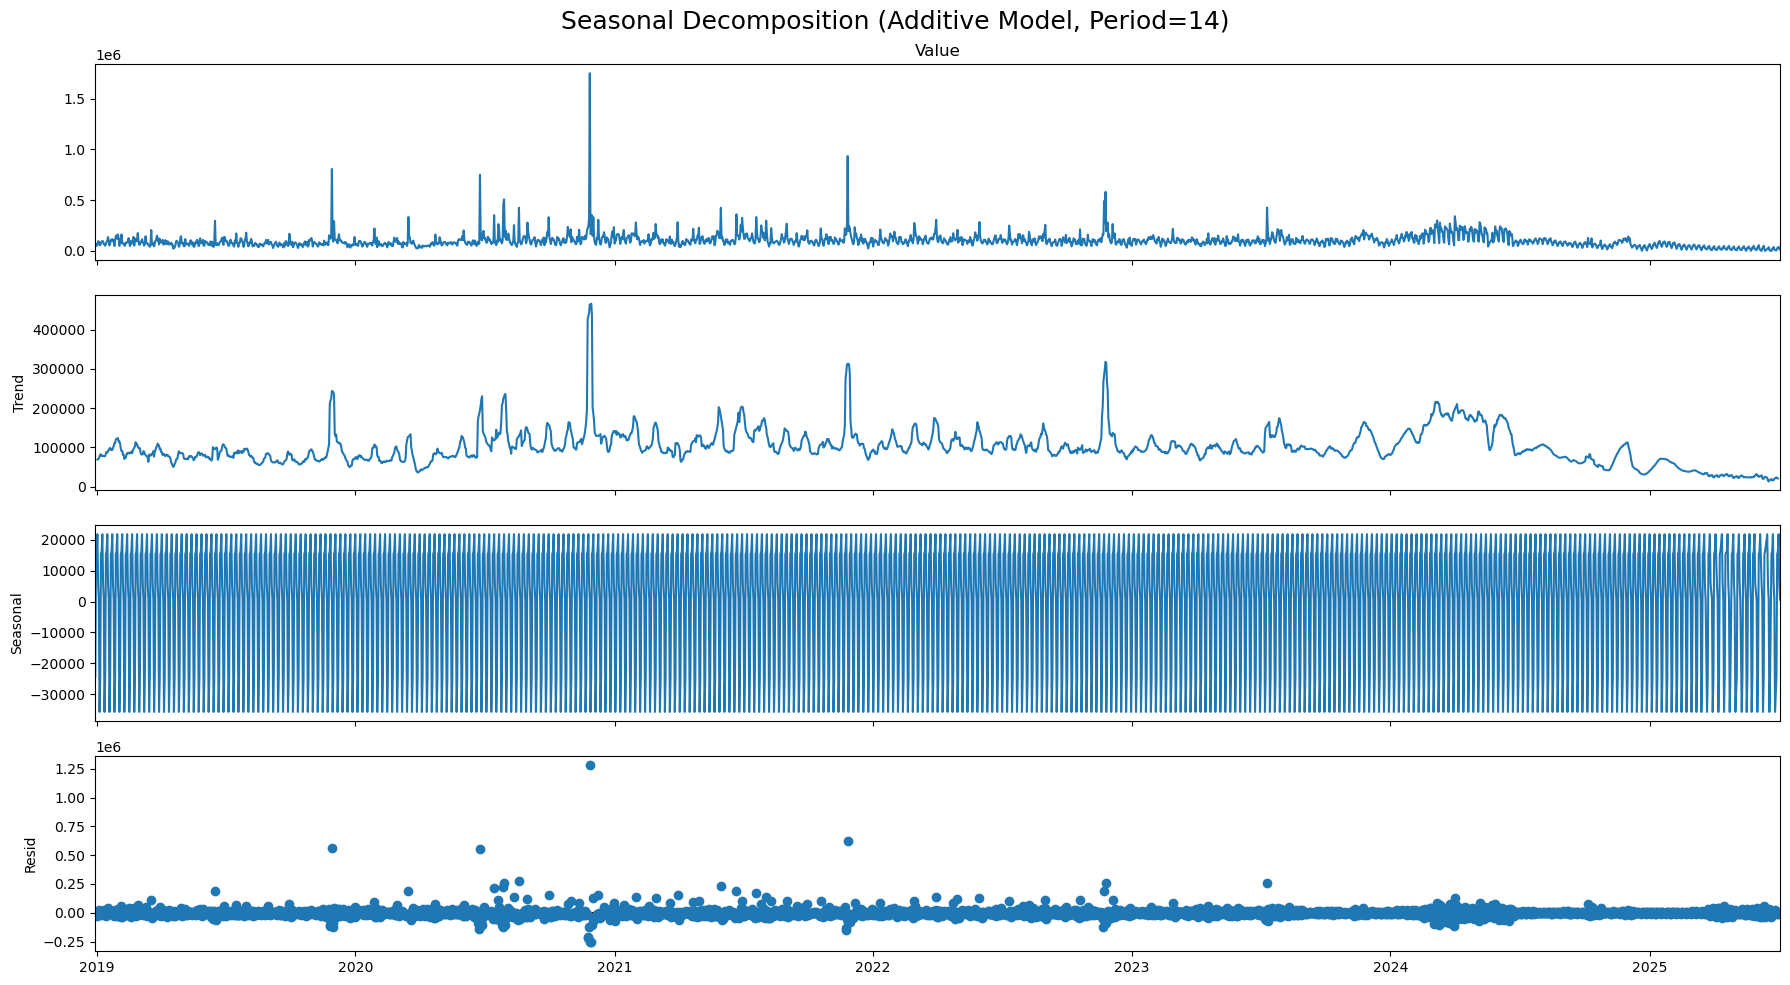

In [25]:
# Seasonal Decomposition for original data
decomp = seasonal_decompose(df['Value'], model='additive', period=7)

# Plot decomposition
fig = decomp.plot()
fig.set_size_inches(18, 10)   # set size directly on figure
fig.suptitle("Seasonal Decomposition (Additive Model, Period=14)", fontsize=18)

plt.tight_layout()
plt.show()

In [26]:
# Drop NaNs from trend to align all components
T = decomp.trend.dropna().values
S = decomp.seasonal[decomp.trend.notna()].values
R = decomp.resid[decomp.trend.notna()].values

# Compute Trend Strength
var_R = np.var(R)
var_T_plus_R = np.var(T + R)
F_T = max(0, 1 - var_R / var_T_plus_R)

# Compute Seasonality Strength
var_S_plus_R = np.var(S + R)
F_S = max(0, 1 - var_R / var_S_plus_R)

print(f"Trend Strength : {F_T:.4f}")
print(f"Seasonality Strength : {F_S:.4f}")

Trend Strength : 0.4921
Seasonality Strength : 0.1572


In [27]:
df.head()

Value  Daily_Change  Pct_Change
date                                              
2018-12-30  48229.459312           NaN         NaN
2018-12-31  68629.143788  20399.684476   42.297145
2019-01-01  52162.890120 -16466.253668  -23.993092
2019-01-02  66311.844346  14148.954226   27.124560
2019-01-03  95740.128026  29428.283680   44.378623

In [28]:
print("\n STATISTICAL ANALYSIS ===")

volatility = df['Value'].std()
mean_value = df['Value'].mean()
cv = (volatility / mean_value) * 100  # Coefficient of variation // how much values deviate from the average.

mad = np.mean(np.abs(df['Value'] - mean_value))

print(f"Volatility (Std Dev): {volatility:.2f}")
print(f"Coefficient of Variation: {cv:.2f}%")
print(f"Mean Absolute Deviation: {mad:.2f}")



 STATISTICAL ANALYSIS ===
Volatility (Std Dev): 68983.06
Coefficient of Variation: 68.15%
Mean Absolute Deviation: 39346.87


In [29]:
# Peak analysis
max_val = df['Value'].max()
min_val = df['Value'].min()
max_date = df['Value'].idxmax()
min_date = df['Value'].idxmin()

print(f"\nPeak Analysis:")
print(f"Maximum Value: {max_val:.2f} on {max_date.strftime('%Y-%m-%d')}")  # Finds maximum value + the date it occurred.
print(f"Minimum Value: {min_val:.2f} on {min_date.strftime('%Y-%m-%d')}")  # Finds minimum value + the date it occurred.
print(f"Range: {max_val - min_val:.2f}")                                    # Range = max - min → gives the spread between peak and trough.




Peak Analysis:
Maximum Value: 1750458.64 on 2020-11-27
Minimum Value: 441.92 on 2025-06-22
Range: 1750016.72


In [30]:
# Calculate performance metrics
total_return = ((df['Value'].iloc[-1] - df['Value'].iloc[0]) / df['Value'].iloc[0]) * 100
# Calculate daily percentage change
avg_daily_return = df['Pct_Change'].mean()

print(f"\nPerformance Metrics:")
print(f"Total Return: {total_return:.2f}%")
print(f"Average Daily Return: {avg_daily_return:.2f}%")


Performance Metrics:
Total Return: -71.02%
Average Daily Return: 15.43%


In [31]:
df.head()

Value  Daily_Change  Pct_Change
date                                              
2018-12-30  48229.459312           NaN         NaN
2018-12-31  68629.143788  20399.684476   42.297145
2019-01-01  52162.890120 -16466.253668  -23.993092
2019-01-02  66311.844346  14148.954226   27.124560
2019-01-03  95740.128026  29428.283680   44.378623

In [32]:
# find the window that captures most of the trend of the actual data  

# Candidate rolling windows in days
windows = [3,7, 14, 30, 60, 90]

# Original trend strength
original_trend_strength =  F_T # ariginal trend strength

print("Rolling Window Trend Strength Comparison:")
for w in windows:
    # Smoothed trend using rolling mean
    smoothed = df['Value'].rolling(window=w, min_periods=1).mean()
    
    # Trend strength = 1 - (variance of detrended series / variance of original series)
    residual_var = ((df['Value'] - smoothed)**2).mean()
    trend_strength = 1 - residual_var / df['Value'].var()
    
    print(f"Window {w}: Trend Strength = {trend_strength:.4f}, Difference from Original = {abs(trend_strength - original_trend_strength):.4f}")


Rolling Window Trend Strength Comparison:
Window 3: Trend Strength = 0.5672, Difference from Original = 0.0751
Window 7: Trend Strength = 0.3753, Difference from Original = 0.1168
Window 14: Trend Strength = 0.2662, Difference from Original = 0.2259
Window 30: Trend Strength = 0.2106, Difference from Original = 0.2815
Window 60: Trend Strength = 0.1769, Difference from Original = 0.3152
Window 90: Trend Strength = 0.1484, Difference from Original = 0.3437


In [33]:
print("\n PATTERN SUMMARY ")

values = df['Value'].values

patterns_detected = []

# V-shaped patterns (any 3-day window)
v_count = 0
for i in range(len(values)-2):
    if values[i] > values[i+1] < values[i+2]:
        v_count += 1
patterns_detected.append(("V-shaped recovery", v_count))

# Consistent trends
if all(values[i] < values[i+1] for i in range(len(values)-1)):
    patterns_detected.append(("Consistent upward trend", 1))
elif all(values[i] > values[i+1] for i in range(len(values)-1)):
    patterns_detected.append(("Consistent downward trend", 1))

# High volatility
high_vol = max(values) - min(values) > mean_value * 0.1
patterns_detected.append(("High volatility", int(high_vol)))

# Print summary
print(" Detected Patterns Summary:")
for pattern, count in patterns_detected:
    if count > 0:
        print(f"- {pattern}: {count} occurrence(s)")



 PATTERN SUMMARY 
 Detected Patterns Summary:
- V-shaped recovery: 624 occurrence(s)
- High volatility: 1 occurrence(s)


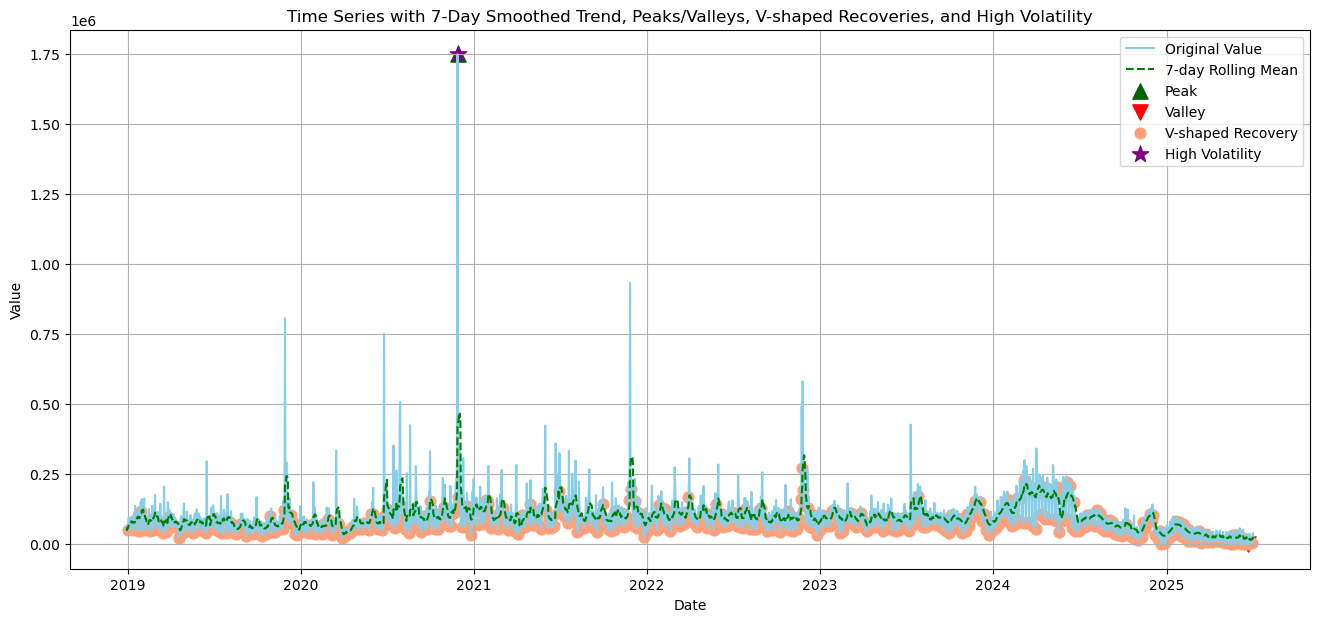

In [34]:
# --- Smoothed trend ---
rolling_window = 7
smoothed_trend = df['Value'].rolling(window=rolling_window, min_periods=1).mean()

# --- Peaks and valleys ---
max_val = df['Value'].max()
min_val = df['Value'].min()
max_date = df['Value'].idxmax()
min_date = df['Value'].idxmin()

# --- V-shaped recoveries ---
v_indices = [i+1 for i in range(len(df)-2) if df['Value'].iloc[i] > df['Value'].iloc[i+1] < df['Value'].iloc[i+2]]
v_values = df['Value'].iloc[v_indices]

# --- High volatility ---
vol_point = df['Value'].idxmax() if (max_val - min_val) > df['Value'].mean() * 0.1 else None

# --- Plot ---
plt.figure(figsize=(16,7))
plt.plot(df.index, df['Value'], label='Original Value', color='skyblue')
plt.plot(df.index, smoothed_trend, label=f'7-day Rolling Mean', color='green', linestyle='--')
plt.scatter(max_date, max_val, color='darkgreen', marker='^', s=120, label='Peak')
plt.scatter(min_date, min_val, color='red', marker='v', s=120, label='Valley')
plt.scatter(df.index[v_indices], v_values, color='#FFA07A', marker='o', s=60, label='V-shaped Recovery')

# Corrected high volatility scatter
if vol_point:
    plt.scatter([vol_point], [df.loc[vol_point, 'Value']], color='purple', marker='*', s=150, label='High Volatility')

plt.title('Time Series with 7-Day Smoothed Trend, Peaks/Valleys, V-shaped Recoveries, and High Volatility')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()


In [35]:
# Check distribution after capping
print(f"Skewness of value: {df['Value'].skew():.4f}")


Skewness of value: 8.3232


 # Google Trends

In [36]:
data.head()

date  Avon  Property24  We Buy Cars  Game  Telkom  Cars for Sale  \
0  2018-12-30    34          23            7    11      61             25   
1  2018-12-31    29          22            5    13      72             20   
2  2019-01-01    39          30            9    13      58             27   
3  2019-01-02    42          31           11    13      81             30   
4  2019-01-03    45          34           13    12      71             27   

   computer  AutoTrader  clothing  Puma  Betfred  MTN  
0        13          17        63    19        0   29  
1        11          15        53    16        0   32  
2        12          20        50    12        0   29  
3        14          22        58     9        0   42  
4        17          23        53    10        0   35

In [37]:
data.shape 

(2365, 13)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           2365 non-null   object
 1   Avon           2365 non-null   int64 
 2   Property24     2365 non-null   int64 
 3   We Buy Cars    2365 non-null   int64 
 4   Game           2365 non-null   int64 
 5   Telkom         2365 non-null   int64 
 6   Cars for Sale  2365 non-null   int64 
 7   computer       2365 non-null   int64 
 8   AutoTrader     2365 non-null   int64 
 9   clothing       2365 non-null   int64 
 10  Puma           2365 non-null   int64 
 11  Betfred        2365 non-null   int64 
 12  MTN            2365 non-null   int64 
dtypes: int64(12), object(1)
memory usage: 240.3+ KB


In [39]:
data.describe()

Avon   Property24  We Buy Cars         Game       Telkom  \
count  2365.000000  2365.000000  2365.000000  2365.000000  2365.000000   
mean     25.906131    35.380973    34.324736    15.279915    38.791121   
std      15.633644    20.808832    12.762151     5.164334    18.039002   
min       0.000000     6.000000     5.000000     6.000000    11.000000   
25%      16.000000    17.000000    24.000000    12.000000    23.000000   
50%      22.000000    30.000000    37.000000    14.000000    34.000000   
75%      33.000000    53.000000    45.000000    18.000000    53.000000   
max     100.000000   100.000000    63.000000    65.000000   100.000000   

       Cars for Sale     computer   AutoTrader     clothing         Puma  \
count    2365.000000  2365.000000  2365.000000  2365.000000  2365.000000   
mean       20.467230    16.154757    27.659197    50.414799    14.994926   
std         5.034681     6.177279     5.241999    17.429555     5.495958   
min        10.000000     2.000000    11.000000    16.000000     4.000000   
25%        16.000000    12.000000    25.000000    36.000000    11.000000   
50%        20.000000    16.000000    28.000000    46.000000    14.000000   
75%        24.000000    20.000000    31.000000    63.000000    18.000000   
max        36.000000    36.000000    44.000000   100.000000    36.000000   

           Betfred          MTN  
count  2365.000000  2365.000000  
mean      2.264271    31.047780  
std       3.184793    11.686826  
min       0.000000    13.000000  
25%       0.000000    21.000000  
50%       0.000000    30.000000  
75%       5.000000    40.000000  
max      12.000000   100.000000

In [40]:
data.columns

Index(['date', 'Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom',
       'Cars for Sale', 'computer', 'AutoTrader', 'clothing', 'Puma',
       'Betfred', 'MTN'],
      dtype='object')

In [41]:
# set data date as index
data.set_index('date', inplace=True)

In [42]:
'''
# List of numerical Google Trends features
features = data.columns.tolist()

# Define periods
pre_covid_end = '2020-02-29'
covid_start = '2020-03-01'
covid_end = '2021-12-31'
post_covid_start = '2022-01-01'

# Split data using index
data_pre_covid = data[data.index <= pre_covid_end]
data_covid = data[(data.index >= covid_start) & (data.index <= covid_end)]
data_post_covid = data[data.index >= post_covid_start]

# Loop through features and plot
for feature in features:
    plt.figure(figsize=(20,6))
    plt.plot(data_pre_covid.index, data_pre_covid[feature], label='Pre-COVID', color='blue')
    plt.plot(data_covid.index, data_covid[feature], label='During COVID', color='red')
    plt.plot(data_post_covid.index, data_post_covid[feature], label='Post-COVID', color='green')
    
    plt.xlabel('Date')
    plt.ylabel(f'{feature} Trend Value')
    plt.title(f'{feature} Google Trend Across COVID Periods')
    plt.legend()
    
    # Show ticks every ~20 points for readability
    plt.xticks(data.index[::max(1, len(data)//20)], rotation=45)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()
'''

"\n# List of numerical Google Trends features\nfeatures = data.columns.tolist()\n\n# Define periods\npre_covid_end = '2020-02-29'\ncovid_start = '2020-03-01'\ncovid_end = '2021-12-31'\npost_covid_start = '2022-01-01'\n\n# Split data using index\ndata_pre_covid = data[data.index <= pre_covid_end]\ndata_covid = data[(data.index >= covid_start) & (data.index <= covid_end)]\ndata_post_covid = data[data.index >= post_covid_start]\n\n# Loop through features and plot\nfor feature in features:\n    plt.figure(figsize=(20,6))\n    plt.plot(data_pre_covid.index, data_pre_covid[feature], label='Pre-COVID', color='blue')\n    plt.plot(data_covid.index, data_covid[feature], label='During COVID', color='red')\n    plt.plot(data_post_covid.index, data_post_covid[feature], label='Post-COVID', color='green')\n\n    plt.xlabel('Date')\n    plt.ylabel(f'{feature} Trend Value')\n    plt.title(f'{feature} Google Trend Across COVID Periods')\n    plt.legend()\n\n    # Show ticks every ~20 points for readabi

In [43]:
data.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'Cars for Sale',
       'computer', 'AutoTrader', 'clothing', 'Puma', 'Betfred', 'MTN'],
      dtype='object')

# Merge the data

In [44]:
data.head()

Avon  Property24  We Buy Cars  Game  Telkom  Cars for Sale  \
date                                                                     
2018-12-30    34          23            7    11      61             25   
2018-12-31    29          22            5    13      72             20   
2019-01-01    39          30            9    13      58             27   
2019-01-02    42          31           11    13      81             30   
2019-01-03    45          34           13    12      71             27   

            computer  AutoTrader  clothing  Puma  Betfred  MTN  
date                                                            
2018-12-30        13          17        63    19        0   29  
2018-12-31        11          15        53    16        0   32  
2019-01-01        12          20        50    12        0   29  
2019-01-02        14          22        58     9        0   42  
2019-01-03        17          23        53    10        0   35

In [45]:
df.head()

Value  Daily_Change  Pct_Change
date                                              
2018-12-30  48229.459312           NaN         NaN
2018-12-31  68629.143788  20399.684476   42.297145
2019-01-01  52162.890120 -16466.253668  -23.993092
2019-01-02  66311.844346  14148.954226   27.124560
2019-01-03  95740.128026  29428.283680   44.378623

In [46]:
print(' Shape of the value data',df.shape)

 Shape of the value data (2365, 3)


In [47]:
# drop Daily_Change	and Pct_Change column

df = df.drop(columns=['Daily_Change', 'Pct_Change'])
df.head()

Value
date                    
2018-12-30  48229.459312
2018-12-31  68629.143788
2019-01-01  52162.890120
2019-01-02  66311.844346
2019-01-03  95740.128026

In [48]:
print ('The shape of google trends data',data.shape)

The shape of google trends data (2365, 12)


In [49]:
# Ensure both indices are datetime and sorted
data.index = pd.to_datetime(data.index)
df.index = pd.to_datetime(df.index)


data = data.sort_index()
df = df.sort_index()

# Align indices: keep only overlapping dates (inner join)
merged_df = data.join(df, how='inner', lsuffix='_data', rsuffix='_df')

# Check alignment
print(f"Data index start: {data.index.min()}, end: {data.index.max()}")
print(f"DF index start: {df.index.min()}, end: {df.index.max()}")
print(f"Merged index start: {merged_df.index.min()}, end: {merged_df.index.max()}")

merged_df.head()


Data index start: 2018-12-30 00:00:00, end: 2025-06-20 00:00:00
DF index start: 2018-12-30 00:00:00, end: 2025-07-04 00:00:00
Merged index start: 2018-12-30 00:00:00, end: 2025-06-20 00:00:00


Avon  Property24  We Buy Cars  Game  Telkom  Cars for Sale  \
date                                                                     
2018-12-30    34          23            7    11      61             25   
2018-12-31    29          22            5    13      72             20   
2019-01-01    39          30            9    13      58             27   
2019-01-02    42          31           11    13      81             30   
2019-01-03    45          34           13    12      71             27   

            computer  AutoTrader  clothing  Puma  Betfred  MTN         Value  
date                                                                          
2018-12-30        13          17        63    19        0   29  48229.459312  
2018-12-31        11          15        53    16        0   32  68629.143788  
2019-01-01        12          20        50    12        0   29  52162.890120  
2019-01-02        14          22        58     9        0   42  66311.844346  
2019-01-03        17          23        53    10        0   35  95740.128026

In [50]:
print(' shape of the merged data ',merged_df.shape)

 shape of the merged data  (2353, 13)


In [51]:
def check_stationarity(series, signif=0.05):
    result = adfuller(series.dropna())
    p_value = result[1]
    return p_value < signif  # True if stationary


stationary_cols = []
nonstationary_cols = []

for col in merged_df.columns:
    if merged_df[col].dtype in ['float64','int64']:
        if check_stationarity(merged_df[col]):
            stationary_cols.append(col)
        else:
            nonstationary_cols.append(col)

print("Stationary columns:", stationary_cols)
print("Non-stationary columns:", nonstationary_cols)


Stationary columns: ['clothing', 'Puma', 'MTN', 'Value']
Non-stationary columns: ['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'Cars for Sale', 'computer', 'AutoTrader', 'Betfred']


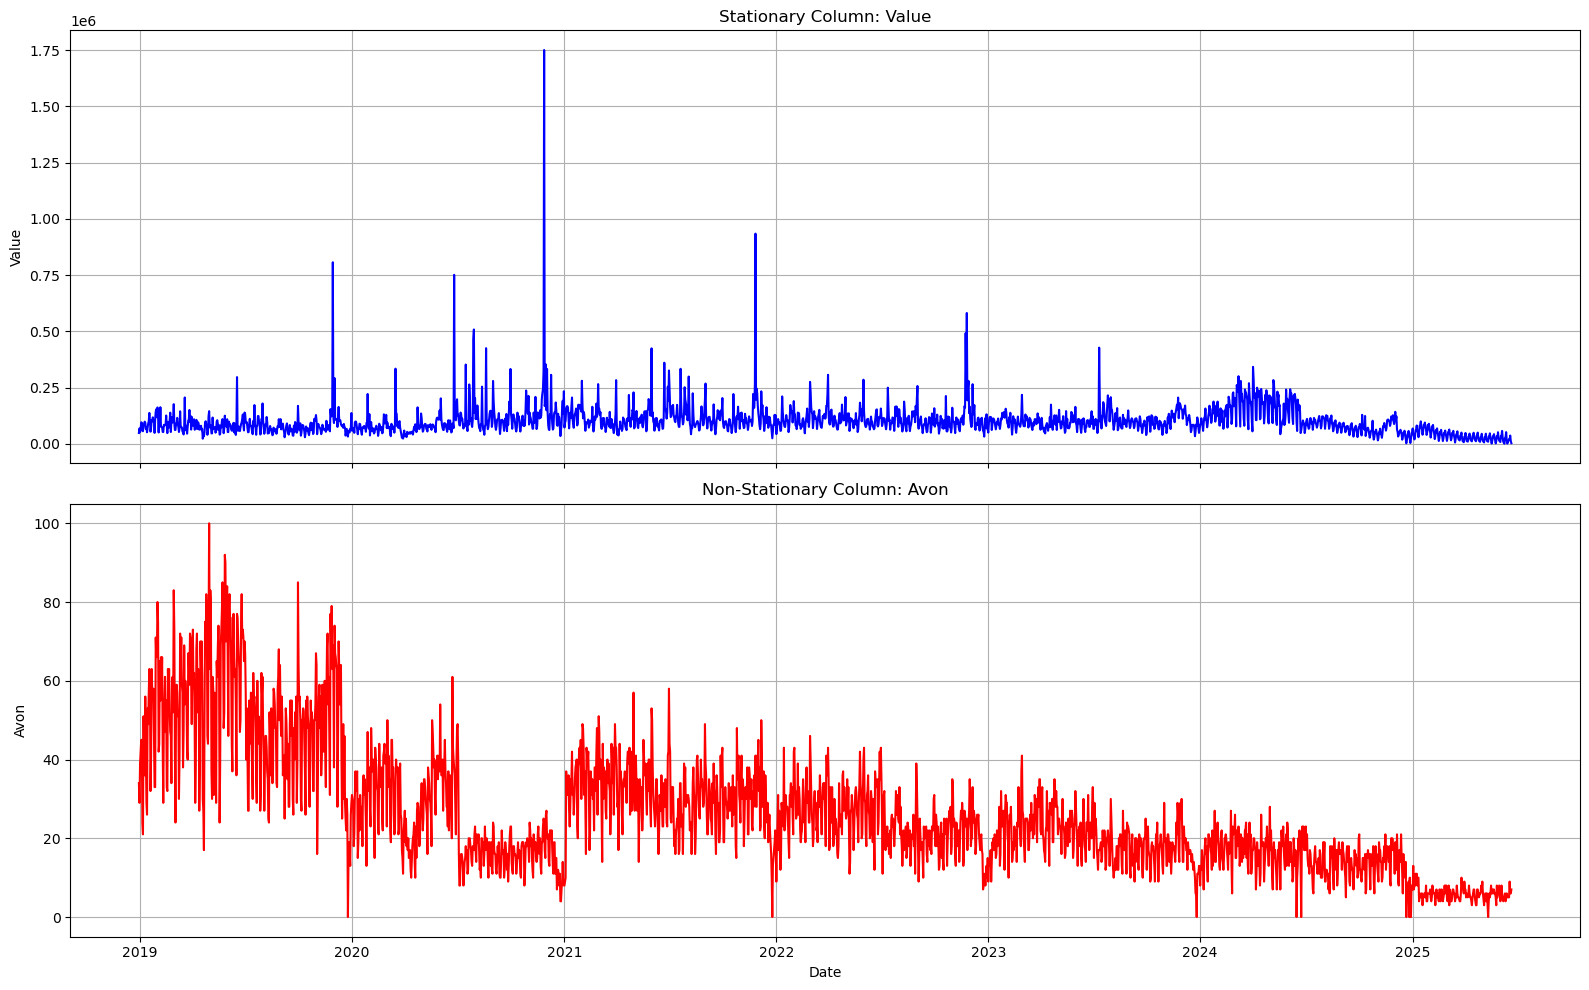

In [52]:
stationary_col = 'Value'
non_stationary_col = 'Avon'

fig, axes = plt.subplots(2, 1, figsize=(16,10), sharex=True)

# Plot stationary column
axes[0].plot(merged_df.index, merged_df[stationary_col], color='blue')
axes[0].set_title(f'Stationary Column: {stationary_col}')
axes[0].set_ylabel(stationary_col)
axes[0].grid(True)

# Plot non-stationary column
axes[1].plot(merged_df.index, merged_df[non_stationary_col], color='red')
axes[1].set_title(f'Non-Stationary Column: {non_stationary_col}')
axes[1].set_xlabel('Date')
axes[1].set_ylabel(non_stationary_col)
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [53]:
trend_strength = {}
seasonality_strength = {}

for col in merged_df.columns:
    series = merged_df[col].dropna()
    
    # Decompose with additive model; adjust period as needed
    decomp = seasonal_decompose(series, model='additive', period=7, extrapolate_trend='freq')
    
    # Align components
    T = decomp.trend.dropna().values
    S = decomp.seasonal[decomp.trend.notna()].values
    R = decomp.resid[decomp.trend.notna()].values
    
    # Trend Strength
    var_R = np.var(R)
    var_T_plus_R = np.var(T + R)
    F_T = max(0, 1 - var_R / var_T_plus_R)
    
    # Seasonality Strength
    var_S_plus_R = np.var(S + R)
    F_S = max(0, 1 - var_R / var_S_plus_R)
    
    trend_strength[col] = F_T
    seasonality_strength[col] = F_S

# Combine into a DataFrame
strength_df = pd.DataFrame({
    'Series': list(trend_strength.keys()),
    'Trend_Strength': list(trend_strength.values()),
    'Seasonality_Strength': list(seasonality_strength.values())
}).sort_values(by='Trend_Strength', ascending=False)

print(strength_df)


           Series  Trend_Strength  Seasonality_Strength
10        Betfred        0.981384              0.035397
1      Property24        0.974456              0.309670
2     We Buy Cars        0.963810              0.151232
8        clothing        0.955074              0.099137
4          Telkom        0.947660              0.388212
0            Avon        0.888143              0.453969
9            Puma        0.882199              0.242108
5   Cars for Sale        0.878187              0.102393
7      AutoTrader        0.839088              0.030528
6        computer        0.824881              0.420829
3            Game        0.785613              0.348625
11            MTN        0.755783              0.042129
12          Value        0.489228              0.157305


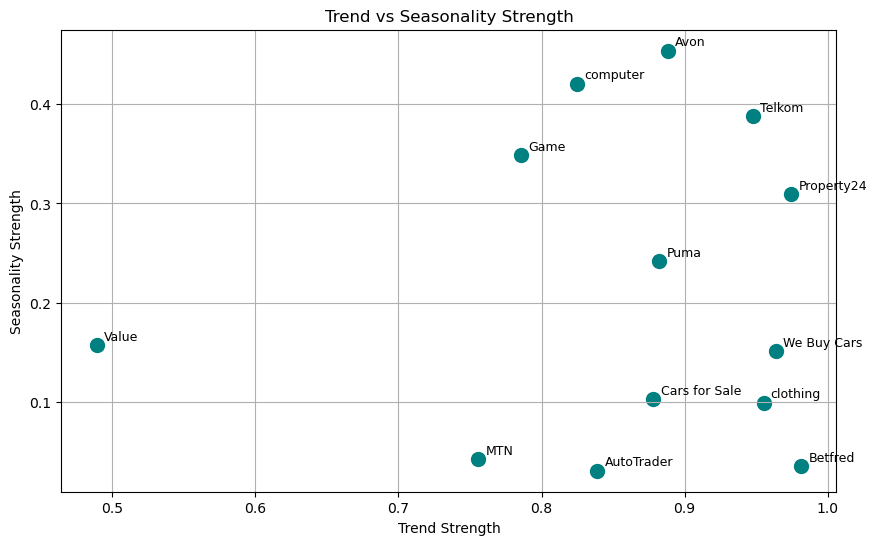

In [54]:
# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(strength_df['Trend_Strength'], strength_df['Seasonality_Strength'], color='teal', s=100)

# Annotate each point
for i, row in strength_df.iterrows():
    plt.text(row['Trend_Strength']+0.005, row['Seasonality_Strength']+0.005, row['Series'], fontsize=9)

plt.xlabel('Trend Strength')
plt.ylabel('Seasonality Strength')
plt.title('Trend vs Seasonality Strength')
plt.grid(True)
plt.show()

In [55]:
# Make a copy to avoid overwriting accidentally
merge_df_transformed = merged_df.copy()

In [56]:
merge_df_transformed.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'Cars for Sale',
       'computer', 'AutoTrader', 'clothing', 'Puma', 'Betfred', 'MTN',
       'Value'],
      dtype='object')

In [57]:
merge_df_transformed.head()

Avon  Property24  We Buy Cars  Game  Telkom  Cars for Sale  \
date                                                                     
2018-12-30    34          23            7    11      61             25   
2018-12-31    29          22            5    13      72             20   
2019-01-01    39          30            9    13      58             27   
2019-01-02    42          31           11    13      81             30   
2019-01-03    45          34           13    12      71             27   

            computer  AutoTrader  clothing  Puma  Betfred  MTN         Value  
date                                                                          
2018-12-30        13          17        63    19        0   29  48229.459312  
2018-12-31        11          15        53    16        0   32  68629.143788  
2019-01-01        12          20        50    12        0   29  52162.890120  
2019-01-02        14          22        58     9        0   42  66311.844346  
2019-01-03        17          23        53    10        0   35  95740.128026

In [58]:
merge_df_transformed.head()

Avon  Property24  We Buy Cars  Game  Telkom  Cars for Sale  \
date                                                                     
2018-12-30    34          23            7    11      61             25   
2018-12-31    29          22            5    13      72             20   
2019-01-01    39          30            9    13      58             27   
2019-01-02    42          31           11    13      81             30   
2019-01-03    45          34           13    12      71             27   

            computer  AutoTrader  clothing  Puma  Betfred  MTN         Value  
date                                                                          
2018-12-30        13          17        63    19        0   29  48229.459312  
2018-12-31        11          15        53    16        0   32  68629.143788  
2019-01-01        12          20        50    12        0   29  52162.890120  
2019-01-02        14          22        58     9        0   42  66311.844346  
2019-01-03        17          23        53    10        0   35  95740.128026

In [59]:
merge_df_transformed.shape

(2353, 13)

In [60]:
def add_lags(df, col, n_lags=2, use_capped=True):
    """
    Adds lag features to a column and drops resulting NaNs.
    
    Args:
        df: input DataFrame
        col: column to lag
        n_lags: number of lags
        use_capped: whether to use capped column (col_capped) if available
    """
    df_copy = df.copy()
    base_col = f"{col}_capped" if use_capped and f"{col}_capped" in df_copy.columns else col
    
    for lag in range(1, n_lags+1):
        df_copy[f'{col}_lag{lag}'] = df_copy[base_col].shift(lag)
    
    # Drop rows with NaN values caused by lagging
    df_copy.dropna(inplace=True)
    
    return df_copy

# Apply function using capped Value
merge_df_transformed = add_lags(merge_df_transformed, 'Value', n_lags=2, use_capped=True)

# Check result
merge_df_transformed.head()


Avon  Property24  We Buy Cars  Game  Telkom  Cars for Sale  \
date                                                                     
2019-01-01    39          30            9    13      58             27   
2019-01-02    42          31           11    13      81             30   
2019-01-03    45          34           13    12      71             27   
2019-01-04    45          35           12    11      66             28   
2019-01-05    24          32           11    11      60             29   

            computer  AutoTrader  clothing  Puma  Betfred  MTN         Value  \
date                                                                           
2019-01-01        12          20        50    12        0   29  52162.890120   
2019-01-02        14          22        58     9        0   42  66311.844346   
2019-01-03        17          23        53    10        0   35  95740.128026   
2019-01-04        21          21        52    10        0   35  94094.655988   
2019-01-05        15          21        45    15        0   27  59335.755374   

              Value_lag1    Value_lag2  
date                                    
2019-01-01  68629.143788  48229.459312  
2019-01-02  52162.890120  68629.143788  
2019-01-03  66311.844346  52162.890120  
2019-01-04  95740.128026  66311.844346  
2019-01-05  94094.655988  95740.128026

In [61]:
merge_df_transformed.shape

(2351, 15)

# Spliting data

In [62]:
# --- Lagged and cleaned dataframe ---
target = 'Value'
features = [col for col in merge_df_transformed.columns if col != target]

# --- Chronological splits ---
train_size = int(len(merge_df_transformed) * 0.8)  # 80% train
test_size  = len(merge_df_transformed) - train_size

train = merge_df_transformed.iloc[:train_size]       # first 80% as train
test  = merge_df_transformed.iloc[train_size:]       # last 20% as test

# Optional: create a pseudo-validation set from the last part of train (e.g., 10%)
val_split = 0.1
val_size = int(len(train) * val_split)

val = train.iloc[-val_size:]             # last 10% of train as validation
train = train.iloc[:-val_size]           # remaining 90% as training

print("Train shape:", train.shape)
print("Validation shape:", val.shape)
print("Test shape:", test.shape)



Train shape: (1692, 15)
Validation shape: (188, 15)
Test shape: (471, 15)


In [63]:
train.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'Cars for Sale',
       'computer', 'AutoTrader', 'clothing', 'Puma', 'Betfred', 'MTN', 'Value',
       'Value_lag1', 'Value_lag2'],
      dtype='object')

In [64]:
# Skewness of target in each split
skew_train = skew(train['Value'])
skew_val   = skew(val['Value'])
skew_test  = skew(test['Value'])

print(f"Skewness - Train: {skew_train:.4f}")
print(f"Skewness - Validation: {skew_val:.4f}")
print(f"Skewness - Test: {skew_test:.4f}")

Skewness - Train: 9.9410
Skewness - Validation: 0.4761
Skewness - Test: 1.2246


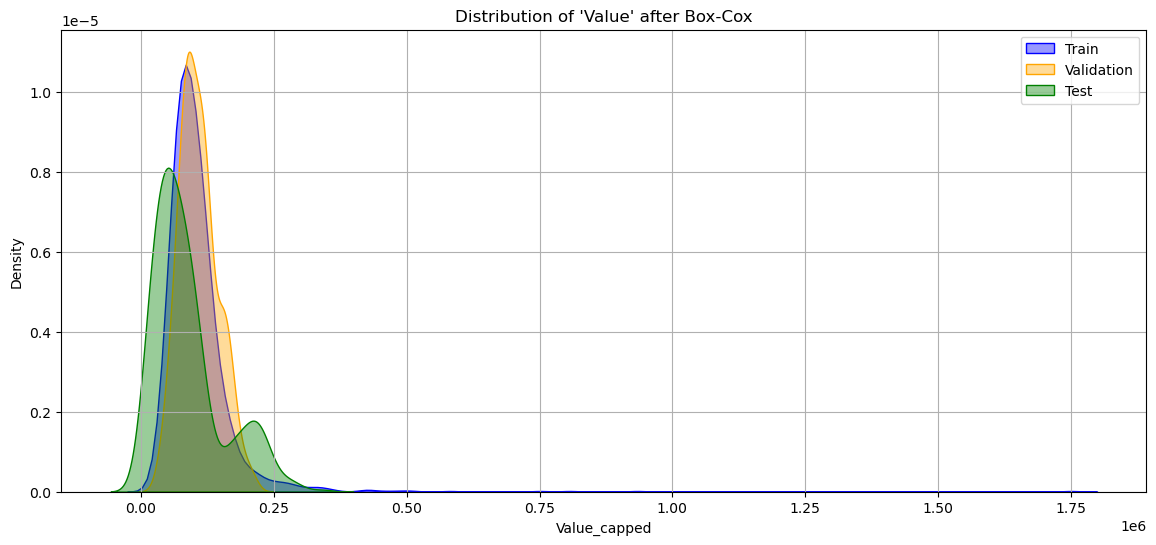

In [65]:

plt.figure(figsize=(14,6))

# Original or Box-Cox transformed values
sns.kdeplot(train['Value'], label='Train', fill=True, color='blue', alpha=0.4)
sns.kdeplot(val['Value'], label='Validation', fill=True, color='orange', alpha=0.4)
sns.kdeplot(test['Value'], label='Test', fill=True, color='green', alpha=0.4)

plt.title("Distribution of 'Value' after Box-Cox")
plt.xlabel('Value_capped')
plt.ylabel('Density')
plt.grid((True))
plt.legend()
plt.show()

In [66]:
# detect and limit extreme outliers
def causal_winsorize(s: pd.Series, window=7, z_thresh=6.0):
    roll_med = s.rolling(window=window, min_periods=1).median()
    roll_mad = (s - roll_med).abs().rolling(window=window, min_periods=1).median() + 1e-9
    z = (s - roll_med) / roll_mad
    return s.where(z.abs() < z_thresh, roll_med)


# apply causal winsorization to validation and test sets
def causal_from_history(future_df, history_df, cols, window=7, z_thresh=6.0):
    out = {}
    for c in cols:
        joined = pd.concat([history_df[c], future_df[c]])
        capped = causal_winsorize(joined, window=window, z_thresh=z_thresh)
        out[c] = capped.iloc[len(history_df):]  # only take future_df portion
    return pd.DataFrame(out, index=future_df.index)


def safe_target_winsorize(train_series, future_series=None, window=7, z_thresh=6.0):
    """
    Winsorize a target series safely.
    
    Args:
        train_series: pd.Series of training target
        future_series: pd.Series of validation/test target (optional)
        window: rolling window size for median/MAD
        z_thresh: threshold for z-score
    Returns:
        capped_train: training target capped
        capped_future: validation/test target capped (if future_series given)
    """
    # Compute rolling stats on training target
    roll_med = train_series.rolling(window=window, min_periods=1).median()
    roll_mad = (train_series - roll_med).abs().rolling(window=window, min_periods=1).median() + 1e-9
    z = (train_series - roll_med) / roll_mad
    
    # Cap train target
    capped_train = train_series.where(z.abs() < z_thresh, roll_med)
    
    capped_future = None
    if future_series is not None:
        # Apply the same thresholds (use last training median/MAD as reference)
        last_med = roll_med.iloc[-1]
        last_mad = roll_mad.iloc[-1]
        z_future = (future_series - last_med) / last_mad
        capped_future = future_series.where(z_future.abs() < z_thresh, last_med)
    
    return capped_train, capped_future

In [67]:
train.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'Cars for Sale',
       'computer', 'AutoTrader', 'clothing', 'Puma', 'Betfred', 'MTN', 'Value',
       'Value_lag1', 'Value_lag2'],
      dtype='object')

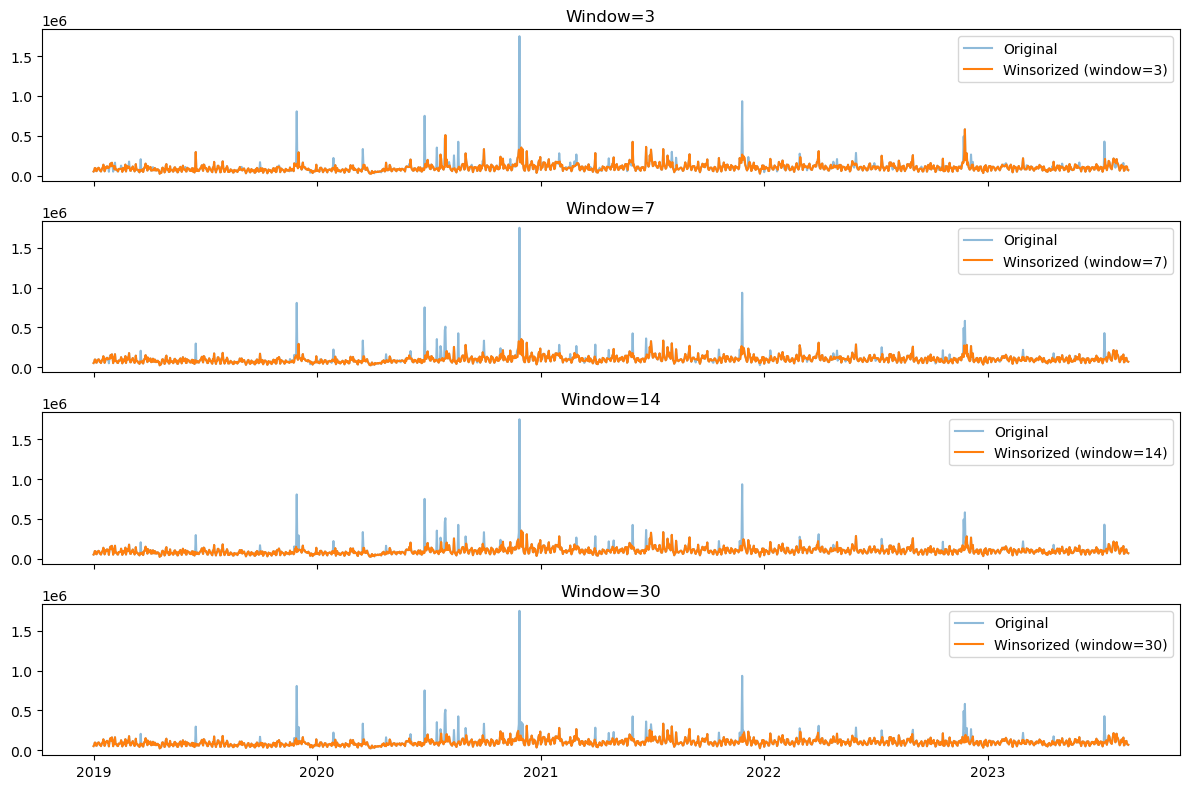

In [68]:
# deciding on the window size and z_thresh
candidate_windows = [3, 7, 14, 30]
col = "Value"

fig, axes = plt.subplots(len(candidate_windows), 1, figsize=(12, 8), sharex=True)
for i, w in enumerate(candidate_windows):
    capped = causal_winsorize(train[col], window=w, z_thresh=6.0)
    axes[i].plot(train[col], label="Original", alpha=0.5)
    axes[i].plot(capped, label=f"Winsorized (window={w})")
    axes[i].legend()
    axes[i].set_title(f"Window={w}")
plt.tight_layout()
plt.show()


In [69]:
train.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'Cars for Sale',
       'computer', 'AutoTrader', 'clothing', 'Puma', 'Betfred', 'MTN', 'Value',
       'Value_lag1', 'Value_lag2'],
      dtype='object')

In [70]:
# Applies the causal_winsorize function to each predictor column

exog_cols = [c for c in train.columns if c != 	'Value']  # target separate
train_exog = train[exog_cols].apply(causal_winsorize)


# apply causal winsorization to validation and test sets
val_exog   = causal_from_history(val, train, exog_cols)
test_exog  = causal_from_history(test, pd.concat([train, val]), exog_cols)


# --- Verify shapes ---
print("Train exogenous shape:", train_exog.shape)
print("Validation exogenous shape:", val_exog.shape)
print("Test exogenous shape:", test_exog.shape)

Train exogenous shape: (1692, 14)
Validation exogenous shape: (188, 14)
Test exogenous shape: (471, 14)


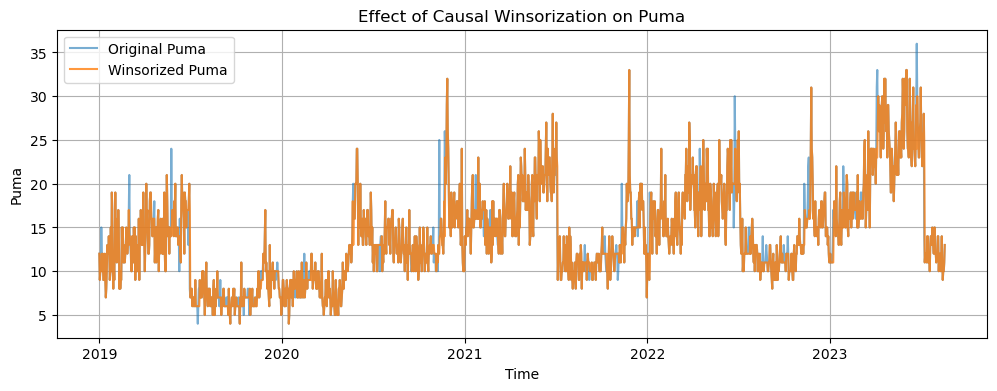

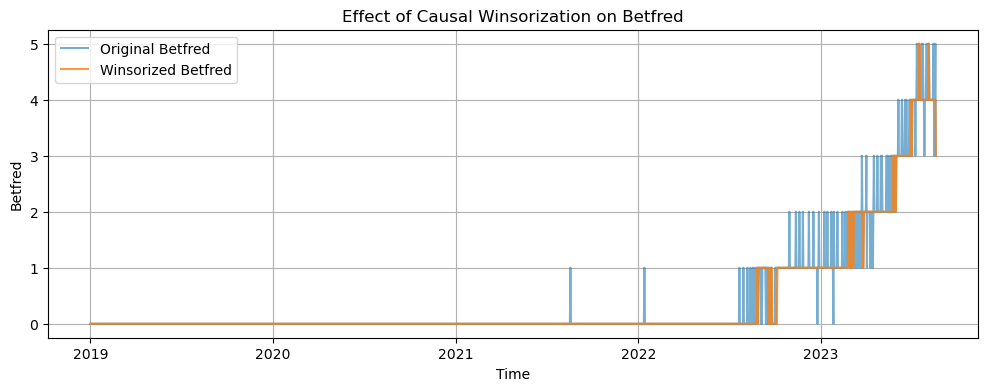

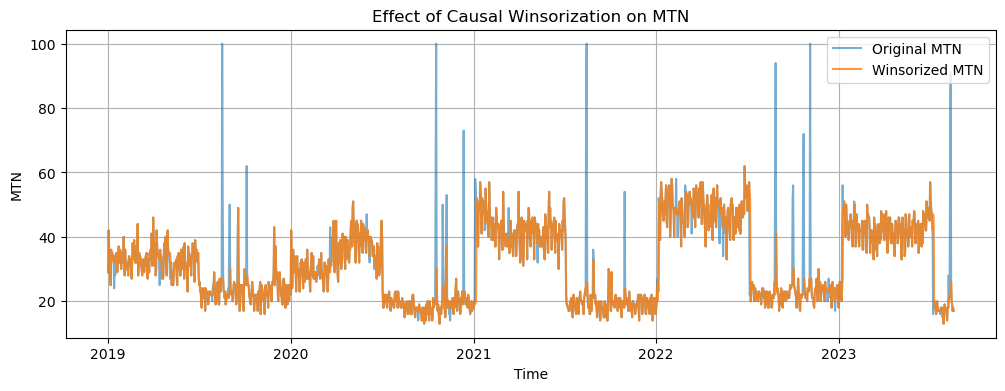

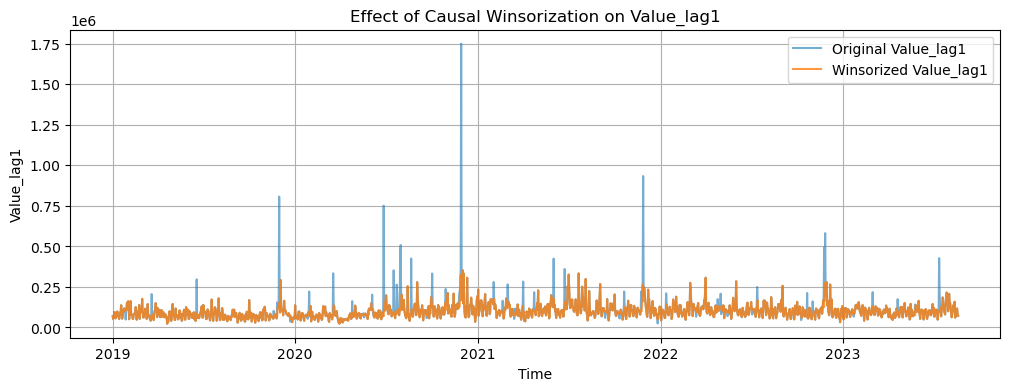

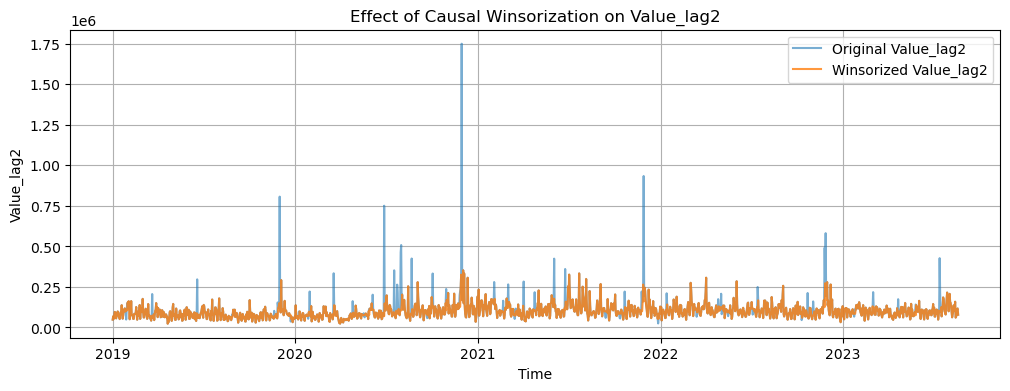

In [71]:
# Choose two  predictors
predictors = exog_cols[-5:]  # first two predictors

# Apply causal_winsorize for plotting
winsorized = train[predictors].apply(causal_winsorize)

# Plot each predictor before and after winsorization
for col in predictors:
    plt.figure(figsize=(12, 4))
    plt.plot(train[col], label=f'Original {col}', alpha=0.6)
    plt.plot(winsorized[col], label=f'Winsorized {col}', alpha=0.8)
    plt.title(f'Effect of Causal Winsorization on {col}')
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()
    plt.show()

In [72]:
# causal winsorization on the target column

# Train target
train_target = train['Value']

# Validation target
val_target = val['Value']

# Test target
test_target = test['Value']

# Apply causal winsorization
train_capped, val_capped = safe_target_winsorize(
    train_series=train_target,
    future_series=val_target,
    window=30,
    z_thresh=6.0
)

# For test, use the last training + validation as history
test_capped = causal_from_history(
    future_df=test[['Value']],
    history_df=pd.concat([train[['Value']], val[['Value']]]),
    cols=['Value'],
    window=30,
    z_thresh=6.0
)['Value']


train['Value_capped'] = train_capped
val['Value_capped']   = val_capped
test['Value_capped']  = test_capped


In [73]:
train.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'Cars for Sale',
       'computer', 'AutoTrader', 'clothing', 'Puma', 'Betfred', 'MTN', 'Value',
       'Value_lag1', 'Value_lag2', 'Value_capped'],
      dtype='object')

In [74]:
#---------------------------
# Rolling mean smoothing
#--------------------------

window = 7
train['Value_denoised'] = train['Value_capped'].rolling(window=window, min_periods=1).mean()
val['Value_denoised']   = val['Value_capped'].rolling(window=window, min_periods=1).mean()
test['Value_denoised']  = test['Value_capped'].rolling(window=window, min_periods=1).mean()



In [75]:
#------------------------------------
# Rolling mean smoothing (predictors)
#------------------------------------

window = 7  # window

# Denoise training predictors
train_exog_denoised = train_exog.rolling(window=window, min_periods=1).mean()

# Denoise validation predictors using past history (train + val)
val_exog_denoised = pd.concat([train_exog, val_exog]).rolling(window=window, min_periods=1).mean().iloc[len(train_exog):]

# Denoise test predictors using past history (train + val + test)
test_exog_denoised = pd.concat([train_exog, val_exog, test_exog]).rolling(window=window, min_periods=1).mean().iloc[len(train_exog) + len(val_exog):]

# convert back to DataFrames with original column names
train_exog_denoised = pd.DataFrame(train_exog_denoised, index=train.index, columns=exog_cols)
val_exog_denoised   = pd.DataFrame(val_exog_denoised, index=val.index, columns=exog_cols)
test_exog_denoised  = pd.DataFrame(test_exog_denoised, index=test.index, columns=exog_cols)


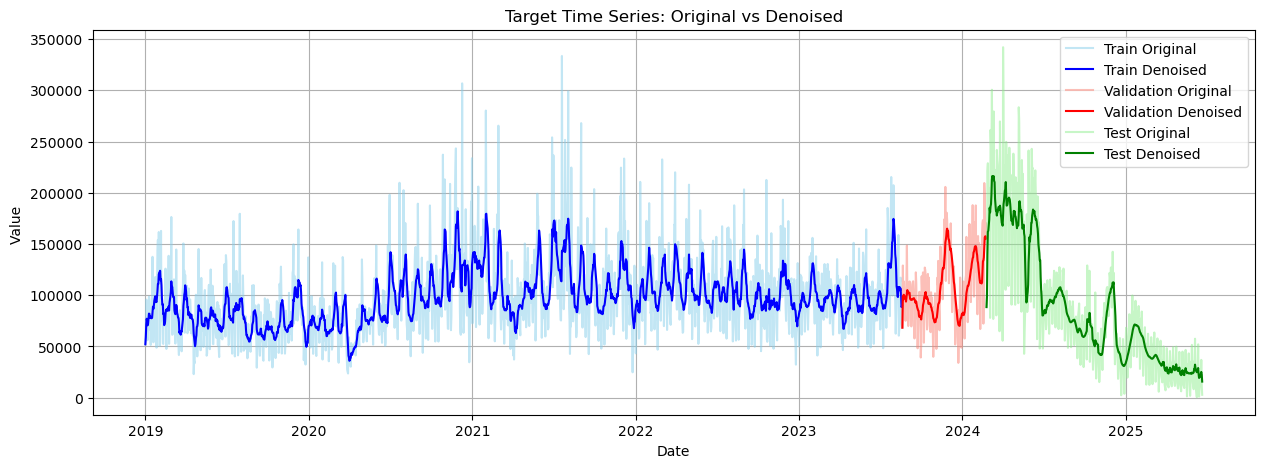

In [76]:
plt.figure(figsize=(15,5))
plt.plot(train.index, train['Value_capped'], label='Train Original', color='skyblue', alpha=0.5)
plt.plot(train.index, train['Value_denoised'], label='Train Denoised', color='blue')

plt.plot(val.index, val['Value_capped'], label='Validation Original', color='salmon', alpha=0.5)
plt.plot(val.index, val['Value_denoised'], label='Validation Denoised', color='red')

plt.plot(test.index, test['Value_capped'], label='Test Original', color='lightgreen', alpha=0.5)
plt.plot(test.index, test['Value_denoised'], label='Test Denoised', color='green')

plt.title('Target Time Series: Original vs Denoised')
plt.xlabel('Date')
plt.ylabel('Value ')
plt.legend()
plt.grid(True)
plt.show()

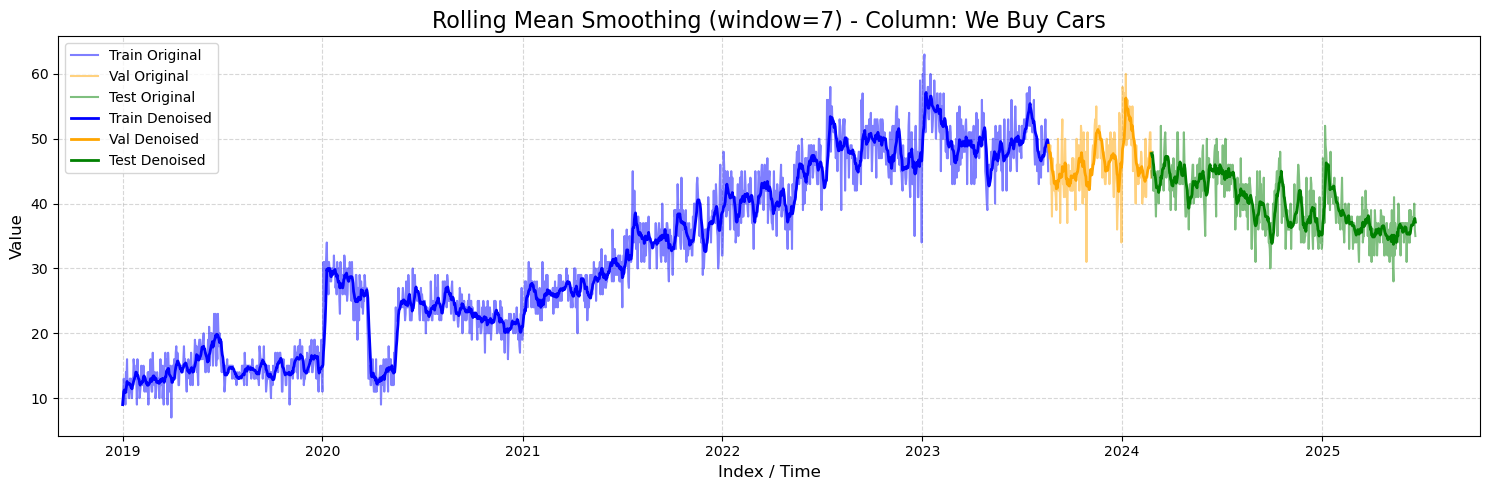

In [77]:
# Choose a predictor column to visualize
col_to_plot = exog_cols[2]  # first predictor column

plt.figure(figsize=(15,5))

# Original predictors
plt.plot(train_exog.index, train_exog[col_to_plot], label='Train Original', color='blue', alpha=0.5)
plt.plot(val_exog.index, val_exog[col_to_plot], label='Val Original', color='orange', alpha=0.5)
plt.plot(test_exog.index, test_exog[col_to_plot], label='Test Original', color='green', alpha=0.5)

# Denoised predictors
plt.plot(train_exog_denoised.index, train_exog_denoised[col_to_plot], label='Train Denoised', color='blue', linewidth=2)
plt.plot(val_exog_denoised.index, val_exog_denoised[col_to_plot], label='Val Denoised', color='orange', linewidth=2)
plt.plot(test_exog_denoised.index, test_exog_denoised[col_to_plot], label='Test Denoised', color='green', linewidth=2)

plt.title(f"Rolling Mean Smoothing (window={window}) - Column: {col_to_plot}", fontsize=16)
plt.xlabel("Index / Time", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [78]:
train.columns

Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'Cars for Sale',
       'computer', 'AutoTrader', 'clothing', 'Puma', 'Betfred', 'MTN', 'Value',
       'Value_lag1', 'Value_lag2', 'Value_capped', 'Value_denoised'],
      dtype='object')

In [79]:
cols_to_drop = ['Value_capped','Value']

train = train.drop(columns=[c for c in cols_to_drop if c in train.columns])
val   = val.drop(columns=[c for c in cols_to_drop if c in val.columns])
test  = test.drop(columns=[c for c in cols_to_drop if c in test.columns])

# Verify
print("Train columns:", train.columns)
#print("Validation columns:", val.columns)
print("Test columns:", test.columns)


Train columns: Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'Cars for Sale',
       'computer', 'AutoTrader', 'clothing', 'Puma', 'Betfred', 'MTN',
       'Value_lag1', 'Value_lag2', 'Value_denoised'],
      dtype='object')
Test columns: Index(['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'Cars for Sale',
       'computer', 'AutoTrader', 'clothing', 'Puma', 'Betfred', 'MTN',
       'Value_lag1', 'Value_lag2', 'Value_denoised'],
      dtype='object')


In [80]:
# Function to check stationarity
def check_stationarity(series, series_name='Series'):
    result = adfuller(series.dropna())
    print(f"ADF Test for {series_name}:")
    print(f"ADF Statistic: {result[0]}")
    #print(f"p-value: {result[1]}")
    #print("Critical Values:")
    for key, value in result[4].items():
       print(f"   {key}: {value}")
    if result[1] < 0.05:
        print(f"Result: {series_name} is stationary \n")
    else:
        print(f"Result: {series_name} is non-stationary \n")

# Check stationarity for train, validation, and test sets
datasets = [('Train', train), ('Validation', val), ('Test', test)]

for name, df in datasets:
    check_stationarity(df['Value_denoised'], f"{name} Denoised")

ADF Test for Train Denoised:
ADF Statistic: -2.9719692205902635
   1%: -3.4342717844184696
   5%: -2.8632722453211117
   10%: -2.567692204811933
Result: Train Denoised is stationary 

ADF Test for Validation Denoised:
ADF Statistic: -1.9205165865008855
   1%: -3.468952197801766
   5%: -2.878495056473015
   10%: -2.57580913601947
Result: Validation Denoised is non-stationary 

ADF Test for Test Denoised:
ADF Statistic: -1.5458063047983215
   1%: -3.444900499925237
   5%: -2.8679556266351653
   10%: -2.570187288941969
Result: Test Denoised is non-stationary 



In [81]:
train.head()

Avon  Property24  We Buy Cars  Game  Telkom  Cars for Sale  \
date                                                                     
2019-01-01    39          30            9    13      58             27   
2019-01-02    42          31           11    13      81             30   
2019-01-03    45          34           13    12      71             27   
2019-01-04    45          35           12    11      66             28   
2019-01-05    24          32           11    11      60             29   

            computer  AutoTrader  clothing  Puma  Betfred  MTN    Value_lag1  \
date                                                                           
2019-01-01        12          20        50    12        0   29  68629.143788   
2019-01-02        14          22        58     9        0   42  52162.890120   
2019-01-03        17          23        53    10        0   35  66311.844346   
2019-01-04        21          21        52    10        0   35  95740.128026   
2019-01-05        15          21        45    15        0   27  94094.655988   

              Value_lag2  Value_denoised  
date                                      
2019-01-01  48229.459312    52162.890120  
2019-01-02  68629.143788    59237.367233  
2019-01-03  52162.890120    71404.954164  
2019-01-04  66311.844346    77077.379620  
2019-01-05  95740.128026    73529.054771

In [82]:
# --- Initialize MinMaxScalers ---
scaler_X = MinMaxScaler().fit(train_exog_denoised)
scaler_y = MinMaxScaler().fit(train[['Value_denoised']])

# --- Transform predictors ---
X_train = scaler_X.transform(train_exog_denoised)
X_val   = scaler_X.transform(val_exog_denoised)
X_test  = scaler_X.transform(test_exog_denoised)

# --- Transform target ---
y_train = scaler_y.transform(train[['Value_denoised']])
y_val   = scaler_y.transform(val[['Value_denoised']])
y_test  = scaler_y.transform(test[['Value_denoised']])

# --- Print shapes ---
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1692, 14)
y_train shape: (1692, 1)
X_val shape: (188, 14)
y_val shape: (188, 1)
X_test shape: (471, 14)
y_test shape: (471, 1)


In [83]:
X_train_df = pd.DataFrame(X_train, index=train.index, columns=exog_cols)
X_val_df   = pd.DataFrame(X_val,   index=val.index,   columns=exog_cols)
X_test_df  = pd.DataFrame(X_test,  index=test.index,  columns=exog_cols)

y_train_df = pd.DataFrame(y_train, index=train.index, columns=['Value_denoised'])
y_val_df   = pd.DataFrame(y_val,   index=val.index,   columns=['Value_denoised'])
y_test_df  = pd.DataFrame(y_test,  index=test.index,  columns=['Value_denoised'])


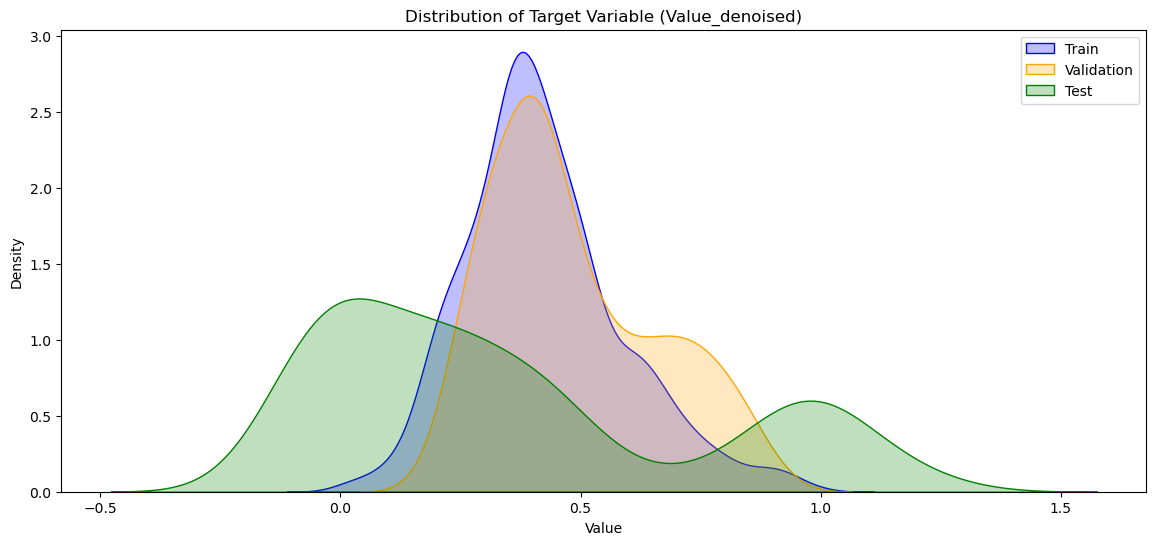

Skewness - Train: 0.6352
Skewness - Validation: 0.6391
Skewness - Test: 0.7624


In [84]:

plt.figure(figsize=(14,6))

sns.kdeplot(y_train_df['Value_denoised'], color='blue', label='Train', fill=True)
sns.kdeplot(y_val_df['Value_denoised'], color='orange', label='Validation', fill=True)
sns.kdeplot(y_test_df['Value_denoised'], color='green', label='Test', fill=True)

plt.title("Distribution of Target Variable (Value_denoised)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Skewness
print(f"Skewness - Train: {y_train_df['Value_denoised'].skew():.4f}")
print(f"Skewness - Validation: {y_val_df['Value_denoised'].skew():.4f}")
print(f"Skewness - Test: {y_test_df['Value_denoised'].skew():.4f}")

In [85]:
# Create sequences using past seq_length steps to predict current step


def create_sequences(X, y, seq_length=7):
    """
    Create LSTM sequences using past seq_length steps to predict current step.
    Keeps original indices for alignment.

    Parameters:
    X : pd.DataFrame, features
    y : pd.DataFrame or Series, target
    seq_length : int, number of past timesteps

    Returns:
    X_seq : np.array, shape (num_sequences, seq_length, n_features)
    y_seq : np.array, shape (num_sequences, 1)
    seq_index : np.array, indices of y corresponding to each sequence
    """
    X_seq, y_seq, seq_index = [], [], []

    for i in range(seq_length, len(X)):
        # Take past seq_length steps of features
        X_seq.append(X.iloc[i-seq_length:i].values)

        # Take target at current time step
        y_seq.append(y.iloc[i].values if y.ndim > 1 else y.iloc[i])

        # Store the corresponding index
        seq_index.append(X.index[i])

    return np.array(X_seq), np.array(y_seq), np.array(seq_index)


In [86]:
SEQ_LENGTH = 7  # Using past 7 days to predict next day

X_train_seq, y_train_seq, idx_train_seq = create_sequences(X_train_df, y_train_df, SEQ_LENGTH)
X_val_seq, y_val_seq, idx_val_seq       = create_sequences(X_val_df, y_val_df, SEQ_LENGTH)
X_test_seq, y_test_seq, idx_test_seq    = create_sequences(X_test_df, y_test_df, SEQ_LENGTH)

# Print shapes
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("Number of indices:", len(idx_train_seq))

X_train_seq shape: (1685, 7, 14)
y_train_seq shape: (1685, 1)
Number of indices: 1685


In [87]:
print("First sequence shape:", X_test_seq[0].shape)
print("Target of first sequence:", y_test_seq[0])
print("Original index of first sequence target:", idx_test_seq[0])

First sequence shape: (7, 14)
Target of first sequence: [1.02385663]
Original index of first sequence target: 2024-03-02 00:00:00


In [88]:
# HELPING FUCTIONS

# training history ploting function
def plot_history(histories, names):
    plt.figure(figsize=(18,6))
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'{names[i]} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{names[i]} Val Loss', linestyle='--')
    plt.title('Deep Learning Model Training History (MSE Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# orediction ploting function
def plot_predictions(idx_val, y_val_true, y_val_pred,
                     idx_test, y_test_true, y_test_pred,
                     title='Model Predictions vs True Values'):
    plt.figure(figsize=(16,6))

    # Validation
    plt.plot(idx_val, y_val_true, label='Validation True', color='blue')
    plt.plot(idx_val, y_val_pred, label='Validation Pred', color='orange', linestyle='--')

    # Test
    plt.plot(idx_test, y_test_true, label='Test True', color='green')
    plt.plot(idx_test, y_test_pred, label='Test Pred', color='red', linestyle='--')

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True   )
    plt.legend()
    plt.show()
   
# evaluation fuction
def evaluate_predictions(y_true, y_pred, set_name='Test'):
    print(f"Evaluation Metrics for {set_name} Set:")
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Print metrics 
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")
    
    metrics_dict = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    return metrics_dict


# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=10,            
    restore_best_weights=True 
)



# Hyperparameters
n_features = X_train_seq.shape[2]   # number of features in input
SEQ_LENGTH = X_train_seq.shape[1]   # timesteps
Epochs = 100
Batch_size = 64


In [89]:
def plot_predictions_full(idx_train, y_train, 
                          idx_val, y_val_true, y_val_pred,
                          idx_test, y_test_true, y_test_pred,
                          title='Model Predictions vs True Values'):
    plt.figure(figsize=(18,6))
    
    # --- Training ---
    plt.plot(idx_train, y_train, label='Train True', color='blue')
    
    # --- Validation ---
    plt.plot(idx_val, y_val_true, label='Validation True', color='green')
    plt.plot(idx_val, y_val_pred, label='Validation Pred', color='orange', linestyle='--')
    
    # --- Test ---
    plt.plot(idx_test, y_test_true, label='Test True', color='purple')
    plt.plot(idx_test, y_test_pred, label='Test Pred', color='red', linestyle='--')
    
    # Optional: shade validation and test regions for clarity
    plt.axvspan(idx_val[0], idx_val[-1], color='green', alpha=0.1)
    plt.axvspan(idx_test[0], idx_test[-1], color='red', alpha=0.1)
    
    plt.xlabel('Index / Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


# ARIMAX

In [90]:
# Define ARIMAX model
arimax_model = SARIMAX(
    endog=y_train_df,        # target
    exog=X_train_df,         # exogenous features
    order=(3,0,2),           # ARIMA order (p,d,q)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
arimax_result = arimax_model.fit(disp=False)

# Print model summary
print(arimax_result.summary())

c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Value_denoised   No. Observations:                 1692
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3310.258
Date:                Thu, 06 Nov 2025   AIC                          -6580.516
Time:                        11:40:31   BIC                          -6471.878
Sample:                    01-01-2019   HQIC                         -6540.285
                         - 08-19-2023                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Avon              0.2718      0.046      5.850      0.000       0.181       0.363
Property24        0.0968      0.068      1.421      0.155      -0.037       0.230
We Buy Cars       0.1011      0.071     

c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


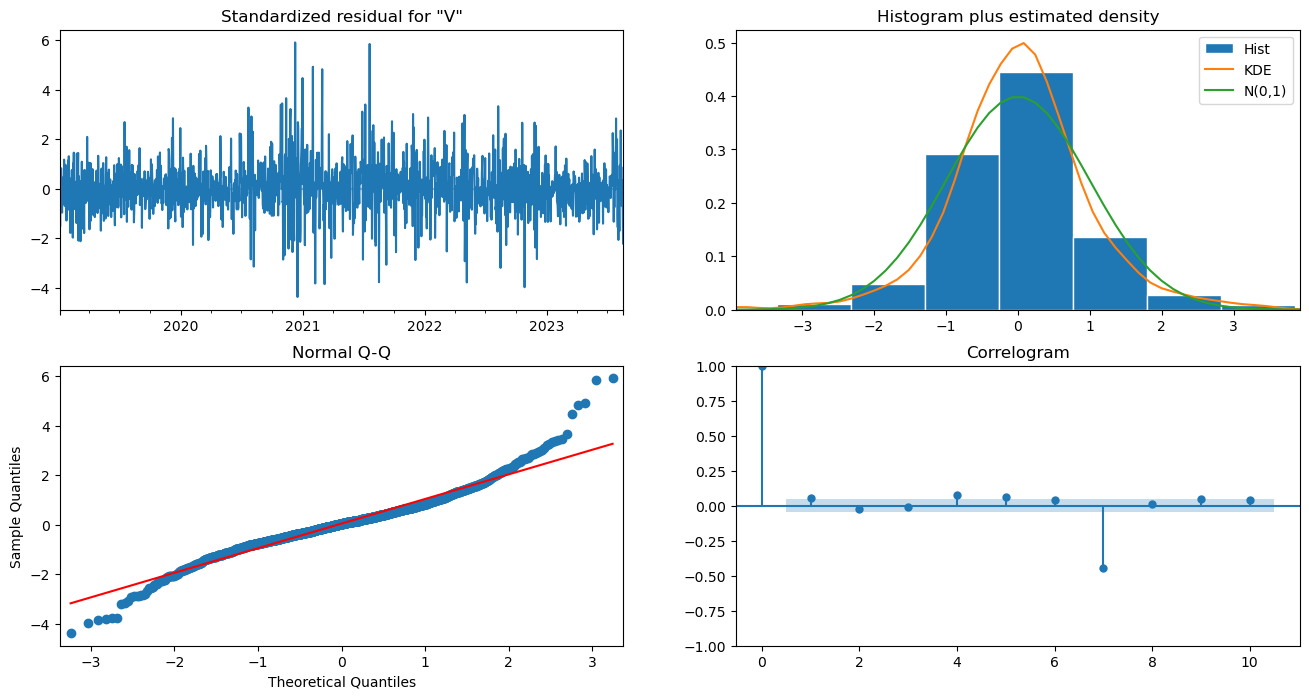

In [91]:
arimax_result.plot_diagnostics(figsize=(16, 8))
plt.show()


In [92]:
# --- Validation predictions ---
y_val_pred_arimax = arimax_result.get_forecast(steps=len(X_val_df), exog=X_val_df).predicted_mean
y_val_pred_arimax_scaled = scaler_y.transform(y_val_pred_arimax.values.reshape(-1, 1))  #  scale predictions
y_val_true_arimax = y_val_df.values  

# --- Test predictions ---
y_test_pred_arimax = arimax_result.get_forecast(steps=len(X_test_df), exog=X_test_df).predicted_mean
y_test_pred_arimax_scaled = scaler_y.transform(y_test_pred_arimax.values.reshape(-1, 1))  #  scale predictions
y_test_true_arimax = y_test_df.values  


In [93]:

# --- Evaluate predictions on scaled data ---
metrics_val_arimax = evaluate_predictions(
    y_val_true_arimax, 
    y_val_pred_arimax.values.reshape(-1, 1), 
    set_name='Validation'
)

metrics_test_arimax = evaluate_predictions(
    y_test_true_arimax, 
    y_test_pred_arimax.values.reshape(-1, 1), 
    set_name='Test'
)


# Extract RMSE, MAE, R² for Validation set
rmse_arimax_val = metrics_val_arimax['RMSE']
mae_arimax_val  = metrics_val_arimax['MAE']
r2_arimax_val   = metrics_val_arimax['R2']

# Extract RMSE, MAE, R² for comparison
rmse_arimax = metrics_test_arimax['RMSE']
mae_arimax  = metrics_test_arimax['MAE']
r2_arimax   = metrics_test_arimax['R2']

Evaluation Metrics for Validation Set:
MAE: 0.1014
RMSE: 0.1291
R2: 0.4337
Evaluation Metrics for Test Set:
MAE: 0.2253
RMSE: 0.2751
R2: 0.4945


In [94]:
# Inverse-transform
y_val_true_arimax = scaler_y.inverse_transform(y_val_df)
y_val_pred_arimax_rescaled = scaler_y.inverse_transform(y_val_pred_arimax.values.reshape(-1,1))


# Inverse-transform
y_test_true_arimax = scaler_y.inverse_transform(y_test_df)
y_test_pred_arimax_rescaled = scaler_y.inverse_transform(y_test_pred_arimax.values.reshape(-1,1))



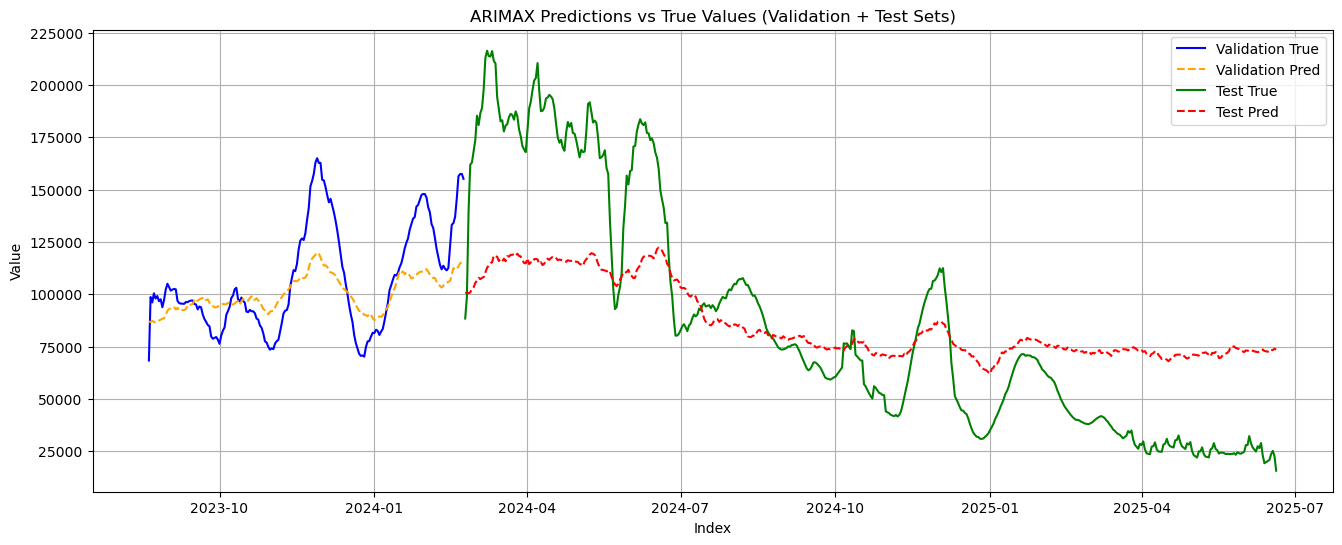

In [95]:
# Validation indices
idx_val_arimax = X_val_df.index
# Test indices
idx_test_arimax = X_test_df.index

# Plot ARIMAX predictions
plot_predictions(
    idx_val_arimax, y_val_true_arimax, y_val_pred_arimax_rescaled,
    idx_test_arimax, y_test_true_arimax, y_test_pred_arimax_rescaled,
    title='ARIMAX Predictions vs True Values (Validation + Test Sets)'
)

# LSTM

In [96]:
def build_lstm(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First LSTM layer
        LSTM(64, activation='tanh', return_sequences=True, 
             kernel_regularizer=l2(l2_reg), input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # Second LSTM layer
        LSTM(32, kernel_regularizer=l2(l2_reg)),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # predicting single value
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate model
lstm_model = build_lstm(SEQ_LENGTH, n_features, l2_reg=0.0001)
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 64)          │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,673 (127.63 KB)

 Trainable params: 32,673 (127.63 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop]
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0656 - mae: 0.1850 - val_loss: 0.0288 - val_mae: 0.1089
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0324 - mae: 0.1183 - val_loss: 0.0258 - val_mae: 0.1016
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0266 - mae: 0.1011 - val_loss: 0.0351 - val_mae: 0.1266
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0254 - mae: 0.1003 - val_loss: 0.0278 - val_mae: 0.1091
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0239 - mae: 0.0971 - val_loss: 0.0263 - val_mae: 0.1057
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0225 - mae: 0.0950 - val_loss: 0.0255 - val_mae: 0.1046
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0216 - mae: 0.0953 - val_loss: 0.0277 - val_mae: 0.1122
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0215 - mae: 0.0940 - val_loss: 0.0221 - val_mae: 0.0972
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.01

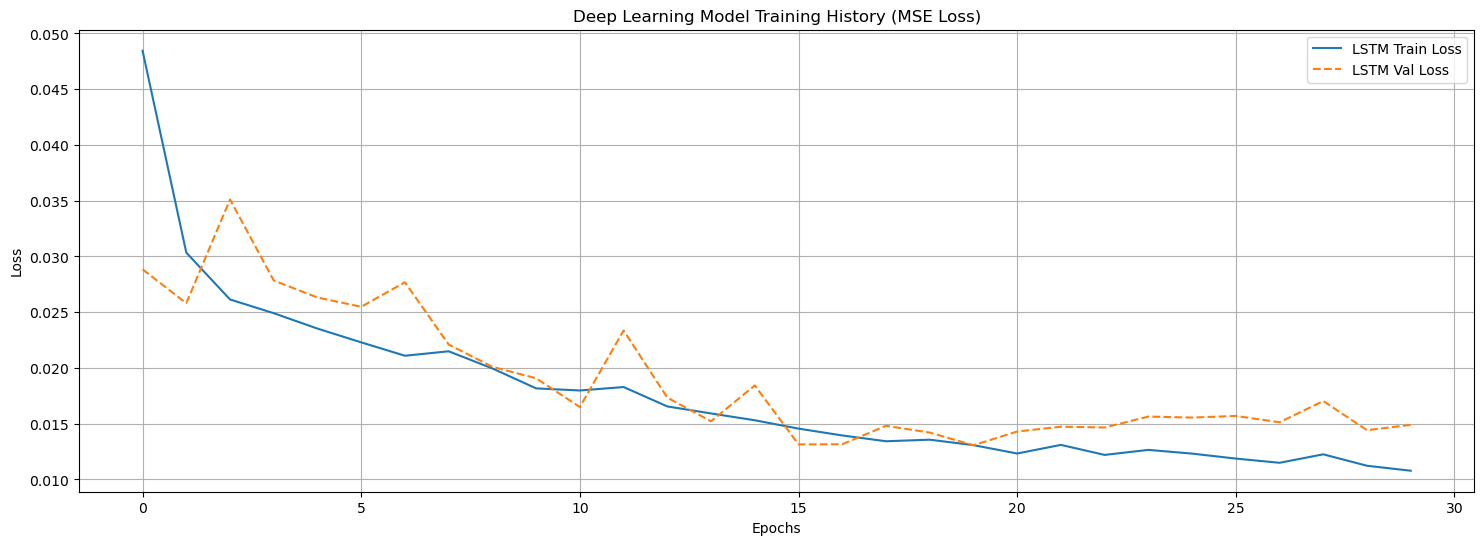

In [98]:
# Call the function
plot_history(
    histories=[history_lstm],
    names=['LSTM']
)

In [99]:
# Validation predictions
y_val_pred = lstm_model.predict(X_val_seq)
# Test predictions
y_test_pred = lstm_model.predict(X_test_seq)

# Validation DataFrame
val_pred_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred.flatten(),
}, index=idx_val_seq)

# Test DataFrame
test_pred_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred.flatten(),
}, index=idx_test_seq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [100]:
y_val_pred_lstm_rescaled = scaler_y.inverse_transform(val_pred_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_df[['y_true']])

y_test_pred_lstm_rescaled = scaler_y.inverse_transform(test_pred_df[['y_pred']])
y_test_true_lstm_rescaled = scaler_y.inverse_transform(test_pred_df[['y_true']])


# --- Evaluate metrics 
metrics_val_lstm  = evaluate_predictions(
    y_true=val_pred_df ['y_true'],
    y_pred=val_pred_df ['y_pred'],
    set_name='Validation'
)

metrics_test_lstm = evaluate_predictions(
    y_true=test_pred_df['y_true'],
    y_pred=test_pred_df['y_pred'],
    set_name='Test'
)


# Extract RMSE, MAE, R² for test set
rmse_lstm = metrics_test_lstm['RMSE']
mae_lstm  = metrics_test_lstm['MAE']
r2_lstm   = metrics_test_lstm['R2']

# Extract RMSE, MAE, R² for Validation set
rmse_lstm_val = metrics_val_lstm['RMSE']
mae_lstm_val  = metrics_val_lstm['MAE']
r2_lstm_val   = metrics_val_lstm['R2']


Evaluation Metrics for Validation Set:
MAE: 0.0808
RMSE: 0.0980
R2: 0.6805
Evaluation Metrics for Test Set:
MAE: 0.1601
RMSE: 0.1799
R2: 0.7828


In [101]:
def plot_predictions_full(idx_train, y_train, 
                          idx_val, y_val_true, y_val_pred,
                          idx_test, y_test_true, y_test_pred,
                          title='Model Predictions vs True Values'):
    plt.figure(figsize=(18,6))
    
    # --- Training ---
    plt.plot(idx_train, y_train, label='Train True', color='blue')
    
    # --- Validation ---
    plt.plot(idx_val, y_val_true, label='Validation True', color='green')
    plt.plot(idx_val, y_val_pred, label='Validation Pred', color='orange', linestyle='--')
    
    # --- Test ---
    plt.plot(idx_test, y_test_true, label='Test True', color='purple')
    plt.plot(idx_test, y_test_pred, label='Test Pred', color='red', linestyle='--')
    
    # Shade validation and test regions
    plt.axvspan(idx_val[0], idx_val[-1], color='green', alpha=0.05)
    plt.axvspan(idx_test[0], idx_test[-1], color='red', alpha=0.05)
    
    plt.xlabel('Index / Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


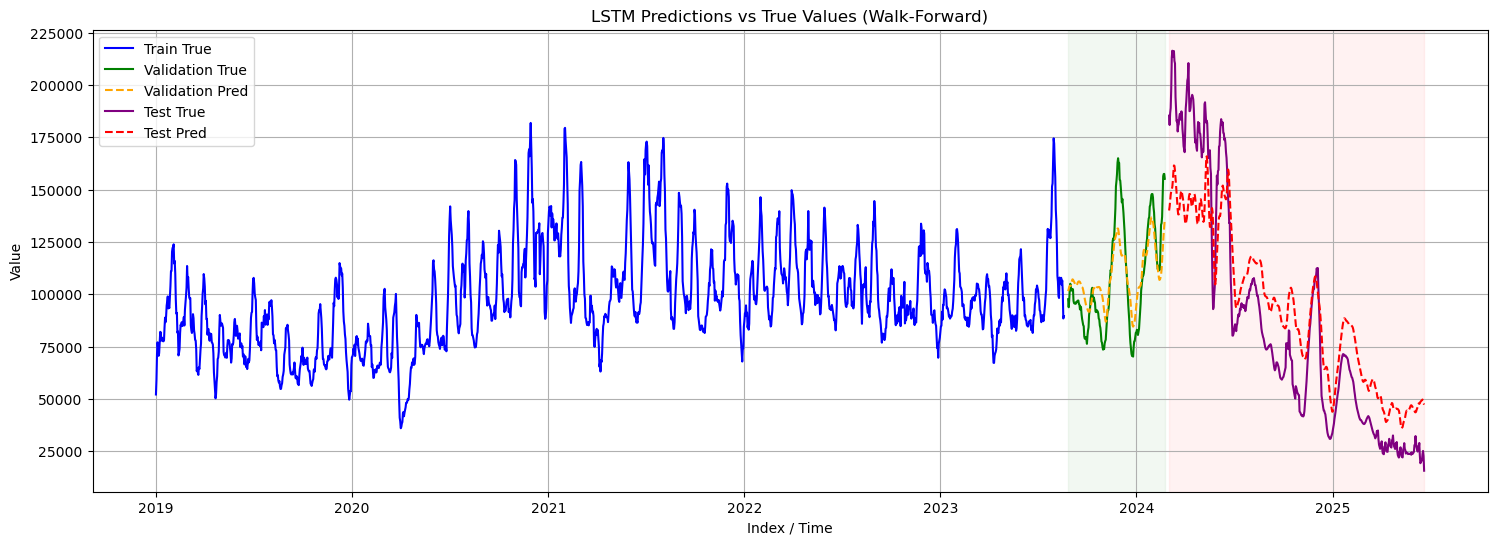

In [102]:
plot_predictions_full(
    idx_train=train.index, y_train=train['Value_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_lstm_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_lstm_rescaled, y_test_pred=y_test_pred_lstm_rescaled,
    title='LSTM Predictions vs True Values (Walk-Forward)'
)


In [103]:
n_display = 10

# Take first n_display predictions and actuals
actual = y_test_true_lstm_rescaled[:n_display].flatten()
predicted = y_test_pred_lstm_rescaled[:n_display].flatten()
indices = idx_test_seq[:n_display]  # original indices

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'date': indices,
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df)

        date         Actual      Predicted
0 2024-03-02  185379.601297  140069.046875
1 2024-03-03  180924.373376  141898.093750
2 2024-03-04  186622.833023  144626.140625
3 2024-03-05  189021.243944  147570.312500
4 2024-03-06  198146.072225  149241.015625
5 2024-03-07  213061.502629  150168.281250
6 2024-03-08  216406.263229  151297.765625
7 2024-03-09  213812.934914  154286.625000
8 2024-03-10  213655.140597  158504.843750
9 2024-03-11  216231.733618  161587.484375


# Bi-LSTM

In [104]:
def build_bilstm(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First Bi-LSTM layer
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True,
                           kernel_regularizer=l2(l2_reg)),
                      input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # Second Bi-LSTM layer
        Bidirectional(LSTM(32, kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # single output
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate model
bilstm_model = build_bilstm(SEQ_LENGTH, n_features, l2_reg=0.0001)
bilstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 7, 128)         │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,729 (319.25 KB)

 Trainable params: 81,729 (319.25 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
history_bilstm = bilstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop]
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.1018 - mae: 0.2059 - val_loss: 0.0492 - val_mae: 0.1167
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0457 - mae: 0.1067 - val_loss: 0.0512 - val_mae: 0.1303
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0375 - mae: 0.0956 - val_loss: 0.0370 - val_mae: 0.1014
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0324 - mae: 0.0881 - val_loss: 0.0314 - val_mae: 0.0924
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0299 - mae: 0.0894 - val_loss: 0.0281 - val_mae: 0.0888
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0258 - mae: 0.0809 - val_loss: 0.0240 - val_mae: 0.0812
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0244 - mae: 0.0808 - val_loss: 0.0231 - val_mae: 0.0876
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0219 - mae: 0.0763 - val_loss: 0.0232 - val_mae: 0.0935
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

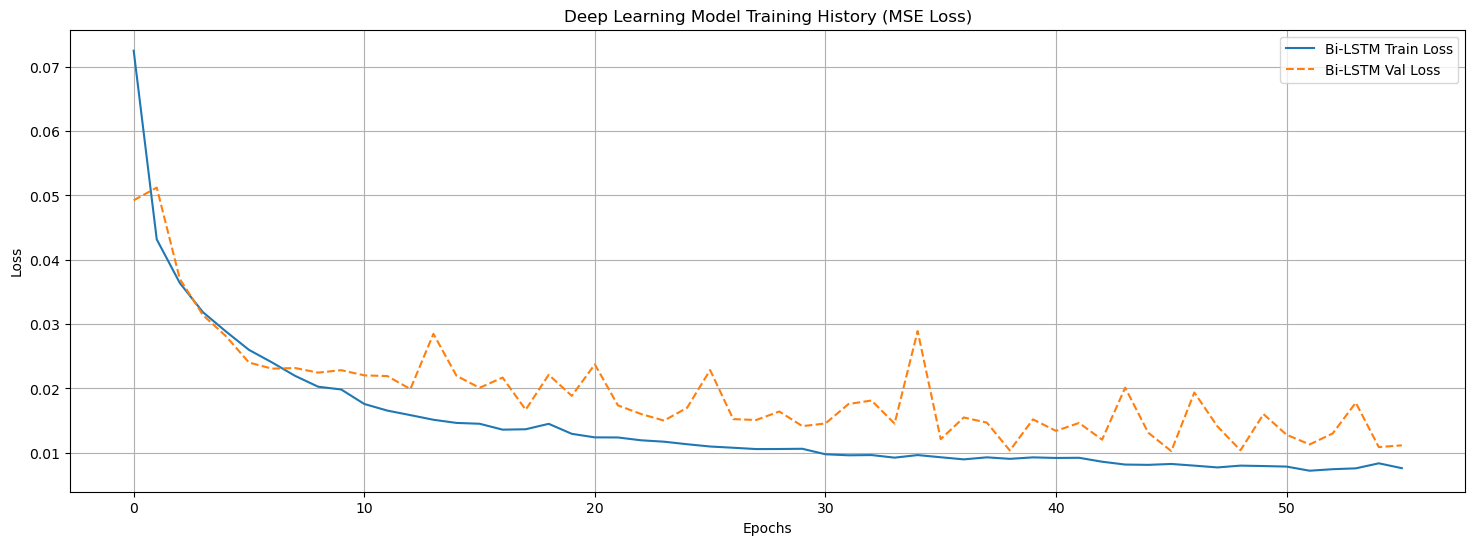

In [106]:
# plot training history
plot_history(
    histories=[history_bilstm],
    names=['Bi-LSTM']
)

In [107]:
# Validation predictions
y_val_pred_bi = bilstm_model.predict(X_val_seq)
# Test predictions
y_test_pred_bi = bilstm_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_bi_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_bi.flatten()
}, index=idx_val_seq)

test_pred_bi_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_bi.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_bi_rescaled = scaler_y.inverse_transform(val_pred_bi_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_bi_df[['y_true']])

y_test_pred_bi_rescaled = scaler_y.inverse_transform(test_pred_bi_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_bi_df[['y_true']])


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [108]:

# --- Evaluate metrics 
metrics_val_bilstm = evaluate_predictions(
    y_true=val_pred_bi_df ['y_true'],
    y_pred=val_pred_bi_df ['y_pred'],
    set_name='Validation'
)

metrics_test_bilstm  = evaluate_predictions(
    y_true=test_pred_bi_df['y_true'],
    y_pred=test_pred_bi_df['y_pred'],
    set_name='Test'
)

# Extract RMSE, MAE, R² for test set
rmse_bilstm = metrics_test_bilstm['RMSE']
mae_bilstm  = metrics_test_bilstm['MAE']
r2_bilstm   = metrics_test_bilstm['R2']

#Extract RMSE, MAE, R² for Validation set
rmse_bilstm_val = metrics_val_bilstm['RMSE']
mae_bilstm_val  = metrics_val_bilstm['MAE']
r2_bilstm_val   = metrics_val_bilstm['R2']

Evaluation Metrics for Validation Set:
MAE: 0.0716
RMSE: 0.0856
R2: 0.7560
Evaluation Metrics for Test Set:
MAE: 0.1131
RMSE: 0.1494
R2: 0.8501


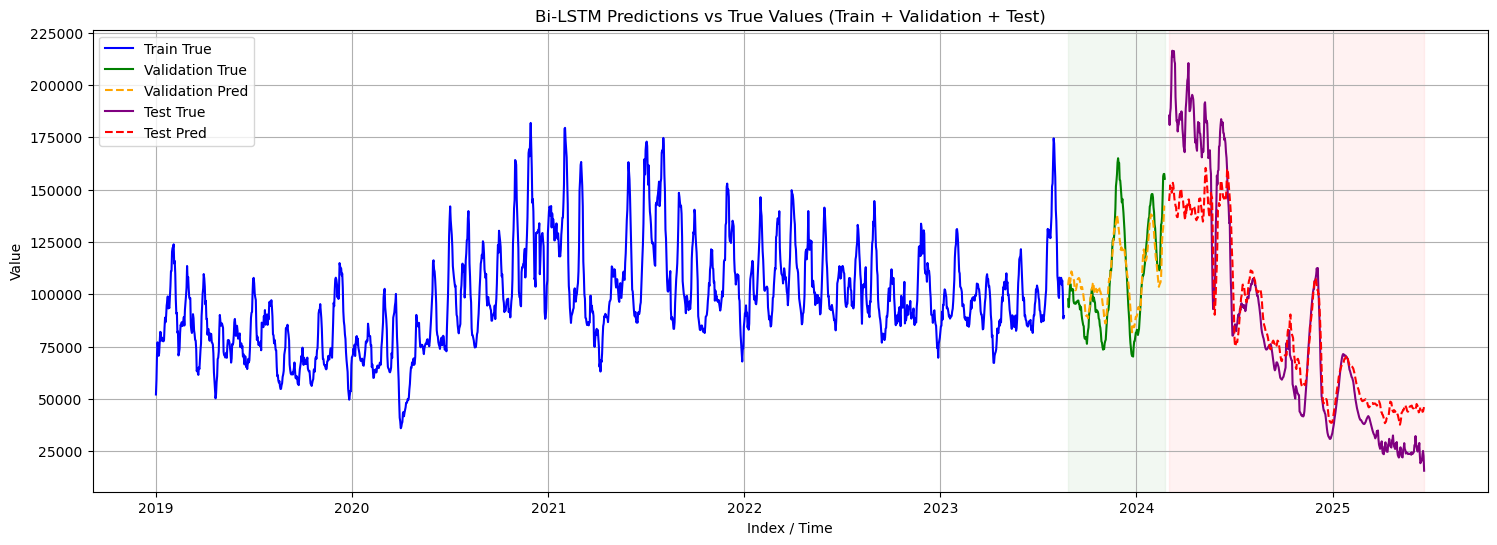

In [109]:
plot_predictions_full(
    idx_train=train.index, y_train=train['Value_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_bi_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_bi_rescaled,
    title='Bi-LSTM Predictions vs True Values (Train + Validation + Test)'
)


In [110]:
n_display = 10

# Take first n_display predictions and actuals for Bi-LSTM
actual = y_test_true_rescaled[:n_display].flatten()
predicted = y_test_pred_bi_rescaled[:n_display].flatten()
indices = idx_test_seq[:n_display]  # original indices

# Create a DataFrame for comparison
comparison_df_bi = pd.DataFrame({
    'date': indices,
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df_bi)

        date         Actual      Predicted
0 2024-03-02  185379.601297  144609.625000
1 2024-03-03  180924.373376  147454.062500
2 2024-03-04  186622.833023  152056.546875
3 2024-03-05  189021.243944  149486.937500
4 2024-03-06  198146.072225  149692.906250
5 2024-03-07  213061.502629  148570.546875
6 2024-03-08  216406.263229  149851.703125
7 2024-03-09  213812.934914  153300.109375
8 2024-03-10  213655.140597  152016.250000
9 2024-03-11  216231.733618  148560.453125


# GRU

In [111]:
def build_gru(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First GRU layer
        GRU(64, activation='tanh', return_sequences=True,
            kernel_regularizer=l2(l2_reg), input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # Second GRU layer
        GRU(32, activation='tanh', kernel_regularizer=l2(l2_reg)),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # predicting single value
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate the GRU model
gru_model = build_gru(SEQ_LENGTH, n_features, l2_reg=0.0001)
gru_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 7, 64)          │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801 (96.88 KB)

 Trainable params: 24,801 (96.88 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0698 - mae: 0.1923 - val_loss: 0.0271 - val_mae: 0.1080
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0315 - mae: 0.1153 - val_loss: 0.0247 - val_mae: 0.0997
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0276 - mae: 0.1059 - val_loss: 0.0246 - val_mae: 0.1016
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0234 - mae: 0.0983 - val_loss: 0.0289 - val_mae: 0.1157
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0232 - mae: 0.0985 - val_loss: 0.0233 - val_mae: 0.1017
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0196 - mae: 0.0911 - val_loss: 0.0203 - val_mae: 0.0944
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - mae: 0.0865 - val_loss: 0.0182 - val_mae: 0.0889
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0204 - mae: 0.0925 - val_loss: 0.0151 - val_mae: 0.0790
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0180 - mae

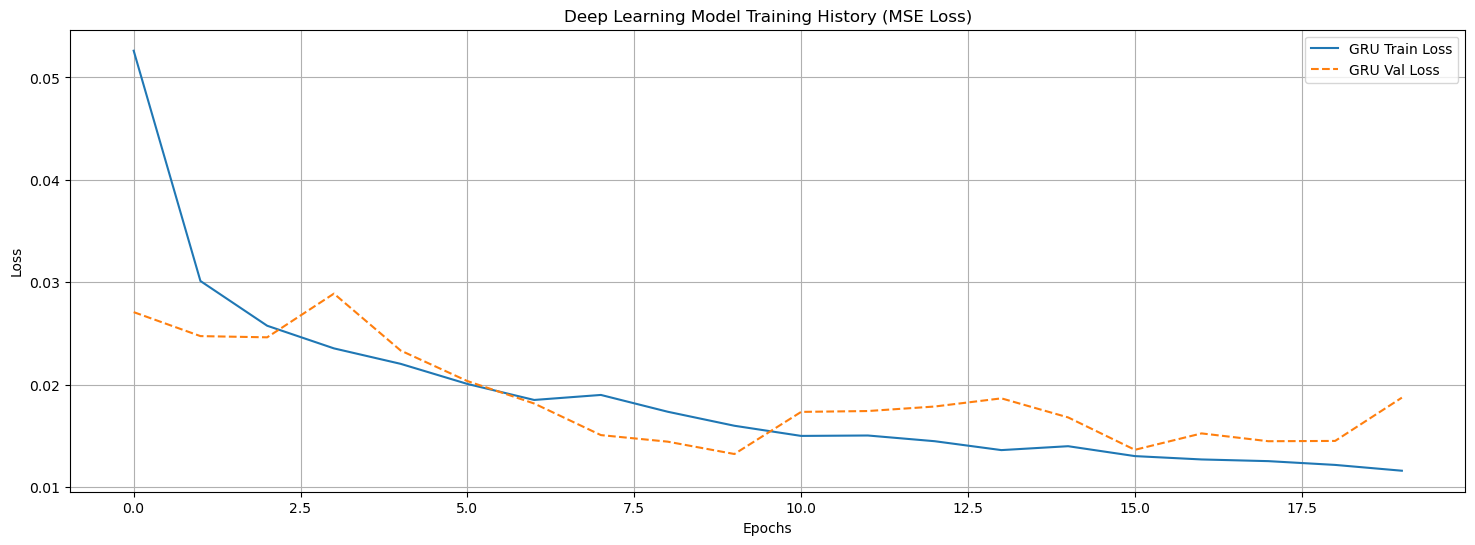

In [113]:
# Call the function
plot_history(
    histories=[history_gru],
    names=[ 'GRU']
)

In [114]:
# Validation predictions
y_val_pred_gru = gru_model.predict(X_val_seq)
# Test predictions
y_test_pred_gru = gru_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_gru_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_gru.flatten()
}, index=idx_val_seq)

test_pred_gru_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_gru.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_gru_rescaled = scaler_y.inverse_transform(val_pred_gru_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_gru_df[['y_true']])

y_test_pred_gru_rescaled = scaler_y.inverse_transform(test_pred_gru_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_gru_df[['y_true']])


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [115]:
# --- Evaluate metrics 
metrics_val_gru = evaluate_predictions(
    y_true=val_pred_gru_df ['y_true'],
    y_pred=val_pred_gru_df ['y_pred'],
    set_name='Validation'
)

metrics_test_gru = evaluate_predictions(
    y_true=test_pred_gru_df['y_true'],
    y_pred=test_pred_gru_df['y_pred'],
    set_name='Test'
)

# Extract RMSE, MAE, R² for test set
rmse_gru = metrics_test_gru['RMSE']
mae_gru  = metrics_test_gru['MAE']
r2_gru   = metrics_test_gru['R2']

# Extract RMSE, MAE, R² for Validation set
rmse_gru_val = metrics_val_gru['RMSE']
mae_gru_val  = metrics_val_gru['MAE']
r2_gru_val   = metrics_val_gru['R2']


Evaluation Metrics for Validation Set:
MAE: 0.0747
RMSE: 0.0937
R2: 0.7078
Evaluation Metrics for Test Set:
MAE: 0.1469
RMSE: 0.1754
R2: 0.7937


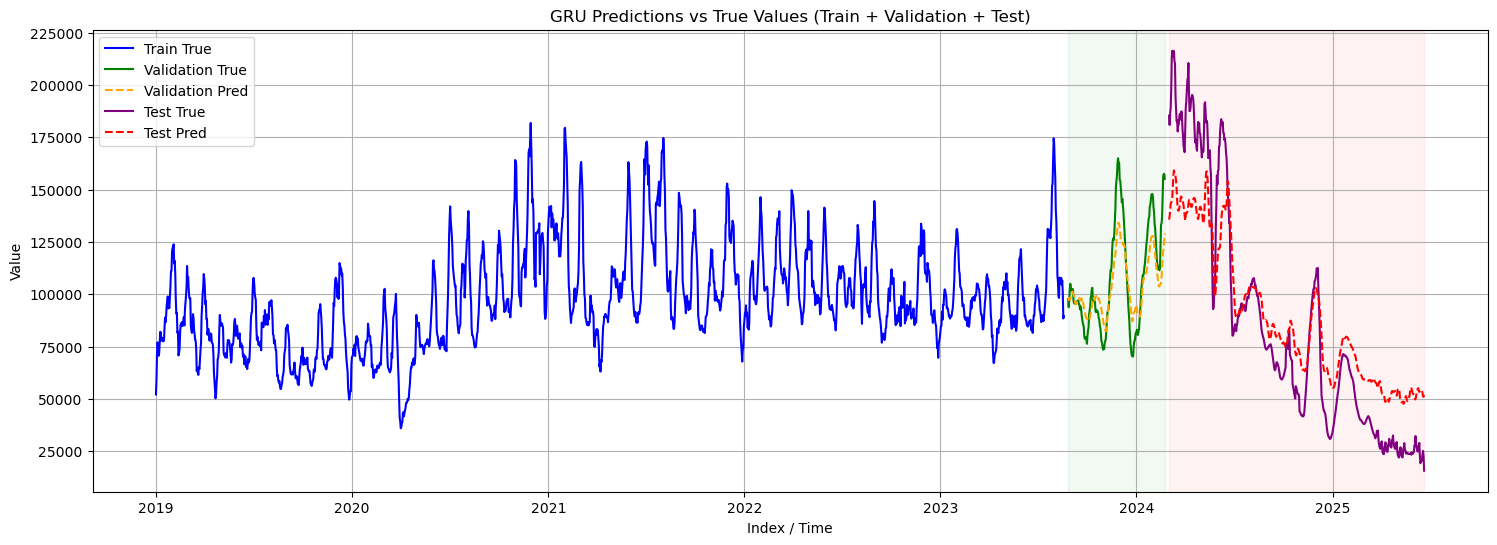

In [116]:
# Plot GRU predictions with full timeline
plot_predictions_full(
    idx_train=train.index, y_train=train['Value_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_gru_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_gru_rescaled,
    title='GRU Predictions vs True Values (Train + Validation + Test)'
)

In [117]:
n_display = 10

# Take first n_display predictions and actuals for Bi-LSTM
actual = y_test_true_rescaled[:n_display].flatten()
predicted = y_test_pred_gru_rescaled[:n_display].flatten()
indices = idx_test_seq[:n_display]  # original indices

# Create a DataFrame for comparison
comparison_df_gru = pd.DataFrame({
    'date': indices,
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df_gru)

        date         Actual      Predicted
0 2024-03-02  185379.601297  135712.328125
1 2024-03-03  180924.373376  137280.125000
2 2024-03-04  186622.833023  140522.781250
3 2024-03-05  189021.243944  143263.609375
4 2024-03-06  198146.072225  143958.843750
5 2024-03-07  213061.502629  144590.890625
6 2024-03-08  216406.263229  146579.000000
7 2024-03-09  213812.934914  151393.109375
8 2024-03-10  213655.140597  156749.468750
9 2024-03-11  216231.733618  159240.203125


# Bi-GRU 

In [118]:
def build_bigru(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First Bi-GRU layer
        Bidirectional(GRU(64, activation='tanh', return_sequences=True,
                          kernel_regularizer=l2(l2_reg)),
                      input_shape=(seq_length, n_features)),
        Dropout(0.2),
        
        # Second Bi-GRU layer
        Bidirectional(GRU(32, activation='tanh', kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),
        
        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # predicting single value
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate the Bi-GRU model
bigru_model = build_bigru(SEQ_LENGTH, n_features, l2_reg=0.0001)
bigru_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 7, 128)         │        30,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,889 (241.75 KB)

 Trainable params: 61,889 (241.75 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
history_bigru = bigru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.1412 - mae: 0.2636 - val_loss: 0.0435 - val_mae: 0.1161
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0482 - mae: 0.1218 - val_loss: 0.0424 - val_mae: 0.1109
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0389 - mae: 0.1034 - val_loss: 0.0371 - val_mae: 0.1034
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0339 - mae: 0.0968 - val_loss: 0.0265 - val_mae: 0.0781
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0323 - mae: 0.0975 - val_loss: 0.0254 - val_mae: 0.0775
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0271 - mae: 0.0855 - val_loss: 0.0291 - val_mae: 0.0952
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0263 - mae: 0.0845 - val_loss: 0.0224 - val_mae: 0.0752
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0246 - mae: 0.0847 - val_loss: 0.0198 - val_mae: 0.0706
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - los

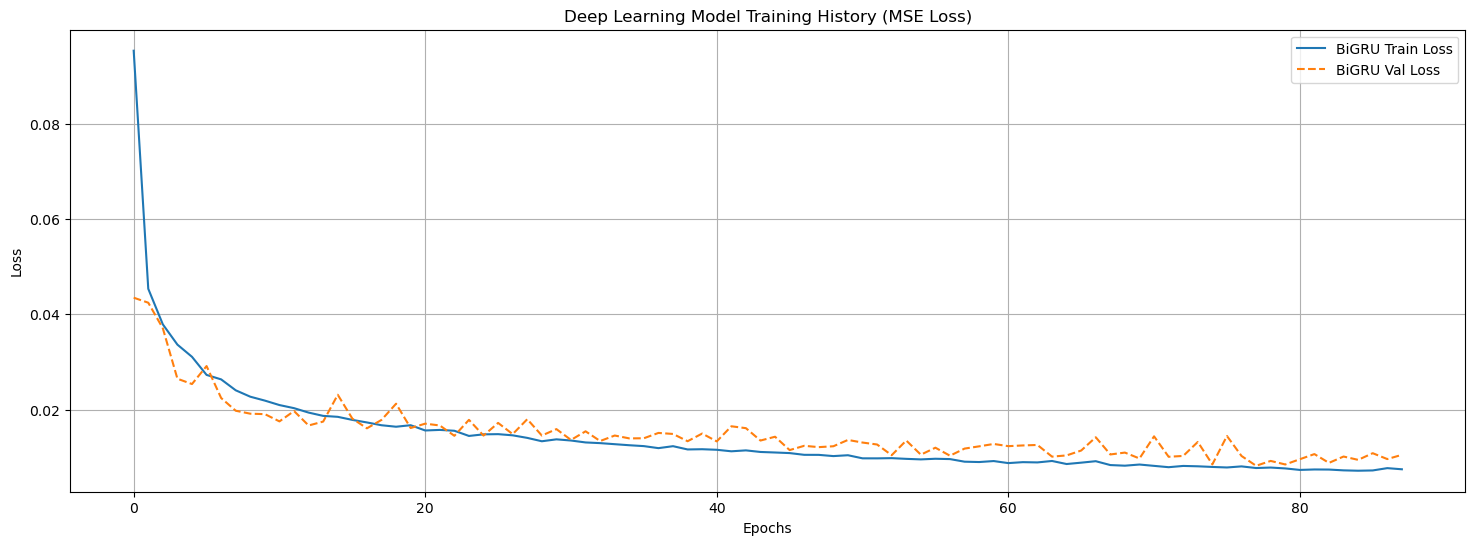

In [120]:
# Call the function
plot_history(
    histories=[history_bigru],
    names=['BiGRU']
)

In [121]:
# Validation predictions
y_val_pred_bigru = bigru_model.predict(X_val_seq)
# Test predictions
y_test_pred_bigru = bigru_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_bigru_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_bigru.flatten()
}, index=idx_val_seq)

test_pred_bigru_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_bigru.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_bigru_rescaled = scaler_y.inverse_transform(val_pred_bigru_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_bigru_df[['y_true']])

y_test_pred_bigru_rescaled = scaler_y.inverse_transform(test_pred_bigru_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_bigru_df[['y_true']])


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [122]:
# --- Evaluate metrics 
metrics_val_bigru = evaluate_predictions(
    y_true=val_pred_bigru_df['y_true'],
    y_pred=val_pred_bigru_df['y_pred'],
    set_name='Validation'
)

metrics_test_bigru = evaluate_predictions(
    y_true=test_pred_bigru_df['y_true'],
    y_pred=test_pred_bigru_df['y_pred'],
    set_name='Test'
)

# Extract RMSE, MAE, R² for test set
rmse_bigru= metrics_test_bigru['RMSE']
mae_bigru  = metrics_test_bigru['MAE']
r2_bigru  = metrics_test_bigru['R2']


# Extract metrics for Validation set
rmse_bigru_val = metrics_val_bigru['RMSE']
mae_bigru_val  = metrics_val_bigru['MAE']
r2_bigru_val   = metrics_val_bigru['R2']


Evaluation Metrics for Validation Set:
MAE: 0.0490
RMSE: 0.0720
R2: 0.8276
Evaluation Metrics for Test Set:
MAE: 0.0638
RMSE: 0.0932
R2: 0.9417


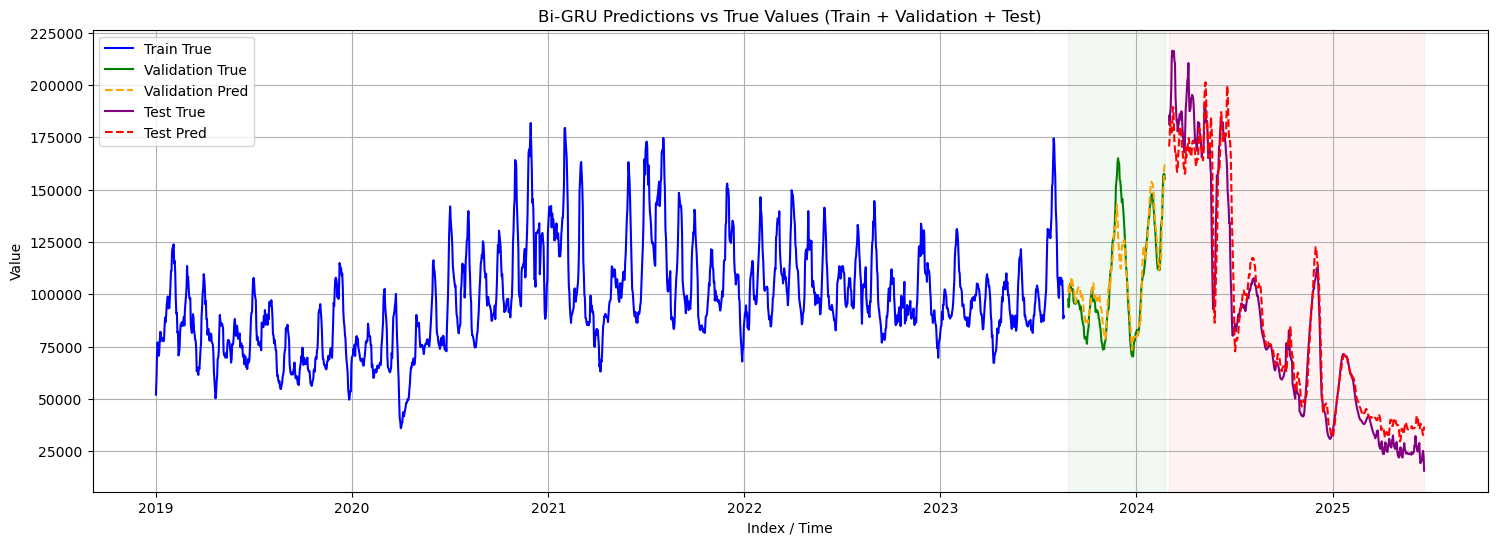

In [123]:
# Plot Bi-GRU predictions with full timeline
plot_predictions_full(
    idx_train=train.index, y_train=train['Value_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_bigru_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_bigru_rescaled,
    title='Bi-GRU Predictions vs True Values (Train + Validation + Test)'
)

# Hybrid Model 

In [124]:
def build_bilstm_bigru_hybrid(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # Single Bi-LSTM layer
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True,
                           kernel_regularizer=l2(l2_reg)), input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # Single Bi-GRU layer
        Bidirectional(GRU(32, activation='tanh', kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate hybrid model with regularization
hybrid_model = build_bilstm_bigru_hybrid(SEQ_LENGTH, n_features, l2_reg=0.0001)
hybrid_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 7, 128)         │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,617 (279.75 KB)

 Trainable params: 71,617 (279.75 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
history_hybrid= hybrid_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.1120 - mae: 0.2234 - val_loss: 0.0513 - val_mae: 0.1287
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0439 - mae: 0.1107 - val_loss: 0.0397 - val_mae: 0.1095
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0358 - mae: 0.0982 - val_loss: 0.0398 - val_mae: 0.1156
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0318 - mae: 0.0954 - val_loss: 0.0337 - val_mae: 0.1026
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0298 - mae: 0.0931 - val_loss: 0.0310 - val_mae: 0.0998
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0264 - mae: 0.0882 - val_loss: 0.0260 - val_mae: 0.0880
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0233 - mae: 0.0800 - val_loss: 0.0229 - val_mae: 0.0840
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0226 - mae: 0.0800 - val_loss: 0.0234 - val_mae: 0.0860
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss:

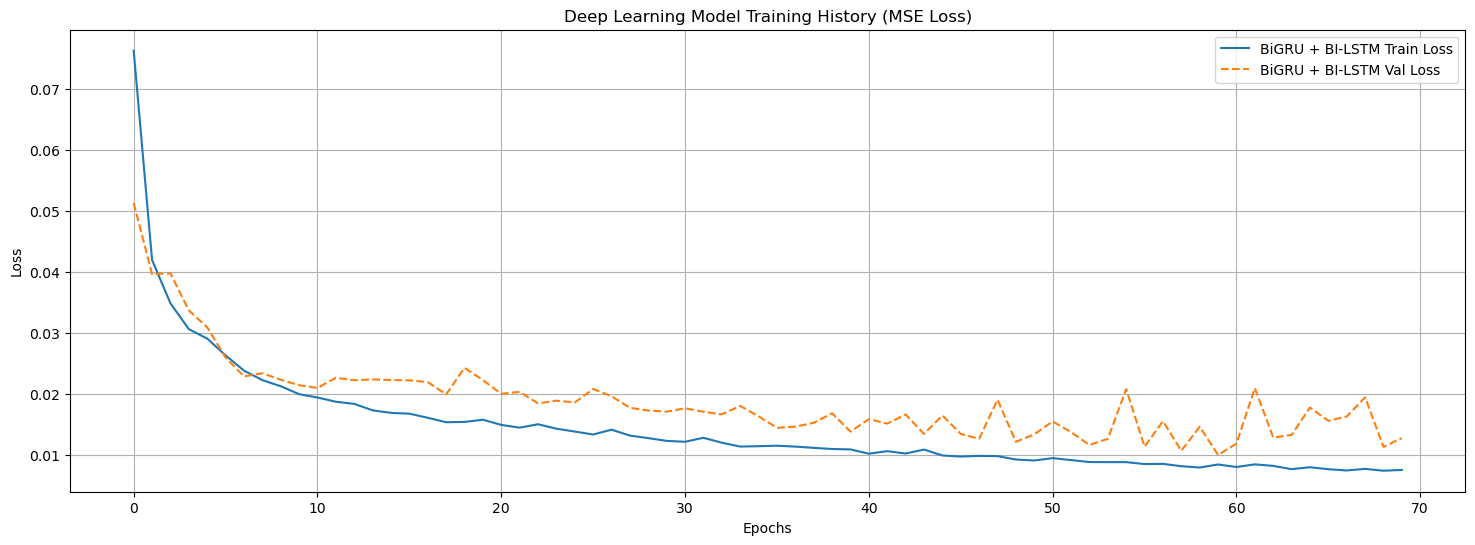

In [126]:
# Call the function
plot_history(
    histories=[history_hybrid],
    names=['BiGRU + BI-LSTM']
)

In [127]:
# --- Predictions ---
# Validation
y_val_pred_hybrid = hybrid_model.predict(X_val_seq, verbose=0)
# Test
y_test_pred_hybrid = hybrid_model.predict(X_test_seq, verbose=0)

# --- Map predictions to DataFrames using original indices ---
val_pred_hybrid_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_hybrid.flatten()
}, index=idx_val_seq)

test_pred_hybrid_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_hybrid.flatten()
}, index=idx_test_seq)

# --- Inverse scaling if target was scaled ---
y_val_pred_hybrid_rescaled = scaler_y.inverse_transform(val_pred_hybrid_df[['y_pred']])
y_val_true_hybrid_rescaled = scaler_y.inverse_transform(val_pred_hybrid_df[['y_true']])

y_test_pred_hybrid_rescaled = scaler_y.inverse_transform(test_pred_hybrid_df[['y_pred']])
y_test_true_hybrid_rescaled = scaler_y.inverse_transform(test_pred_hybrid_df[['y_true']])


In [128]:
# --- Evaluate metrics 
metrics_val_hybrid = evaluate_predictions(
    y_true=val_pred_hybrid_df['y_true'],
    y_pred=val_pred_hybrid_df['y_pred'],
    set_name='Validation'
)

metrics_test_hybrid = evaluate_predictions(
    y_true=test_pred_hybrid_df['y_true'],
    y_pred=test_pred_hybrid_df['y_pred'],
    set_name='Test'
)

# --- Extract metrics for Test set ---
rmse_hybrid = metrics_test_hybrid['RMSE']
mae_hybrid  = metrics_test_hybrid['MAE']
r2_hybrid   = metrics_test_hybrid['R2']

# --- Extract metrics for Validation set ---
rmse_hybrid_val = metrics_val_hybrid['RMSE']
mae_hybrid_val  = metrics_val_hybrid['MAE']
r2_hybrid_val   = metrics_val_hybrid['R2']



Evaluation Metrics for Validation Set:
MAE: 0.0605
RMSE: 0.0830
R2: 0.7710
Evaluation Metrics for Test Set:
MAE: 0.0979
RMSE: 0.1338
R2: 0.8798


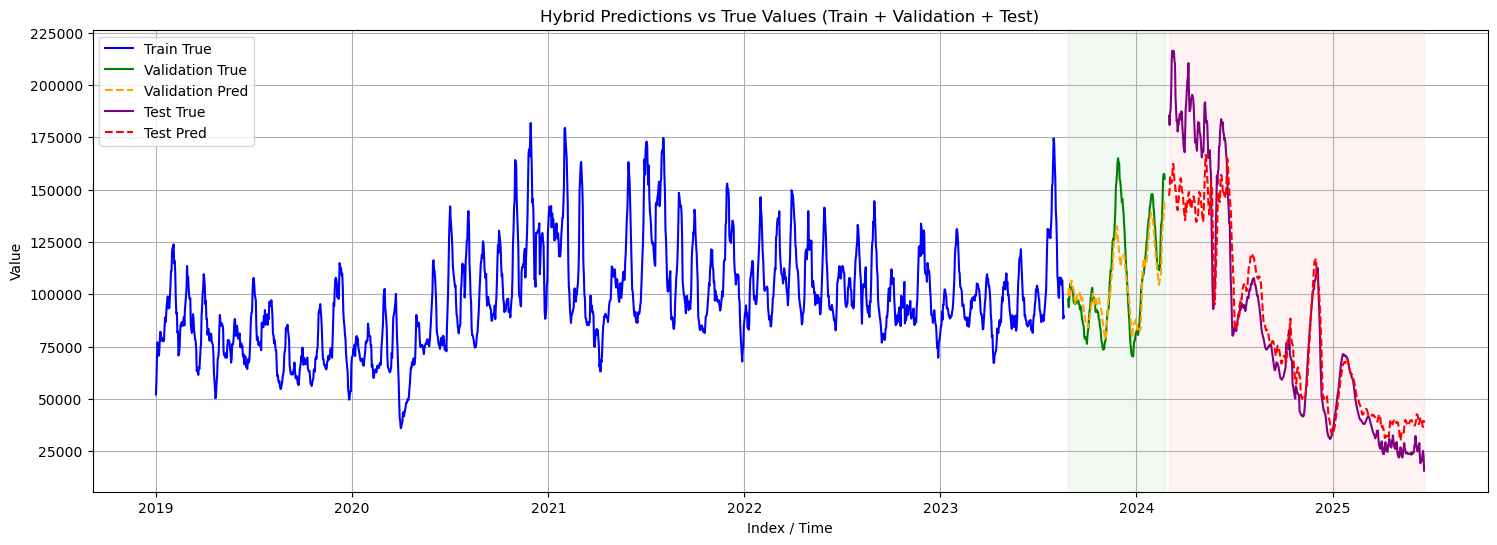

In [129]:
# Plot Bi-GRU predictions with full timeline
plot_predictions_full(
    idx_train=train.index, y_train=train['Value_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_hybrid_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_hybrid_rescaled,
    title='Hybrid Predictions vs True Values (Train + Validation + Test)'
)

In [130]:
# --- Plot actual values ---
fig = go.Figure()

# Actual series
fig.add_trace(go.Scatter(x=train.index, y=scaler_y.inverse_transform(y_train_df).flatten(),
                         mode='lines', name='Train Actual', line=dict(color='black')))
fig.add_trace(go.Scatter(x=val.index, y=scaler_y.inverse_transform(y_val_df).flatten(),
                         mode='lines', name='Val Actual', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=test.index, y=scaler_y.inverse_transform(y_test_df).flatten(),
                         mode='lines', name='Test Actual', line=dict(color='darkgray')))

# --- Validation predictions (lighter, same color as test) ---
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_lstm_rescaled.flatten(),
                         mode='lines', name='LSTM Val Pred', line=dict(color='rgba(0,0,255,0.4)')))       # blue
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_bi_rescaled.flatten(),
                         mode='lines', name='Bi-LSTM Val Pred', line=dict(color='rgba(255,165,0,0.4)')))  # orange
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_gru_rescaled.flatten(),
                         mode='lines', name='GRU Val Pred', line=dict(color='rgba(0,128,0,0.4)')))       # green
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_bigru_rescaled.flatten(),
                         mode='lines', name='Bi-GRU Val Pred', line=dict(color='rgba(128,0,128,0.4)')))   # purple
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_hybrid_rescaled.flatten(),
                         mode='lines', name='Hybrid Val Pred', line=dict(color='rgba(165,42,42,0.4)')))   # brown
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_arimax_rescaled.flatten(),
                         mode='lines', name='SARIMAX Val Pred', line=dict(color='rgba(255,0,0,0.4)')))     # red

# --- Test predictions (solid, same color) ---
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_lstm_rescaled.flatten(),
                         mode='lines', name='LSTM Test Pred', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_bi_rescaled.flatten(),
                         mode='lines', name='Bi-LSTM Test Pred', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_gru_rescaled.flatten(),
                         mode='lines', name='GRU Test Pred', line=dict(color='green')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_bigru_rescaled.flatten(),
                         mode='lines', name='Bi-GRU Test Pred', line=dict(color='purple')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_hybrid_rescaled.flatten(),
                         mode='lines', name='Hybrid Test Pred', line=dict(color='brown')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_arimax_rescaled.flatten(),
                         mode='lines', name='SARIMAX Test Pred', line=dict(color='red')))

# --- Layout ---
fig.update_layout(
    title='Train, Validation, and Test Predictions: SARIMAX & DL Models',
    xaxis_title='Index',
    yaxis_title='Value',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99)
)

fig.show()


# Results

In [131]:
# --- Metrics for Testing set ---
metrics_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU', 'Hybrid'],
    'Dataset': 'Test',
    'RMSE': [rmse_arimax, rmse_lstm, rmse_bilstm, rmse_gru, rmse_bigru, rmse_hybrid],
    'MAE':  [mae_arimax, mae_lstm, mae_bilstm, mae_gru, mae_bigru, mae_hybrid],
    'R²':   [r2_arimax, r2_lstm, r2_bilstm, r2_gru, r2_bigru, r2_hybrid]
})

metrics_df

Model Dataset      RMSE       MAE        R²
0   ARIMAX    Test  0.275051  0.225311  0.494485
1     LSTM    Test  0.179904  0.160060  0.782821
2  Bi-LSTM    Test  0.149444  0.113070  0.850137
3      GRU    Test  0.175361  0.146855  0.793650
4   Bi-GRU    Test  0.093222  0.063823  0.941686
5   Hybrid    Test  0.133836  0.097871  0.879805

In [132]:
# --- Metrics for Validation set ---
metrics_val_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU', 'Hybrid'],
    'Dataset': 'Validation',
    'RMSE': [rmse_arimax_val, rmse_lstm_val, rmse_bilstm_val, rmse_gru_val, rmse_bigru_val, rmse_hybrid_val],
    'MAE':  [mae_arimax_val, mae_lstm_val, mae_bilstm_val, mae_gru_val, mae_bigru_val, mae_hybrid_val],
    'R²':   [r2_arimax_val, r2_lstm_val, r2_bilstm_val, r2_gru_val, r2_bigru_val, r2_hybrid_val]
})

# Display
metrics_val_df

Model     Dataset      RMSE       MAE        R²
0   ARIMAX  Validation  0.129077  0.101356  0.433688
1     LSTM  Validation  0.097987  0.080772  0.680475
2  Bi-LSTM  Validation  0.085620  0.071630  0.756041
3      GRU  Validation  0.093709  0.074698  0.707766
4   Bi-GRU  Validation  0.071971  0.049048  0.827619
5   Hybrid  Validation  0.082958  0.060471  0.770972

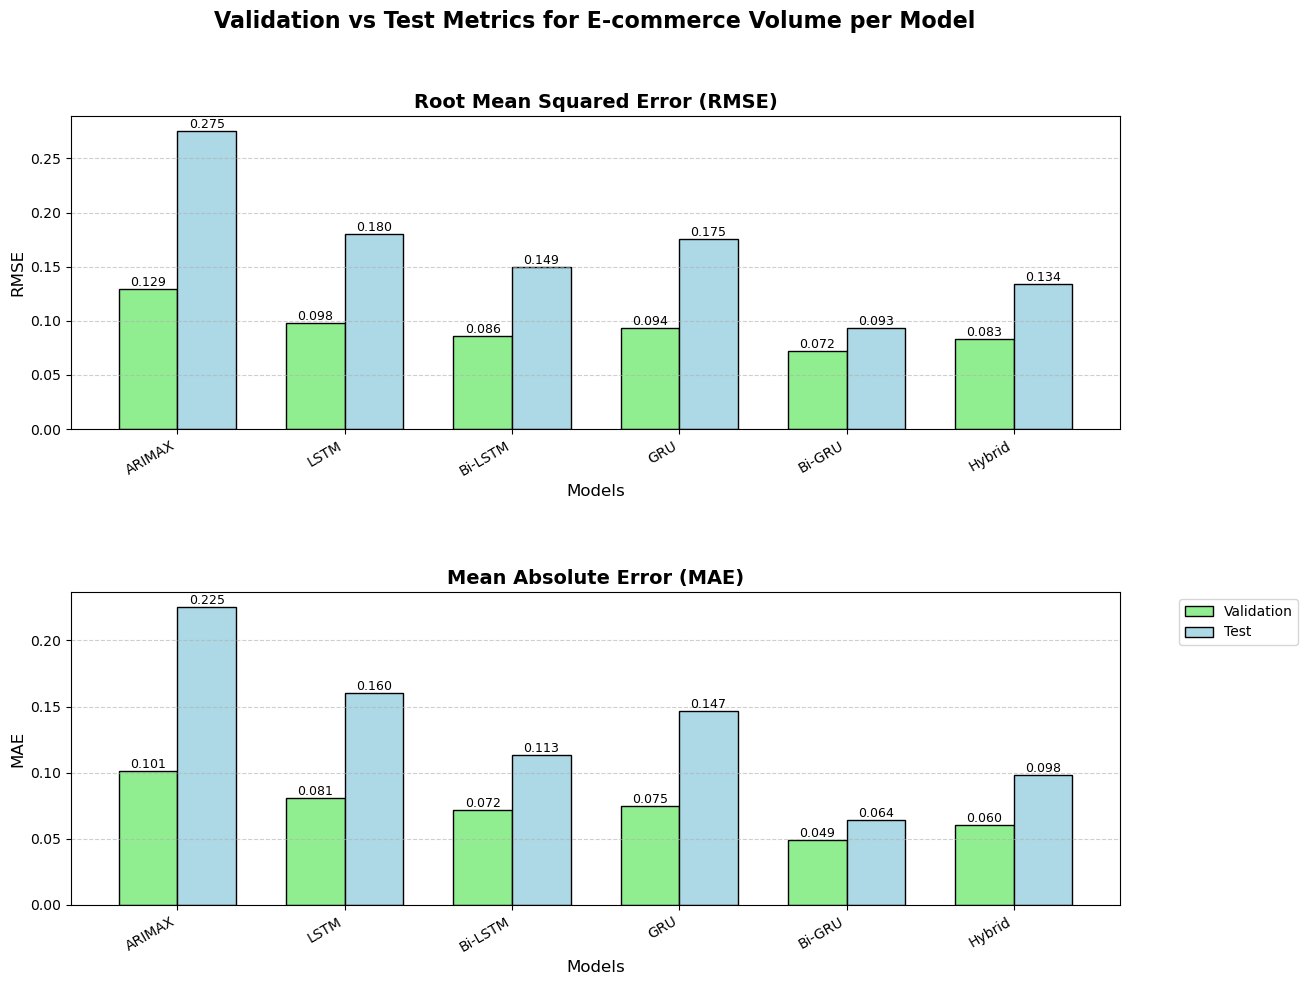

In [133]:
def plot_metrics(metrics_val_df, metrics_test_df):
    models = metrics_val_df['Model']
    metrics_names = ['RMSE', 'MAE']  # remove R²
    titles = ['Root Mean Squared Error (RMSE)', 
              'Mean Absolute Error (MAE)']
    
    width = 0.35
    x = np.arange(len(models))
    
    plt.figure(figsize=(12, 10))  # slightly shorter since only 2 plots
    plt.suptitle('Validation vs Test Metrics for E-commerce Volume per Model', fontsize=16, weight='bold')
    
    for i, metric in enumerate(metrics_names):
        plt.subplot(2, 1, i + 1)
        
        val_values = metrics_val_df[metric]
        test_values = metrics_test_df[metric]
        
        bars_val = plt.bar(x - width/2, val_values, width, label='Validation', color='lightgreen', edgecolor='black')
        bars_test = plt.bar(x + width/2, test_values, width, label='Test', color='lightblue', edgecolor='black')
        
        # Annotate bars
        for bar in bars_val + bars_test:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        plt.title(titles[i], fontsize=14, weight='bold')
        plt.xlabel('Models', fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.xticks(x, models, rotation=30, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    plt.tight_layout(rect=[0, 0, 0.95, 0.95], h_pad=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Call the function
plot_metrics(metrics_val_df, metrics_df)


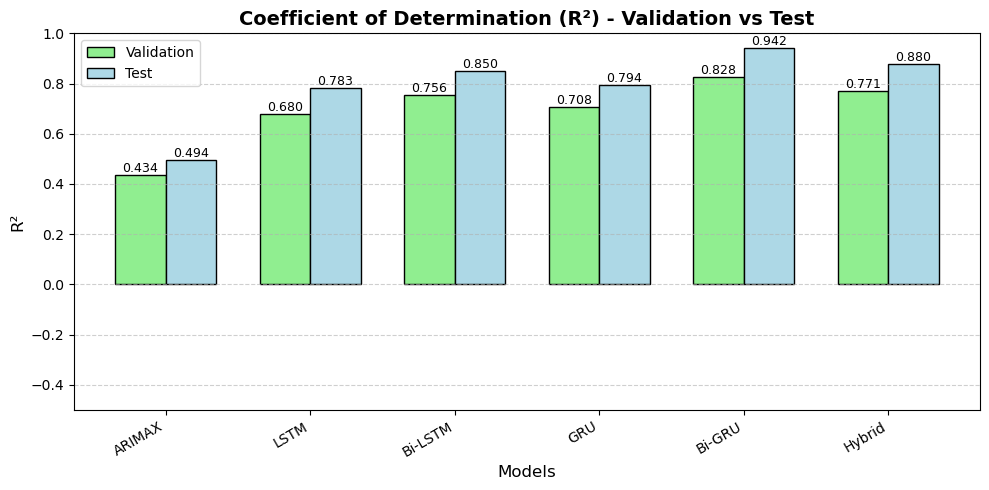

In [134]:
# Models and R² values
models = metrics_val_df['Model']
x = np.arange(len(models))
width = 0.35

# Extract R²
r2_val = metrics_val_df['R²'].astype(float)   # ensure numeric
r2_test = metrics_df['R²'].astype(float)      # ensure numeric

plt.figure(figsize=(10, 5))

# Plot Validation and Test bars
bars_val = plt.bar(x - width/2, r2_val, width, label='Validation', color='lightgreen', edgecolor='black')
bars_test = plt.bar(x + width/2, r2_test, width, label='Test', color='lightblue', edgecolor='black')

# Annotate bars
for bar in bars_val + bars_test:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Titles and labels
plt.title('Coefficient of Determination (R²) - Validation vs Test', fontsize=14, weight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.xticks(x, models, rotation=30, ha='right')
plt.ylim(-0.5, 1)  # accommodate negative R² values
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# walk-forward validation

In [135]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

def walk_forward_sarimax(order, y_train_df, X_train_df, y_val_df, X_val_df, y_test_df, X_test_df):
    """
    Walk-forward validation for SARIMAX.
    """
    # --- Fit model on training set ---
    model = SARIMAX(
        endog=y_train_df,
        exog=X_train_df,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    result = model.fit(method="powell", disp=False)
    
    # --- Forecast validation set ---
    val_forecast = result.get_forecast(steps=len(y_val_df), exog=X_val_df)
    y_val_pred = val_forecast.predicted_mean.values
    
    # --- Forecast test set ---
    full_model = SARIMAX(
        endog=pd.concat([y_train_df, y_val_df]),
        exog=pd.concat([X_train_df, X_val_df]),
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    full_result = full_model.fit(method="powell", disp=False)
    
    test_forecast = full_result.get_forecast(steps=len(y_test_df), exog=X_test_df)
    y_test_pred = test_forecast.predicted_mean.values
    
    # --- Wrap into DataFrames with indices ---
    val_preds_df = pd.DataFrame({
        "y_true": y_val_df.values.flatten(),
        "y_pred": y_val_pred.flatten()
    }, index=y_val_df.index)

    test_preds_df = pd.DataFrame({
        "y_true": y_test_df.values.flatten(),
        "y_pred": y_test_pred.flatten()
    }, index=y_test_df.index)
    
    return val_preds_df, test_preds_df, result


# Sarimax + Validation

In [136]:
# Choose SARIMAX order
sarimax_order = (2,0,1)

# Run walk-forward
val_preds_sarimax, test_preds_sarimax, sarimax_model = walk_forward_sarimax(
    order=sarimax_order,
    y_train_df=y_train_df, X_train_df=X_train_df,
    y_val_df=y_val_df, X_val_df=X_val_df,
    y_test_df=y_test_df, X_test_df=X_test_df
)

# --- Evaluate ---
metrics_val_sarimax = evaluate_predictions(val_preds_sarimax["y_true"], val_preds_sarimax["y_pred"], set_name="Validation")
metrics_test_sarimax = evaluate_predictions(test_preds_sarimax["y_true"], test_preds_sarimax["y_pred"], set_name="Test")

# Extract metrics
rmse_sarimax_val, mae_sarimax_val, r2_sarimax_val = metrics_val_sarimax.values()
rmse_sarimax, mae_sarimax, r2_sarimax = metrics_test_sarimax.values()


c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Evaluation Metrics for Validation Set:
MAE: 0.1380
RMSE: 0.1756
R2: -0.0486
Evaluation Metrics for Test Set:
MAE: 0.1555
RMSE: 0.1931
R2: 0.7509


In [137]:
def walk_forward_corrected(model_fn, 
                          X_train_seq, y_train_seq, 
                          X_val_seq, y_val_seq, 
                          X_test_seq, y_test_seq,
                          seq_length, 
                          epochs=50, batch_size=32, 
                          verbose=0, retrain_frequency=5):
    """
    Corrected walk-forward validation with proper time series handling.
    
    Args:
        retrain_frequency: How often to retrain model (reduces overfitting)
    """
    
    n_features = X_train_seq.shape[2]
    
    # Initialize model once
    model = model_fn(seq_length, n_features)
    
    # Early stopping for initial training only
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=verbose
    )
    
    # --- Initial Training ---
    print("Initial training on base dataset...")
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),  # Use explicit validation
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        callbacks=[early_stop],
        shuffle=False  # CRITICAL: No shuffling for time series
    )
    
    # --- Walk-forward Validation ---
    val_preds = []
    train_X_current = X_train_seq.copy()
    train_y_current = y_train_seq.copy()
    
    for i in range(len(X_val_seq)):
        if verbose > 0:
            print(f"Validation step {i+1}/{len(X_val_seq)}")
        
        # Predict before expanding training set
        y_pred = model.predict(X_val_seq[i:i+1], verbose=0)[0, 0]
        val_preds.append(y_pred)
        
        # Only retrain periodically to prevent overfitting
        if (i % retrain_frequency == 0) or (i == len(X_val_seq) - 1):
            if verbose > 0:
                print(f"Retraining model at step {i}...")
            
            # Expand training window
            train_X_current = np.vstack([train_X_current, X_val_seq[:i+1]])
            train_y_current = np.vstack([train_y_current, y_val_seq[:i+1]])
            
            # Retrain with very few epochs to adapt gradually
            model.fit(
                train_X_current, train_y_current,
                epochs=3,  # Few epochs to prevent overfitting
                batch_size=batch_size,
                verbose=0,
                shuffle=False
            )
    
    val_preds = np.array(val_preds)
    
    # --- Walk-forward Test ---
    test_preds = []
    
    # Include validation data in final training
    train_X_final = np.vstack([X_train_seq, X_val_seq])
    train_y_final = np.vstack([y_train_seq, y_val_seq])
    
    # Final training before test
    model.fit(
        train_X_final, train_y_final,
        epochs=10,  # Final tuning
        batch_size=batch_size,
        verbose=verbose,
        shuffle=False
    )
    
    # Test walk-forward (usually you wouldn't retrain during test in real scenarios)
    for i in range(len(X_test_seq)):
        y_pred = model.predict(X_test_seq[i:i+1], verbose=0)[0, 0]
        test_preds.append(y_pred)
        
        # In real testing, you typically don't retrain on test data
        # This maintains the integrity of your test set evaluation
    
    test_preds = np.array(test_preds)
    
    # Calculate metrics
    val_metrics = {
        "RMSE": np.sqrt(mean_squared_error(y_val_seq, val_preds)),
        "MAE": mean_absolute_error(y_val_seq, val_preds),
        "R2": r2_score(y_val_seq, val_preds),
        "MAPE": np.mean(np.abs((y_val_seq - val_preds) / y_val_seq)) * 100
    }
    
    test_metrics = {
        "RMSE": np.sqrt(mean_squared_error(y_test_seq, test_preds)),
        "MAE": mean_absolute_error(y_test_seq, test_preds),
        "R2": r2_score(y_test_seq, test_preds),
        "MAPE": np.mean(np.abs((y_test_seq - test_preds) / y_test_seq)) * 100
    }
    
    return {
        "Validation": {"metrics": val_metrics, "preds": val_preds},
        "Test": {"metrics": test_metrics, "preds": test_preds},
        "model": model,
        "final_train_size": train_X_final.shape[0]
    }

In [138]:
def walk_forward_named(model_name, model_fn,
                       X_train_seq, y_train_seq,
                       X_val_seq, y_val_seq,
                       X_test_seq, y_test_seq,
                       seq_length,
                       epochs=50, batch_size=32,
                       retrain_frequency=5, verbose=0):
    """
    Walk-forward validation + test with automatic named metrics.

    Returns:
        metrics_df: DataFrame with Validation & Test metrics
        val_preds: array of validation predictions
        test_preds: array of test predictions
        trained_model: final trained model
        metrics_named: dict with named metrics (e.g., rmse_lstm_val)
    """
    results = walk_forward_corrected(
        model_fn=model_fn,
        X_train_seq=X_train_seq, y_train_seq=y_train_seq,
        X_val_seq=X_val_seq, y_val_seq=y_val_seq,
        X_test_seq=X_test_seq, y_test_seq=y_test_seq,
        seq_length=seq_length,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose
    )

    val_metrics = results["Validation"]["metrics"]
    test_metrics = results["Test"]["metrics"]
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame([
        {
            "Model": model_name,
            "Dataset": "Validation",
            "RMSE": val_metrics["RMSE"],
            "MAE": val_metrics["MAE"],
            "R2": val_metrics["R2"],
            "MAPE": val_metrics.get("MAPE", np.nan)
        },
        {
            "Model": model_name,
            "Dataset": "Test",
            "RMSE": test_metrics["RMSE"],
            "MAE": test_metrics["MAE"],
            "R2": test_metrics["R2"],
            "MAPE": test_metrics.get("MAPE", np.nan)
        }
    ])

    # Create named metrics for easy access
    prefix = model_name.lower().replace("-", "_")
    metrics_named = {
        f"rmse_{prefix}_val": val_metrics["RMSE"],
        f"mae_{prefix}_val": val_metrics["MAE"],
        f"r2_{prefix}_val": val_metrics["R2"],
        f"rmse_{prefix}_test": test_metrics["RMSE"],
        f"mae_{prefix}_test": test_metrics["MAE"],
        f"r2_{prefix}_test": test_metrics["R2"]
    }
    
    return metrics_df, results["Validation"]["preds"], results["Test"]["preds"], results["model"], metrics_named


# a. LSTM + Validation

In [139]:
metrics_df_lstm, val_preds_lstm, test_preds_lstm, model_lstm, metrics_named_lstm = walk_forward_named(
    model_name="LSTM",
    model_fn=build_lstm,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_lstm)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0490 - mae: 0.1522 - val_loss: 0.0674 - val_mae: 0.1991
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0348 - mae: 0.1173 - val_loss: 0.0334 - val_mae: 0.1184
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0402 - mae: 0.1337 - val_loss: 0.0266 - val_mae: 0.1021
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0659 - mae: 0.1980 - val_loss: 0.0275 - val_mae: 0.1060
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0316 - mae: 0.1212 - val_loss: 0.0342 - val_mae: 0.1223
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0279 - mae: 0.1125 - val_loss: 0.0350 - val_mae: 0.1254
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0236 - mae: 0.0945 - val_loss: 0.0273 - val_mae: 0.1081
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0267 - mae: 0.1085 - val_loss: 0.0271 - val_mae: 0.1086
Epoch 8: early stopping
Res

In [140]:
# --- Extract LSTM metrics from metrics_named_lstm ---
rmse_lstm_val = metrics_named_lstm['rmse_lstm_val']
mae_lstm_val  = metrics_named_lstm['mae_lstm_val']
r2_lstm_val   = metrics_named_lstm['r2_lstm_val']

rmse_lstm     = metrics_named_lstm['rmse_lstm_test']
mae_lstm      = metrics_named_lstm['mae_lstm_test']
r2_lstm       = metrics_named_lstm['r2_lstm_test']

# print metrics
print(f"Validation - RMSE: {rmse_lstm_val:.4f}, MAE: {mae_lstm_val:.4f}, R2: {r2_lstm_val:.4f}")
print(f"Test       - RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}, R2: {r2_lstm:.4f}")


Validation - RMSE: 0.1023, MAE: 0.0745, R2: 0.6515
Test       - RMSE: 0.1004, MAE: 0.0830, R2: 0.9324


# Bi-LSTM + validation

In [141]:
metrics_df_bilstm, val_preds_bilstm, test_preds_bilstm, model_bilstm, metrics_named_bilstm = walk_forward_named(
    model_name="BI-LSTM",
    model_fn=build_bilstm,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_bilstm)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.1020 - mae: 0.2055 - val_loss: 0.0755 - val_mae: 0.1745
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0721 - mae: 0.1739 - val_loss: 0.0545 - val_mae: 0.1319
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0470 - mae: 0.1066 - val_loss: 0.0376 - val_mae: 0.0944
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0992 - mae: 0.2345 - val_loss: 0.0382 - val_mae: 0.1025
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0428 - mae: 0.1146 - val_loss: 0.0461 - val_mae: 0.1248
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0408 - mae: 0.1200 - val_loss: 0.0481 - val_mae: 0.1330
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0329 - mae: 0.0884 - val_loss: 0.0367 - val_mae: 0.1087
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0387 - mae: 0.1184 - val_loss: 0.0338 - val_mae: 0.1042
Epoch 9/100
27/27 ━━

In [142]:
# --- Extract Bi-LSTM metrics from metrics_named_bilstm ---
rmse_bi_lstm_val = metrics_named_bilstm['rmse_bi_lstm_val']
mae_bi_lstm_val  = metrics_named_bilstm['mae_bi_lstm_val']
r2_bi_lstm_val   = metrics_named_bilstm['r2_bi_lstm_val']

rmse_bi_lstm    = metrics_named_bilstm['rmse_bi_lstm_test']
mae_bi_lstm      = metrics_named_bilstm['mae_bi_lstm_test']
r2_bi_lstm       = metrics_named_bilstm['r2_bi_lstm_test']

# print metrics
print(f"Validation - RMSE: {rmse_bi_lstm_val:.4f}, MAE: {mae_bi_lstm_val:.4f}, R2: {r2_bi_lstm_val:.4f}")
print(f"Test       - RMSE: {rmse_bi_lstm:.4f}, MAE: {mae_bi_lstm:.4f}, R2: {r2_bi_lstm:.4f}")


Validation - RMSE: 0.0975, MAE: 0.0723, R2: 0.6834
Test       - RMSE: 0.1439, MAE: 0.1225, R2: 0.8610


# GRU + Validation

In [143]:
metrics_df_gru, val_preds_gru, test_preds_gru, model_gru, metrics_named_gru = walk_forward_named(
    model_name="gru",
    model_fn=build_gru,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_gru)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0726 - mae: 0.1971 - val_loss: 0.0355 - val_mae: 0.1223
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0568 - mae: 0.1682 - val_loss: 0.0308 - val_mae: 0.1221
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0831 - mae: 0.2275 - val_loss: 0.0237 - val_mae: 0.1015
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0611 - mae: 0.1894 - val_loss: 0.0230 - val_mae: 0.0960
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0458 - mae: 0.1614 - val_loss: 0.0311 - val_mae: 0.1196
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0267 - mae: 0.1060 - val_loss: 0.0230 - val_mae: 0.0980
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0290 - mae: 0.1189 - val_loss: 0.0212 - val_mae: 0.0944
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0249 - mae: 0.1079 - val_loss: 0.0222 - val_mae: 0.0993
Epoch 9/100
27/27 ━━━━━━━━

In [144]:
# --- Extract GRU metrics from metrics_named_gru ---
rmse_gru_val = metrics_named_gru['rmse_gru_val']
mae_gru_val  = metrics_named_gru['mae_gru_val']
r2_gru_val   = metrics_named_gru['r2_gru_val']

rmse_gru     = metrics_named_gru['rmse_gru_test']
mae_gru      = metrics_named_gru['mae_gru_test']
r2_gru       = metrics_named_gru['r2_gru_test']

# print metrics
print(f"Validation - RMSE: {rmse_gru_val:.4f}, MAE: {mae_gru_val:.4f}, R2: {r2_gru_val:.4f}")
print(f"Test       - RMSE: {rmse_gru:.4f}, MAE: {mae_gru:.4f}, R2: {r2_gru:.4f}")


Validation - RMSE: 0.0885, MAE: 0.0659, R2: 0.7394
Test       - RMSE: 0.0781, MAE: 0.0489, R2: 0.9591


# BIGRU + Validation

In [145]:
metrics_df_bigru, val_preds_bigru, test_preds_bigru, model_bigru, metrics_named_bigru = walk_forward_named(
    model_name="BI-GRU",
    model_fn=build_bigru,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_bigru)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1364 - mae: 0.2602 - val_loss: 0.0667 - val_mae: 0.1650
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0535 - mae: 0.1354 - val_loss: 0.0362 - val_mae: 0.0925
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0657 - mae: 0.1673 - val_loss: 0.0379 - val_mae: 0.1033
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1126 - mae: 0.2489 - val_loss: 0.0569 - val_mae: 0.1674
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0506 - mae: 0.1396 - val_loss: 0.0248 - val_mae: 0.0676
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1253 - mae: 0.2700 - val_loss: 0.0883 - val_mae: 0.2358
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0601 - mae: 0.1781 - val_loss: 0.0730 - val_mae: 0.2012
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0486 - mae: 0.1530 - val_loss: 0.0485 - val_mae: 0.1410
Epoch 9/100
27/27 ━━━━━━━━

In [146]:
# Extract metrics from metrics_named_bigru
rmse_bi_gru_val = metrics_named_bigru['rmse_bi_gru_val']
mae_bi_gru_val  = metrics_named_bigru['mae_bi_gru_val']
r2_bi_gru_val   = metrics_named_bigru['r2_bi_gru_val']

rmse_bi_gru     = metrics_named_bigru['rmse_bi_gru_test']
mae_bi_gru      = metrics_named_bigru['mae_bi_gru_test']
r2_bi_gru       = metrics_named_bigru['r2_bi_gru_test']

# Print metrics
print(f"Bi-GRU Validation - RMSE: {rmse_bi_gru_val:.4f}, MAE: {mae_bi_gru_val:.4f}, R2: {r2_bi_gru_val:.4f}")
print(f"Bi-GRU Test       - RMSE: {rmse_bi_gru:.4f}, MAE: {mae_bi_gru:.4f}, R2: {r2_bi_gru:.4f}")


Bi-GRU Validation - RMSE: 0.1019, MAE: 0.0661, R2: 0.6544
Bi-GRU Test       - RMSE: 0.1531, MAE: 0.1237, R2: 0.8427


# hybrid + Validation

In [147]:
metrics_df_hybrid, val_preds_hybrid, test_preds_hybrid, model_hybrid, metrics_named_hybrid = walk_forward_named(
    model_name=" hybrid",
    model_fn= build_bilstm_bigru_hybrid,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_hybrid)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0743 - mae: 0.1740 - val_loss: 0.0514 - val_mae: 0.1276
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0471 - mae: 0.1199 - val_loss: 0.0479 - val_mae: 0.1324
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0447 - mae: 0.1234 - val_loss: 0.0326 - val_mae: 0.0949
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1413 - mae: 0.2939 - val_loss: 0.0325 - val_mae: 0.1002
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0628 - mae: 0.1834 - val_loss: 0.0333 - val_mae: 0.1059
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0429 - mae: 0.1313 - val_loss: 0.0411 - val_mae: 0.1275
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0450 - mae: 0.1502 - val_loss: 0.0419 - val_mae: 0.1302
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0285 - mae: 0.0912 - val_loss: 0.0323 - val_mae: 0.1090
Epoch 9/100
27/27 ━━━━━━

In [148]:
# --- Extract Hybrid model metrics from metrics_named_hybrid ---
rmse_hybrid_val = metrics_named_hybrid['rmse_ hybrid_val']
mae_hybrid_val  = metrics_named_hybrid['mae_ hybrid_val']
r2_hybrid_val   = metrics_named_hybrid['r2_ hybrid_val']

rmse_hybrid     = metrics_named_hybrid['rmse_ hybrid_test']
mae_hybrid      = metrics_named_hybrid['mae_ hybrid_test']
r2_hybrid       = metrics_named_hybrid['r2_ hybrid_test']

# print metrics
print(f"Validation - RMSE: {rmse_hybrid_val:.4f}, MAE: {mae_hybrid_val:.4f}, R2: {r2_hybrid_val:.4f}")
print(f"Test       - RMSE: {rmse_hybrid:.4f}, MAE: {mae_hybrid:.4f}, R2: {r2_hybrid:.4f}")


Validation - RMSE: 0.0900, MAE: 0.0630, R2: 0.7303
Test       - RMSE: 0.1081, MAE: 0.0842, R2: 0.9216


In [149]:
# --- Compile results for all models with updated Bi-GRU metrics ---
metrics_df = pd.DataFrame([
    {"Model": "LSTM",    "RMSE_Val": rmse_lstm_val,    "MAE_Val": mae_lstm_val,    "R2_Val": r2_lstm_val,
                          "RMSE_Test": rmse_lstm,       "MAE_Test": mae_lstm,       "R2_Test": r2_lstm},

    {"Model": "Bi-LSTM", "RMSE_Val": rmse_bi_lstm_val, "MAE_Val": mae_bi_lstm_val, "R2_Val": r2_bi_lstm_val,
                          "RMSE_Test": rmse_bi_lstm,    "MAE_Test": mae_bi_lstm,    "R2_Test": r2_bi_lstm},

    {"Model": "GRU",     "RMSE_Val": rmse_gru_val,    "MAE_Val": mae_gru_val,    "R2_Val": r2_gru_val,
                          "RMSE_Test": rmse_gru,       "MAE_Test": mae_gru,       "R2_Test": r2_gru},

    {"Model": "Bi-GRU",  "RMSE_Val": rmse_bi_gru_val, "MAE_Val": mae_bi_gru_val, "R2_Val": r2_bi_gru_val,
                          "RMSE_Test": rmse_bi_gru,    "MAE_Test": mae_bi_gru,    "R2_Test": r2_bi_gru},

    {"Model": "Hybrid",  "RMSE_Val": rmse_hybrid_val, "MAE_Val": mae_hybrid_val, "R2_Val": r2_hybrid_val,
                          "RMSE_Test": rmse_hybrid,    "MAE_Test": mae_hybrid,    "R2_Test": r2_hybrid},

    {"Model": "SARIMAX", "RMSE_Val": rmse_sarimax_val, "MAE_Val": mae_sarimax_val, "R2_Val": r2_sarimax_val,
                          "RMSE_Test": rmse_sarimax,    "MAE_Test": mae_sarimax,    "R2_Test": r2_sarimax}
])

# Display the updated metrics
metrics_df


Model  RMSE_Val   MAE_Val    R2_Val  RMSE_Test  MAE_Test   R2_Test
0     LSTM  0.102331  0.074509  0.651519   0.100400  0.083003  0.932360
1  Bi-LSTM  0.097538  0.072261  0.683395   0.143917  0.122536  0.861018
2      GRU  0.088484  0.065925  0.739446   0.078101  0.048919  0.959069
3   Bi-GRU  0.101899  0.066137  0.654449   0.153093  0.123712  0.842728
4   Hybrid  0.090028  0.062958  0.730273   0.108096  0.084157  0.921593
5  SARIMAX  0.138028  0.175644 -0.048627   0.155483  0.193097  0.750852

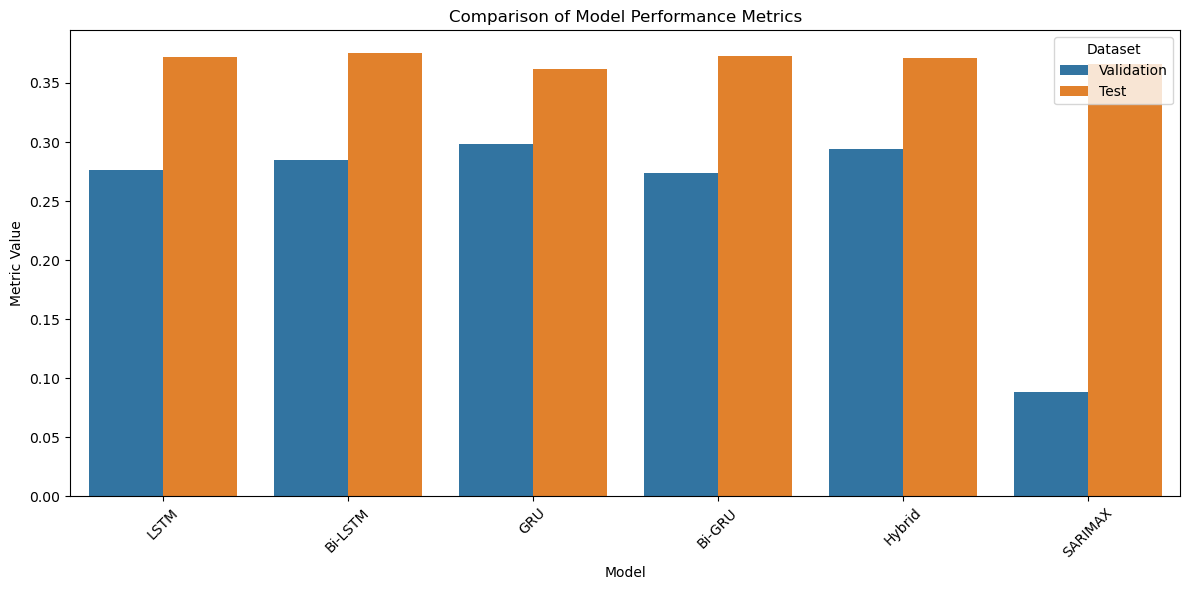

In [ ]:
# --- Melt the DataFrame for seaborn ---
metrics_long = metrics_df.melt(
    id_vars='Model', 
    value_vars=['RMSE_Val', 'MAE_Val', 'R2_Val', 'RMSE_Test', 'MAE_Test', 'R2_Test'],
    var_name='Metric', 
    value_name='Value'
)

# --- Add dataset column ---
metrics_long['Dataset'] = metrics_long['Metric'].apply(lambda x: 'Validation' if '_Val' in x else 'Test')
metrics_long['Metric'] = (
    metrics_long['Metric']
    .str.replace('_Val', '', regex=False)
    .str.replace('_Test', '', regex=False)
)

# --- Plot separate figures for each metric ---
metrics = ['RMSE', 'MAE', 'R2']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=metrics_long[metrics_long['Metric'] == metric],
        x='Model', 
        y='Value', 
        hue='Dataset', 
        ci=None
    )
    plt.title(f'Model Comparison: {metric}', fontsize=14)
    plt.ylabel(f'{metric} Value')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()


# Forecasting 

In [151]:
# --- Concatenate all historical data ---
y_full = pd.concat([y_train_df, y_val_df, y_test_df])
y_full_rescaled = scaler_y.inverse_transform(y_full.values.reshape(-1,1)).flatten()

# --- Create date index ---
full_dates = pd.date_range(start=y_train_df.index[0], end=y_test_df.index[-1], freq='D')

# --- Parameters ---
future_steps = 30
last_sequence = X_test_seq[-1]
predictions_future = []

# --- Walk-forward prediction ---
current_seq = last_sequence.copy()
for _ in range(future_steps):
    next_pred = model_gru.predict(current_seq[np.newaxis, :, :], verbose=0)[0, 0]
    predictions_future.append(next_pred)
    current_seq = np.roll(current_seq, -1)
    current_seq[-1, 0] = next_pred

# --- Rescale forecast ---
predictions_future_rescaled = scaler_y.inverse_transform(np.array(predictions_future).reshape(-1,1)).flatten()

# --- Future date index ---
future_dates = pd.date_range(start=y_test_df.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Calculate indices for different phases
train_end = len(y_train_df)
val_end = train_end + len(y_val_df)
historical_end = len(y_full_rescaled)

# --- Create interactive subplots with Plotly ---
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(
        'GRU Model: Complete Historical Data and Forecast',
        'Zoomed View: Validation + Test + Forecast Periods'
    ),
    vertical_spacing=0.1,
    specs=[[{"secondary_y": False}], [{"secondary_y": False}]]
)

# ---  Full historical view ---
# Training data
fig.add_trace(
    go.Scatter(
        x=full_dates[:train_end],
        y=y_full_rescaled[:train_end],
        name='Training Data',
        line=dict(color='#1f77b4', width=2),
        opacity=0.7,
        hovertemplate='<b>Training</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Validation data
fig.add_trace(
    go.Scatter(
        x=full_dates[train_end:val_end],
        y=y_full_rescaled[train_end:val_end],
        name='Validation Data',
        line=dict(color='#ff7f0e', width=2),
        opacity=0.7,
        hovertemplate='<b>Validation</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Test data
fig.add_trace(
    go.Scatter(
        x=full_dates[val_end:historical_end],
        y=y_full_rescaled[val_end:historical_end],
        name='Test Data',
        line=dict(color='#2ca02c', width=3),
        opacity=0.9,
        hovertemplate='<b>Test</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Forecast data
fig.add_trace(
    go.Scatter(
        x=future_dates,
        y=predictions_future_rescaled,
        name=f'GRU Forecast ({future_steps} days)',
        line=dict(color='#d62728', width=3),
        mode='lines+markers',
        marker=dict(size=4),
        hovertemplate='<b>Forecast</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Add vertical lines for phase separators
fig.add_vline(
    x=full_dates[train_end], 
    line_dash="dash", 
    line_color="gray", 
    line_width=1,
    opacity=0.7,
    row=1, col=1
)

fig.add_vline(
    x=full_dates[val_end], 
    line_dash="dash", 
    line_color="gray", 
    line_width=1,
    opacity=0.7,
    row=1, col=1
)

fig.add_vline(
    x=full_dates[historical_end-1], 
    line_dash="solid", 
    line_color="red", 
    line_width=2,
    opacity=0.8,
    row=1, col=1
)

# --- Plot 2: Zoomed-in view (Validation + Test + Forecast) ---
# Determine windows for zoomed view
val_window = min(30, len(y_val_df))
test_window = min(30, len(y_test_df))

val_start_idx = val_end - val_window
test_start_idx = historical_end - test_window

# Validation data (zoomed)
val_dates_zoom = full_dates[val_start_idx:val_end]
val_values_zoom = y_full_rescaled[val_start_idx:val_end]

# Test data (zoomed)
test_dates_zoom = full_dates[val_end:historical_end]
test_values_zoom = y_full_rescaled[val_end:historical_end]

# Plot validation data (zoomed)
fig.add_trace(
    go.Scatter(
        x=val_dates_zoom,
        y=val_values_zoom,
        name=f'Validation (Last {val_window} days)',
        line=dict(color='#ff7f0e', width=3),
        mode='lines+markers',
        marker=dict(size=5, symbol='triangle-up'),
        opacity=0.9,
        hovertemplate='<b>Validation</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Plot test data (zoomed)
fig.add_trace(
    go.Scatter(
        x=test_dates_zoom,
        y=test_values_zoom,
        name=f'Test Data ({len(test_values_zoom)} days)',
        line=dict(color='#2ca02c', width=3),
        mode='lines+markers',
        marker=dict(size=5, symbol='square'),
        opacity=0.9,
        hovertemplate='<b>Test</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Plot forecast (zoomed)
fig.add_trace(
    go.Scatter(
        x=future_dates,
        y=predictions_future_rescaled,
        name=f'Forecast ({future_steps} days)',
        line=dict(color='#d62728', width=4),
        mode='lines+markers',
        marker=dict(size=6, symbol='circle'),
        hovertemplate='<b>Forecast</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Add key transition points with annotations
last_val_value = y_full_rescaled[val_end-1]
first_test_value = y_full_rescaled[val_end]
last_test_value = y_full_rescaled[historical_end-1]
first_forecast_value = predictions_future_rescaled[0]

# Key points for zoomed view
key_points = [
    (full_dates[val_end-1], last_val_value, 'Last Validation', '#ff7f0e'),
    (full_dates[val_end], first_test_value, 'First Test', '#2ca02c'),
    (full_dates[historical_end-1], last_test_value, 'Last Test', '#2ca02c'),
    (future_dates[0], first_forecast_value, 'First Forecast', '#d62728')
]

for date, value, name, color in key_points:
    fig.add_trace(
        go.Scatter(
            x=[date],
            y=[value],
            name=name,
            mode='markers',
            marker=dict(size=10, color=color, symbol='diamond'),
            hovertemplate=f'<b>{name}</b><br>Date: %{{x|%Y-%m-%d}}<br>Value: %{{y:.2f}}<extra></extra>',
            showlegend=True
        ),
        row=2, col=1
    )

# Add vertical lines for zoomed view
fig.add_vline(
    x=full_dates[val_end], 
    line_dash="dash", 
    line_color="gray", 
    line_width=2,
    opacity=0.8,
    row=2, col=1
)

fig.add_vline(
    x=full_dates[historical_end-1], 
    line_dash="solid", 
    line_color="red", 
    line_width=3,
    opacity=0.8,
    row=2, col=1
)

# --- Update layout for better appearance ---
fig.update_layout(
    height=1000,
    title_text=" GRU Model Forecasting Analysis\n",
    title_x=0.5,
    title_font=dict(size=24, color='darkblue'),
    template='plotly_white',
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Update x-axis properties
fig.update_xaxes(
    title_text="Date",
    tickformat="%Y-%m-%d",
    tickangle=45,
    row=1, col=1
)

fig.update_xaxes(
    title_text="Date",
    tickformat="%Y-%m-%d",
    tickangle=45,
    row=2, col=1
)

# Update y-axis properties
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Value", row=2, col=1)

# Add annotations for transitions
val_test_change = ((first_test_value - last_val_value) / last_val_value * 100)
test_forecast_change = ((first_forecast_value - last_test_value) / last_test_value * 100)

fig.add_annotation(
    x=full_dates[val_end],
    y=(first_test_value + last_val_value) / 2,
    text=f"Δ = {val_test_change:+.1f}%",
    showarrow=True,
    arrowhead=2,
    ax=50,
    ay=0,
    bgcolor="orange",
    opacity=0.8,
    row=2, col=1
)

fig.add_annotation(
    x=future_dates[0],
    y=(first_forecast_value + last_test_value) / 2,
    text=f"Δ = {test_forecast_change:+.1f}%",
    showarrow=True,
    arrowhead=2,
    ax=50,
    ay=0,
    bgcolor="red",
    opacity=0.8,
    row=2, col=1
)

# Show the plot
fig.show()

# --- Additional interactive statistics display ---
print(f"\n{'='*80}")
print(f"INTERACTIVE FORECASTING SUMMARY")
print(f"{'='*80}")
print(f"    Model Performance Overview:")
print(f"   • Validation Period: {val_dates_zoom[0].strftime('%Y-%m-%d')} to {val_dates_zoom[-1].strftime('%Y-%m-%d')}")
print(f"   • Test Period: {test_dates_zoom[0].strftime('%Y-%m-%d')} to {test_dates_zoom[-1].strftime('%Y-%m-%d')}")
print(f"   • Forecast Period: {future_dates[0].strftime('%Y-%m-%d')} to {future_dates[-1].strftime('%Y-%m-%d')}")

print(f"\n  Key Statistics:")
print(f"   • Validation Range: {val_values_zoom.min():.2f} - {val_values_zoom.max():.2f}")
print(f"   • Test Range: {test_values_zoom.min():.2f} - {test_values_zoom.max():.2f}")
print(f"   • Forecast Range: {predictions_future_rescaled.min():.2f} - {predictions_future_rescaled.max():.2f}")

print(f"\n  Transition Analysis:")
print(f"   • Validation → Test: {val_test_change:+.2f}%")
print(f"   • Test → Forecast: {test_forecast_change:+.2f}%")
print(f"   • Overall Trend: {((predictions_future_rescaled[-1] - val_values_zoom[0]) / val_values_zoom[0] * 100):+.2f}%")

print(f"{'='*80}")

# Create a summary DataFrame for additional analysis
summary_df = pd.DataFrame({
    'Phase': ['Validation', 'Test', 'Forecast'],
    'Start_Date': [val_dates_zoom[0], test_dates_zoom[0], future_dates[0]],
    'End_Date': [val_dates_zoom[-1], test_dates_zoom[-1], future_dates[-1]],
    'Min_Value': [val_values_zoom.min(), test_values_zoom.min(), predictions_future_rescaled.min()],
    'Max_Value': [val_values_zoom.max(), test_values_zoom.max(), predictions_future_rescaled.max()],
    'Mean_Value': [val_values_zoom.mean(), test_values_zoom.mean(), predictions_future_rescaled.mean()]
})

print("\n" + summary_df.to_string(index=False))


INTERACTIVE FORECASTING SUMMARY
    Model Performance Overview:
   • Validation Period: 2024-01-25 to 2024-02-23
   • Test Period: 2024-02-24 to 2025-06-08
   • Forecast Period: 2025-06-21 to 2025-07-20

  Key Statistics:
   • Validation Range: 111486.11 - 157551.03
   • Test Range: 15732.60 - 216406.26
   • Forecast Range: 23523.57 - 258124.97

  Transition Analysis:
   • Validation → Test: -43.01%
   • Test → Forecast: +49.52%
   • Overall Trend: -25.53%

     Phase Start_Date   End_Date     Min_Value     Max_Value    Mean_Value
Validation 2024-01-25 2024-02-23 111486.110644 157551.032425 134831.889174
      Test 2024-02-24 2025-06-08  15732.601059 216406.263229  87379.002744
  Forecast 2025-06-21 2025-07-20  23523.566406 258124.968750 127457.218750


# XAI

In [152]:
# Get feature names from X_train_df columns
if hasattr(X_train_df, 'columns'):
    feature_names = X_train_df.columns.tolist()
    print("Feature names from X_train_df:")
    print(feature_names)
    print(f"Number of features: {len(feature_names)}")
else:
    # If X_train_df is not a DataFrame, create generic names
    n_features = X_train_df.shape[1] if hasattr(X_train_df, 'shape') else n_features
    feature_names = [f'Feature_{i}' for i in range(n_features)]
    print("Created generic feature names:")
    print(feature_names)

# Verify the number matches your sequence data
print(f"n_features used in model: {n_features}")
print(f"Features from X_train_df: {len(feature_names)}")

# Ensure consistency
if len(feature_names) != n_features:
    print(f"Warning: Feature count mismatch! Using first {n_features} features.")
    feature_names = feature_names[:n_features]

Feature names from X_train_df:
['Avon', 'Property24', 'We Buy Cars', 'Game', 'Telkom', 'Cars for Sale', 'computer', 'AutoTrader', 'clothing', 'Puma', 'Betfred', 'MTN', 'Value_lag1', 'Value_lag2']
Number of features: 14
n_features used in model: 14
Features from X_train_df: 14


Created 98 time-aware feature names
Sample feature names: ['t-6_Avon', 't-6_Property24', 't-6_We Buy Cars', 't-6_Game', 't-6_Telkom']
Starting XAI analysis with real feature names...

ANALYZING SAMPLE 0
Intercept 0.45531357555583085
Prediction_local [0.40926106]
Right: 0.43403056


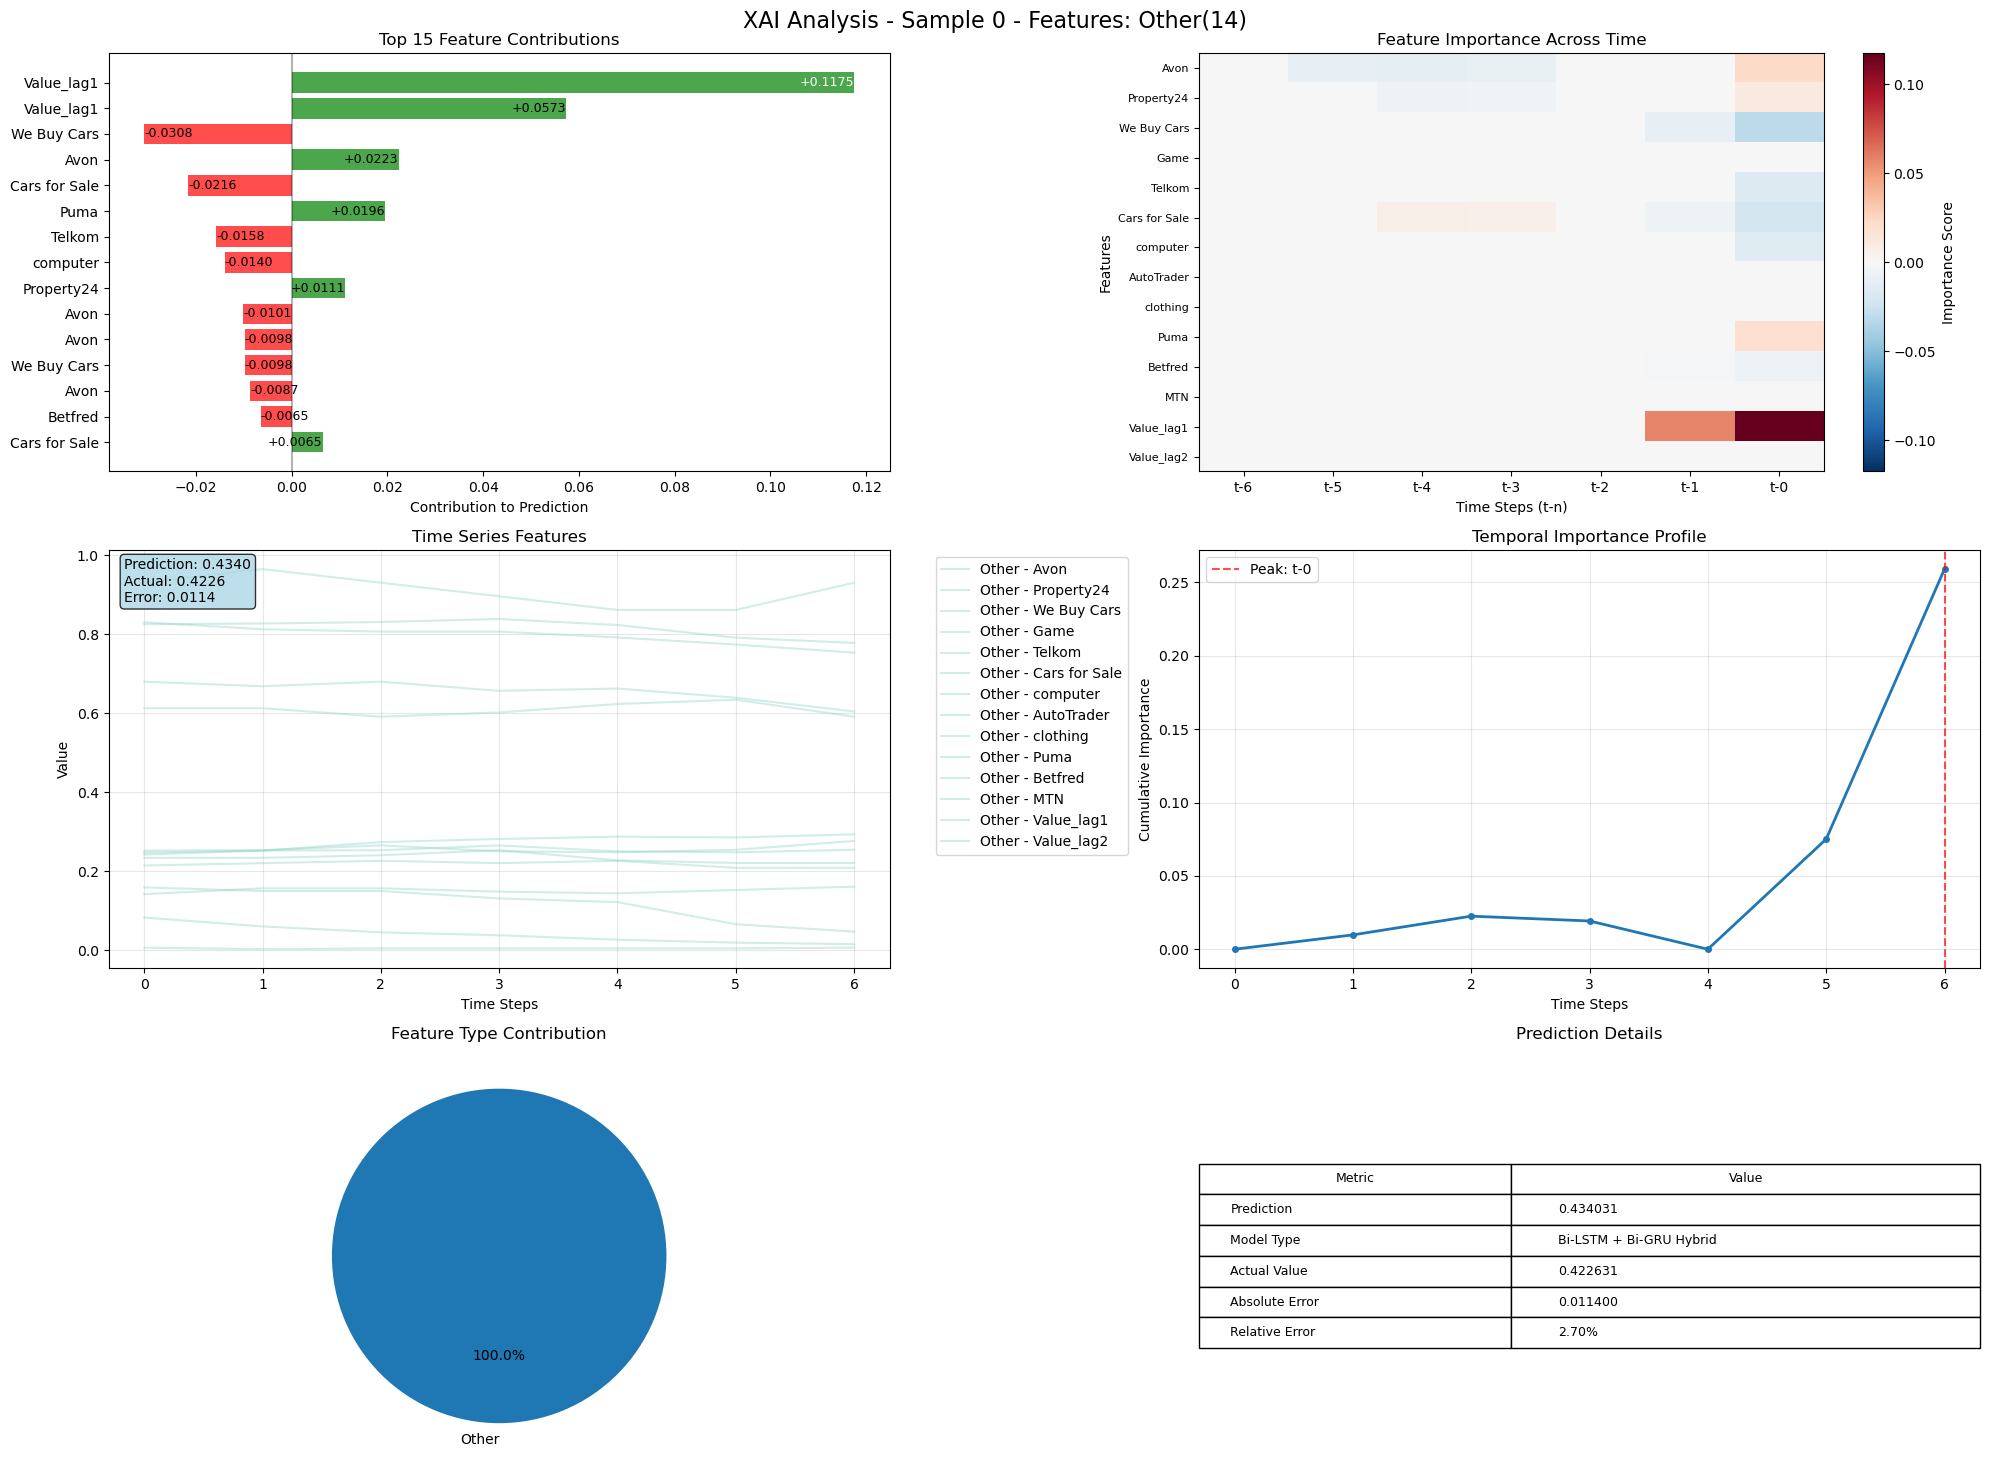

Saved: lime_explanation_sample_0.html

ANALYZING SAMPLE 1
Intercept 0.4564647685457635
Prediction_local [0.43119995]
Right: 0.45111614


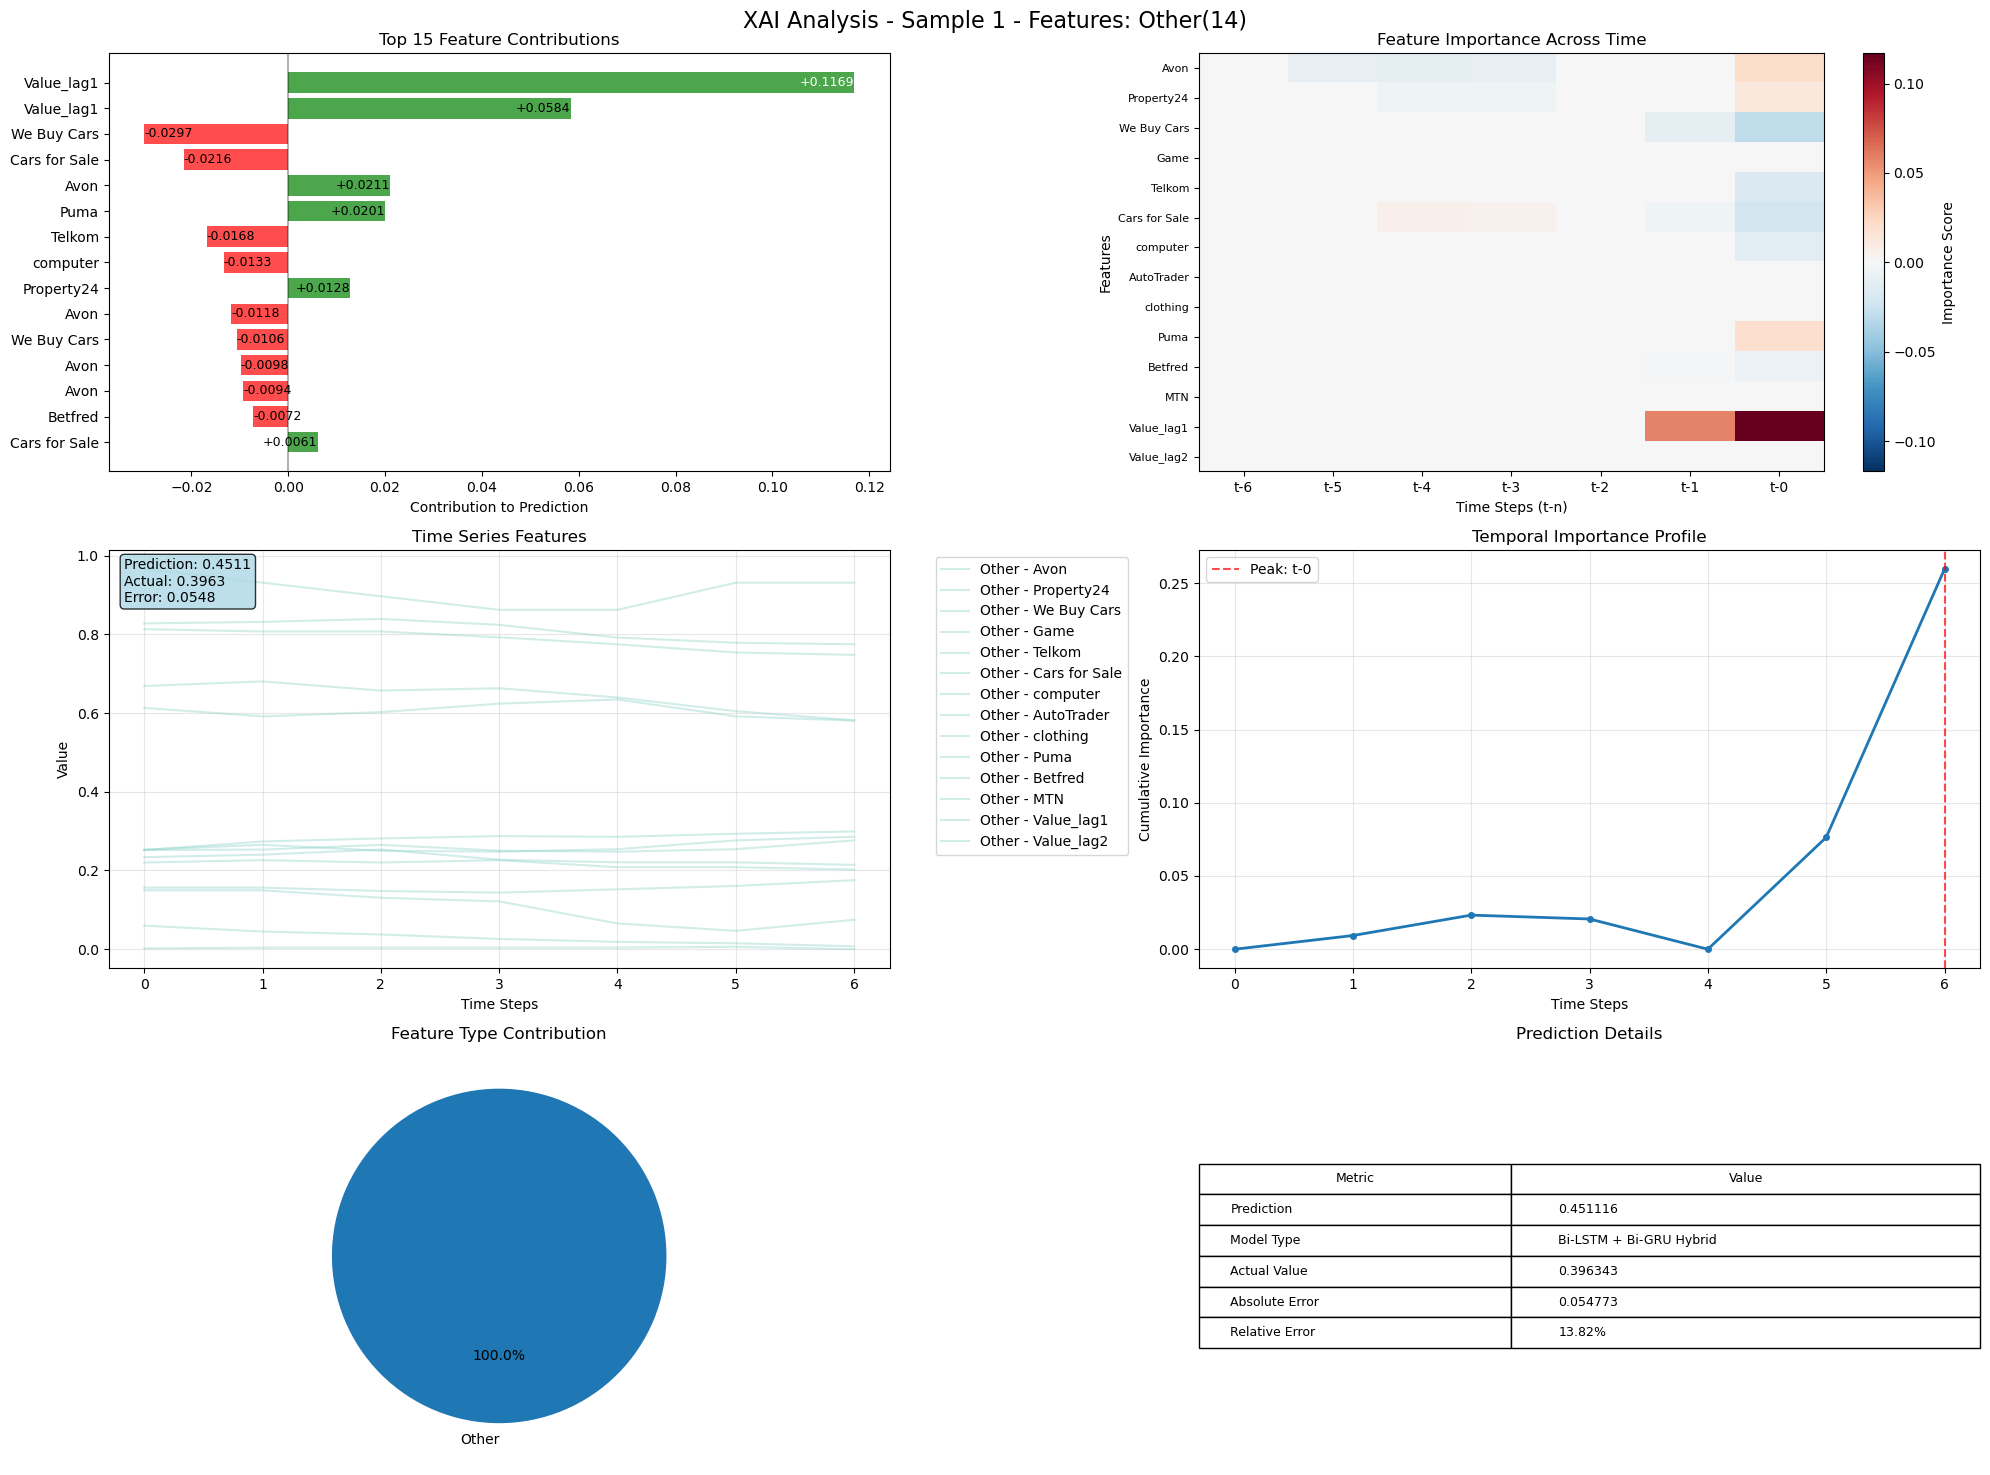

Saved: lime_explanation_sample_1.html

ANALYZING SAMPLE 2
Intercept 0.4573966237923012
Prediction_local [0.42803154]
Right: 0.456838


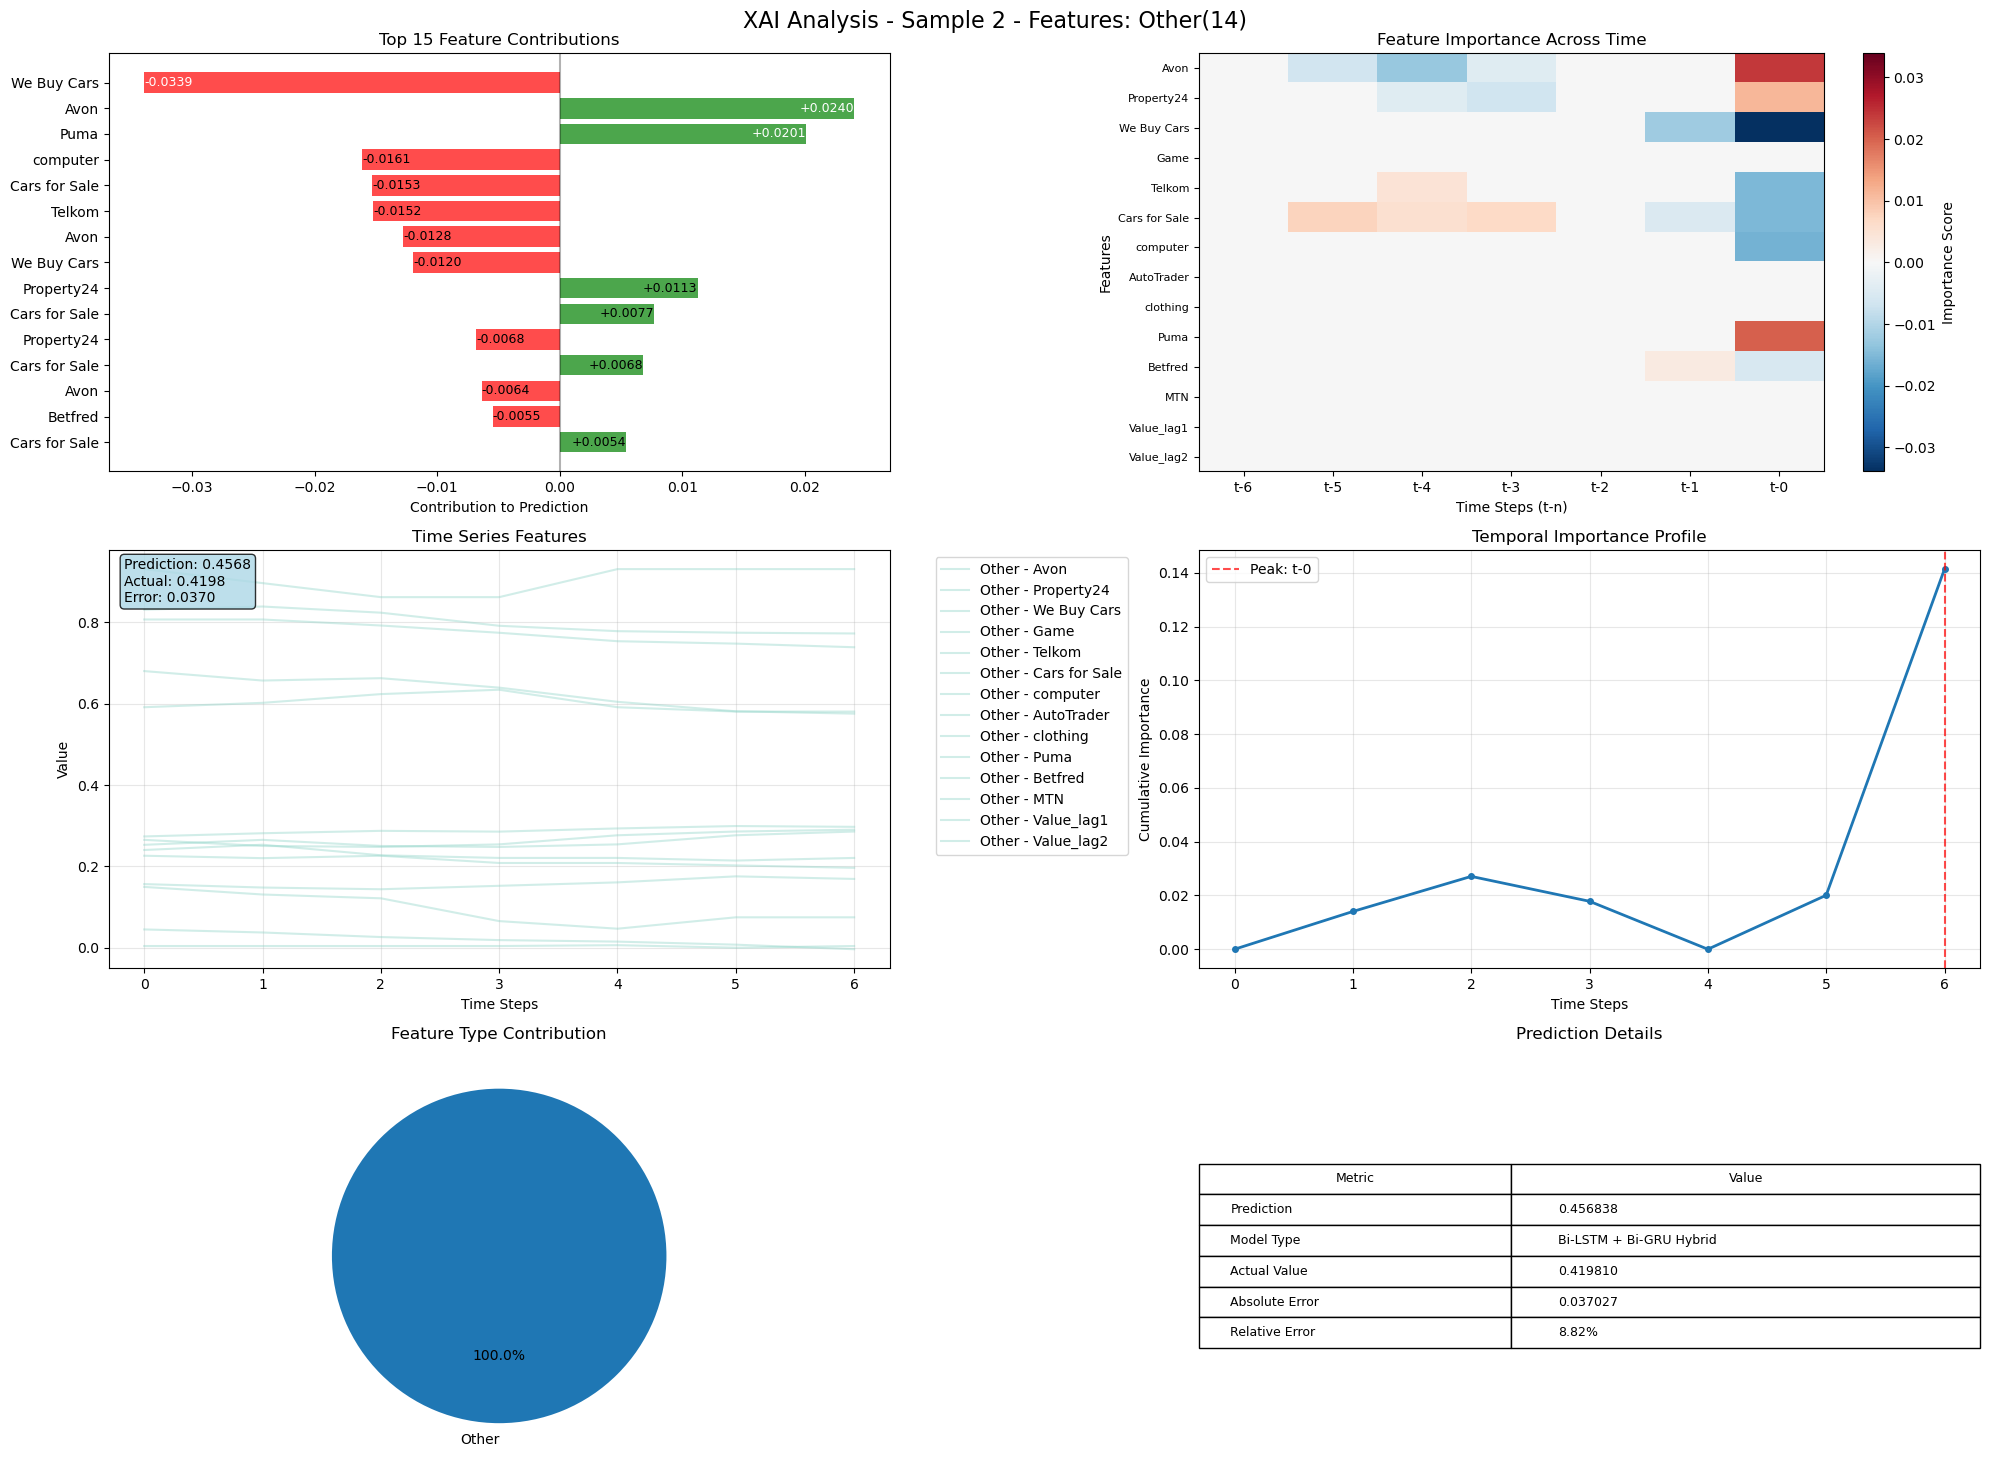

Saved: lime_explanation_sample_2.html


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_tabular
import seaborn as sns
from matplotlib.gridspec import GridSpec
import pandas as pd

# Get feature names from X_train_df
n_features = X_train_df.shape[1] if hasattr(X_train_df, 'shape') else n_features
feature_names = X_train_df.columns.tolist()[:n_features]  # Take first n_features

class AdvancedTimeSeriesLIME:
    def __init__(self, model, X_train_seq, feature_names, seq_length):
        self.model = model
        self.seq_length = seq_length
        self.n_features = len(feature_names)
        self.feature_names = feature_names
        self.X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
        
        # Create descriptive time-aware feature names
        self.time_feature_names = [
            f"t-{self.seq_length-t-1}_{feature_names[f]}" 
            for t in range(self.seq_length) 
            for f in range(self.n_features)
        ]
        
        print(f"Created {len(self.time_feature_names)} time-aware feature names")
        print("Sample feature names:", self.time_feature_names[:5])
        
        self.explainer = lime_tabular.LimeTabularExplainer(
            training_data=self.X_train_flat,
            mode="regression",
            feature_names=self.time_feature_names,
            discretize_continuous=False,
            random_state=42,
            verbose=True
        )
    
    def predict_fn(self, x):
        """Prediction function with error handling"""
        try:
            x_reshaped = x.reshape(-1, self.seq_length, self.n_features)
            predictions = self.model.predict(x_reshaped, verbose=0)
            return predictions
        except Exception as e:
            print(f"Prediction error: {e}")
            return np.zeros((x.shape[0], 1))
    
    def explain_instance(self, sample_flat, num_features=20, num_samples=5000):
        """Enhanced explanation with real feature names"""
        exp = self.explainer.explain_instance(
            data_row=sample_flat,
            predict_fn=self.predict_fn,
            num_features=num_features,
            num_samples=num_samples
        )
        return exp
    
    def create_comprehensive_visualization(self, exp, original_sequence, prediction, actual=None, sample_idx=0):
        """Create visualization with real feature names"""
        fig = plt.figure(figsize=(20, 15))
        gs = GridSpec(3, 2, figure=fig)
        
        # 1. Feature Importance Bar Plot
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_feature_importance(exp, ax1, top_k=15)
        
        # 2. Temporal Heatmap
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_temporal_heatmap(exp, original_sequence, ax2)
        
        # 3. Original Time Series
        ax3 = fig.add_subplot(gs[1, 0])
        self._plot_original_timeseries(original_sequence, prediction, actual, ax3)
        
        # 4. Feature Importance Over Time
        ax4 = fig.add_subplot(gs[1, 1])
        self._plot_feature_importance_time(exp, ax4)
        
        # 5. Feature Type Analysis
        ax5 = fig.add_subplot(gs[2, 0])
        self._plot_feature_type_analysis(exp, ax5)
        
        # 6. Prediction Analysis
        ax6 = fig.add_subplot(gs[2, 1])
        self._plot_prediction_analysis(prediction, actual, ax6)
        
        plt.suptitle(f'XAI Analysis - Sample {sample_idx} - {self._get_feature_categories()}', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def _plot_feature_importance(self, exp, ax, top_k=15):
        """Plot feature importance with real names"""
        features = exp.as_list()[:top_k]
        features.reverse()
        
        # Extract time step and feature name from the combined string
        simplified_names = []
        for full_name, value in features:
            # Extract feature name from "t-X_FeatureName"
            feature_name = full_name.split('_', 1)[1] if '_' in full_name else full_name
            simplified_names.append(feature_name)
        
        values = [f[1] for f in features]
        colors = ['red' if x < 0 else 'green' for x in values]
        y_pos = np.arange(len(simplified_names))
        
        bars = ax.barh(y_pos, values, color=colors, alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(simplified_names, fontsize=10)
        ax.set_xlabel('Contribution to Prediction')
        ax.set_title(f'Top {top_k} Feature Contributions')
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Add value annotations
        for i, (v, name) in enumerate(zip(values, simplified_names)):
            ax.text(v, i, f'{v:+.4f}', va='center', 
                   ha='left' if v < 0 else 'right', 
                   fontsize=9, color='black' if abs(v) < max(abs(np.array(values))) * 0.5 else 'white')
    
    def _plot_temporal_heatmap(self, exp, original_sequence, ax):
        """Enhanced heatmap with feature names"""
        weights = dict(exp.as_list())
        
        importance = np.zeros((self.seq_length, self.n_features))
        
        for t in range(self.seq_length):
            for f in range(self.n_features):
                feat_name = f"t-{self.seq_length-t-1}_{self.feature_names[f]}"
                importance[t, f] = weights.get(feat_name, 0)
        
        # Create heatmap
        im = ax.imshow(importance.T, aspect='auto', cmap='RdBu_r', 
                      vmin=-np.max(np.abs(importance)), vmax=np.max(np.abs(importance)))
        
        ax.set_xlabel('Time Steps (t-n)')
        ax.set_ylabel('Features')
        ax.set_title('Feature Importance Across Time')
        
        # Set y-axis labels with feature names
        ax.set_yticks(range(self.n_features))
        ax.set_yticklabels(self.feature_names, fontsize=8)
        
        # Add time labels
        time_labels = [f't-{i}' for i in range(self.seq_length-1, -1, -max(1, self.seq_length//10))]
        ax.set_xticks(range(0, self.seq_length, max(1, self.seq_length//10)))
        ax.set_xticklabels(time_labels[:len(ax.get_xticks())])
        
        plt.colorbar(im, ax=ax, label='Importance Score')
        
        # Add feature category annotations
        if self._has_technical_indicators():
            ax.text(0.02, 0.98, self._get_feature_categories(), transform=ax.transAxes,
                   fontsize=8, verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    def _plot_original_timeseries(self, original_sequence, prediction, actual, ax):
        """Plot time series with feature grouping"""
        time_steps = range(self.seq_length)
        
        # Group features by type if possible
        feature_groups = self._group_features_by_type()
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(feature_groups)))
        
        for group_idx, (group_name, feature_indices) in enumerate(feature_groups.items()):
            for f_idx in feature_indices:
                if f_idx < self.n_features:
                    alpha = 0.7 if len(feature_indices) == 1 else 0.4
                    label = f"{group_name} - {self.feature_names[f_idx]}" if len(feature_indices) > 1 else self.feature_names[f_idx]
                    ax.plot(time_steps, original_sequence[:, f_idx], 
                           color=colors[group_idx], alpha=alpha, label=label, linewidth=1.5)
        
        # Prediction info
        pred_text = f'Prediction: {prediction:.4f}'
        if actual is not None:
            pred_text += f'\nActual: {actual:.4f}\nError: {abs(prediction-actual):.4f}'
        
        ax.text(0.02, 0.98, pred_text, transform=ax.transAxes, 
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Value')
        ax.set_title('Time Series Features')
        if len(feature_groups) <= 8:  # Only show legend if not too many groups
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    def _plot_feature_importance_time(self, exp, ax):
        """Plot temporal importance with feature categories"""
        weights = dict(exp.as_list())
        
        time_importance = np.zeros(self.seq_length)
        feature_importance = np.zeros(self.n_features)
        
        for t in range(self.seq_length):
            for f in range(self.n_features):
                feat_name = f"t-{self.seq_length-t-1}_{self.feature_names[f]}"
                if feat_name in weights:
                    importance = abs(weights[feat_name])
                    time_importance[t] += importance
                    feature_importance[f] += importance
        
        ax.plot(range(self.seq_length), time_importance, marker='o', linewidth=2, markersize=4)
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Cumulative Importance')
        ax.set_title('Temporal Importance Profile')
        ax.grid(True, alpha=0.3)
        
        # Highlight important time steps
        max_idx = np.argmax(time_importance)
        ax.axvline(x=max_idx, color='red', linestyle='--', alpha=0.7, 
                  label=f'Peak: t-{self.seq_length-max_idx-1}')
        ax.legend()
    
    def _plot_feature_type_analysis(self, exp, ax):
        """Analyze feature types contribution"""
        weights = dict(exp.as_list())
        
        feature_groups = self._group_features_by_type()
        group_contributions = {group: 0 for group in feature_groups.keys()}
        
        for t in range(self.seq_length):
            for f in range(self.n_features):
                feat_name = f"t-{self.seq_length-t-1}_{self.feature_names[f]}"
                if feat_name in weights:
                    # Find which group this feature belongs to
                    for group_name, indices in feature_groups.items():
                        if f in indices:
                            group_contributions[group_name] += abs(weights[feat_name])
                            break
        
        # Plot pie chart
        if sum(group_contributions.values()) > 0:
            labels = list(group_contributions.keys())
            sizes = [group_contributions[label] for label in labels]
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
            ax.set_title('Feature Type Contribution')
        else:
            ax.text(0.5, 0.5, 'No contribution data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Feature Type Contribution')
    
    def _plot_prediction_analysis(self, prediction, actual, ax):
        """Enhanced prediction analysis"""
        metrics = {
            'Prediction': f'{prediction:.6f}',
            'Model Type': 'Bi-LSTM + Bi-GRU Hybrid'
        }
        
        if actual is not None:
            metrics.update({
                'Actual Value': f'{actual:.6f}',
                'Absolute Error': f'{abs(prediction - actual):.6f}',
                'Relative Error': f'{abs(prediction - actual) / abs(actual) * 100:.2f}%'
            })
        
        ax.axis('off')
        table_data = [[k, v] for k, v in metrics.items()]
        table = ax.table(cellText=table_data, 
                        colLabels=['Metric', 'Value'], 
                        loc='center', 
                        cellLoc='left',
                        colWidths=[0.4, 0.6])
        
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        ax.set_title('Prediction Details')
    
    def _group_features_by_type(self):
        """Intelligently group features by their names"""
        groups = {}
        
        # Common financial feature patterns
        price_patterns = ['open', 'high', 'low', 'close', 'price']
        volume_patterns = ['volume', 'vol']
        technical_patterns = ['rsi', 'macd', 'sma', 'ema', 'atr', 'bollinger', 'vwap', 'momentum']
        volatility_patterns = ['volatility', 'std', 'variance']
        change_patterns = ['change', 'return', 'delta']
        
        for i, feature_name in enumerate(self.feature_names):
            feature_lower = feature_name.lower()
            
            if any(pattern in feature_lower for pattern in price_patterns):
                group = 'Price'
            elif any(pattern in feature_lower for pattern in volume_patterns):
                group = 'Volume'
            elif any(pattern in feature_lower for pattern in technical_patterns):
                group = 'Technical'
            elif any(pattern in feature_lower for pattern in volatility_patterns):
                group = 'Volatility'
            elif any(pattern in feature_lower for pattern in change_patterns):
                group = 'Changes'
            else:
                group = 'Other'
            
            if group not in groups:
                groups[group] = []
            groups[group].append(i)
        
        return groups
    
    def _has_technical_indicators(self):
        """Check if features include technical indicators"""
        return any(any(pattern in name.lower() for pattern in ['rsi', 'macd', 'sma', 'ema']) 
                  for name in self.feature_names)
    
    def _get_feature_categories(self):
        """Get feature categories summary"""
        groups = self._group_features_by_type()
        return f"Features: {', '.join(f'{k}({len(v)})' for k, v in groups.items())}"



In [ ]:
import os
import numpy as np

# Models and names
models_dict = {
    "LSTM": lstm_model,
    "Bi-LSTM": bi_lstm_model,
    "GRU": gru_model,
    "Bi-GRU": bigru_model,
    "Hybrid": hybrid_model
}

# Number of validation samples to explain
n_samples_to_explain = 3  

# Main folder for all LIME reports
base_folder = "lime_reports_google_value"
os.makedirs(base_folder, exist_ok=True)

for model_name, model in models_dict.items():
    print(f"\n{'='*80}\nProcessing XAI for {model_name}\n{'='*80}")
    
    # Create folder for the current model
    model_folder = os.path.join(base_folder, model_name.replace(" ", "_"))
    os.makedirs(model_folder, exist_ok=True)
    
    # Initialize LIME
    lime_xai = AdvancedTimeSeriesLIME(
        model=model,
        X_train_seq=X_train_seq,
        feature_names=feature_names,
        seq_length=seq_length
    )
    
    # Flatten validation data
    X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)
    
    # Run LIME explanations for first n_samples_to_explain
    for i in range(min(n_samples_to_explain, len(X_val_seq))):
        print(f"\nAnalyzing sample {i} for {model_name}...")
        
        exp = lime_xai.explain_instance(X_val_flat[i])
        prediction = lime_xai.predict_fn(X_val_flat[i:i+1])[0][0]
        actual = y_val_seq[i][0] if y_val_seq is not None else None
        
        # Visualization
        lime_xai.create_comprehensive_visualization(
            exp, X_val_seq[i], prediction, actual, sample_idx=i
        )
        
        # Save HTML report
        html_path = os.path.join(model_folder, f"lime_explanation_sample_{i}.html")
        with open(html_path, "w", encoding='utf-8') as f:
            f.write(exp.as_html())
        print(f"Saved LIME explanation: {html_path}")
